# Anaysis pipeline of _D. novamexicana_ post-mating RNAseq 

## Introduction

(Some blurb here about the project goals, sample prep, etc.)

### Load packages and generate some useful functions

The analysis below relies on several R packages and custom functions that are used for plotting and extracting gene-level annotation info. The packages can be defined and loaded like so:

In [1]:
req_packages = c("Biobase", "cluster", "cowplot", "cummeRbund", 
                 "data.table", "DESeq", "edgeR", "ggplot2", 
                 "ggrepel", "ggthemes", "ggthemr", "Glimma", 
                 "GO.db", "goseq", "gplots", "grid", "gridExtra", 
                 "heatmap3", "imager", "plotly", "qvalue", "RColorBrewer", 
                 "reshape", "Rmisc", "splitstackshape", "statmod", 
                 "VennDiagram")

lapply(req_packages, require, character.only = TRUE)

# The Cowplot package changes the default themes of ggplot2. Set the default theme like so:
theme_set(theme_gray())

Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colnames, do.call,
    duplicated, eval, evalq, Filter, Find, get, grep, grepl, intersect,
    is.unsorted, lapply, lengths, Map, mapply, match, mget, order,
    paste, pmax, pmax.int, pmin, pmin.int, Position, rank, rbind,
    Reduce, rownames, sapply, setdiff, sort, table, tapply, union,
    unique, unsplit, which, which.max, which.min

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignette

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

[[12]]
[1] TRUE

[[13]]
[1] TRUE

[[14]]
[1] TRUE

[[15]]
[1] TRUE

[[16]]
[1] TRUE

[[17]]
[1] TRUE

[[18]]
[1] TRUE

[[19]]
[1] TRUE

[[20]]
[1] TRUE

[[21]]
[1] TRUE

[[22]]
[1] TRUE

[[23]]
[1] TRUE

[[24]]
[1] TRUE

[[25]]
[1] TRUE

[[26]]
[1] TRUE

[[27]]
[1] TRUE

The functions used in the analyses are in the file "Functions2.R":

In [2]:
source("Functions2.R")

These functions include: 
  * `MA_Bplot`: a function for generating MA plots and histograms of genes above 2-fold abundance
  * `plotGenePM`: for plotting mean±s.e TPM expression barplots (plotGenePM_RT plots Reproductive Tract expression only)
  * `plotHeatmap`: generic plotter for heatmaps with ggplot (requires matrix)
  * `calcSpecificity`: a function for calculating gene-wise tissue-specificity
  * `geneLookupG`: a function for extracting Trinotate annotations
  * `heatmap3`: for plotting heatmaps
  * ... and other miscellaneous RNAseq and R functions

### Load annotations, PAML data and orthology information

Some annotation files were generated from the _D. virilis_ transcriptome—in addition to miscellaneous population genetic data from the species group—that can be used here to annotate transcripts at various stages of the analysis. Load that data and process it for further use.

#### Annotations:
A Trinotate report and accompanying Gene Ontology assignments were produced in an earlier study that can be used here:

In [113]:
grpTrinotate = read.csv("Annotations/Trinotate_report_dvir1.06_subset.txt", header = T, sep = "\t", na.strings = "", stringsAsFactors=FALSE)
GO_info = read.table("Annotations/Trinotate_report_dvir1.06_gene_ontology.txt", header=F, row.names=1,stringsAsFactors=F)

Another useful annotation file is the gene features file:

In [114]:
gffRecord = read.table("Annotations/FBgn_ID_name_coordinates.txt", header = T)

From FlyBase we can obtain information on orthology to _D. melanogaster_:

In [115]:
melOrths = read.table(file = "Annotations/mel_orths.txt", header = T)
melOrthsAll = aggregate(mel_GeneSymbol~FBgn_ID, data = melOrths, toString)

Finally, we can combine the files above for convenience:

In [116]:
Annots = merge(merge(melOrthsAll, grpTrinotate, all=TRUE), gffRecord, all=TRUE)

#### PAML data

Also from the previous RNAseq study on the virilis sub-group, some PAML and Ka/Ks results can be used here:

In [7]:
tmp.FB.names = unique(subset(Annots, select=c("FBgn_ID", "FBtr_ID")))
paml.data = read.csv(file = "Annotations/PAML.branchSite.ALL.results.txt", header = T, sep = "\t")
paml.data = merge(tmp.FB.names, paml.data, all=T)
paml.data = merge(gffRecord, paml.data, all=T)
KaKs.data = read.csv(file = "Annotations/KaKs.ALL.results.txt", header = T, sep = "\t", check.names = F)
KaKs.data = merge(tmp.FB.names, KaKs.data, all=T)
KaKs.data = merge(gffRecord, KaKs.data, all=T)

We can combine gene names and descriptions with FBgn ID's in a 1:1 mapping to use in platting functions later.

In [117]:
annot.sum = unique(subset(Annots, select=c("FBgn_ID", "gene_name", "SwissProt_BlastX_Description")))
annot.sum = aggregate(SwissProt_BlastX_Description ~ FBgn_ID + gene_name, data = annot.sum, toString)

### Load expression matrices:

The raw counts from each sample obtained from `eXpress` can be loaded as a data-frame:

In [9]:
countsMatrix = read.table("ExpressionData/genes_DnovPM_dvi1.06.counts.matrix", header=T, row.names=1, com='', check.names=F)

The normalized expression values—expressed in TPM units—can also be loaded as a data-frame:

In [10]:
tpmMatrix = read.table("ExpressionData/genes_DnovPM_dvi1.06.TMM.EXPR.matrix", header=T, row.names=1, com='', check.names=F)

Finally, a table of aggregate gene number by minimum TPM is usefull to estimate the number of expressed genes in the dataset:

In [11]:
cbmtMatrix = read.table("ExpressionData/genes_DnovPM_dvi1.06.TPM.not_cross_norm.counts_by_min_TPM", header = T)

#### Read in sample information: 

The `samples.txt` and `SamplesInfo.txt` files describe the replicate:sample mapping and additional sample information:

In [12]:
sampleData = read.table("ExpressionData/samples.txt", header=F, check.names=F, fill=T)
sampleData = DnovPM.Samples_data[DnovPM.Samples_data[,2] != '',]
sampleInfo = read.table("ExpressionData/SampleInfo.txt", header=T, check.names=F, fill=T)

## Quality Control:-

##### Barplot of library size

After read trimming and filtering out low quality reads, we can check the library sizes of the samples to see if we satisfy the 10-20 million read minimum:

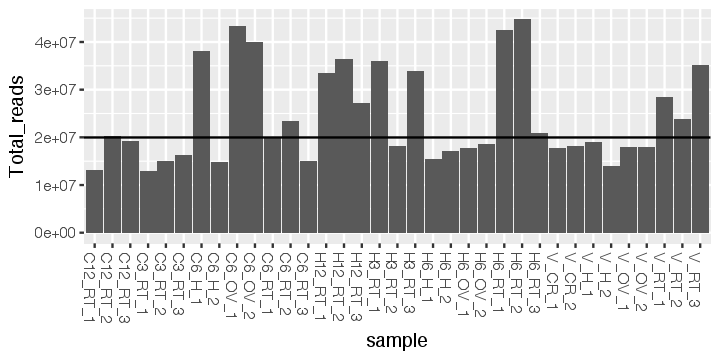

In [13]:
libSizes <- as.data.frame(colSums(countsMatrix))
libSizes <- cbind(sample = row.names(libSizes), libSizes)
row.names(libSizes)<- NULL
colnames(libSizes) = c("sample", "Total_reads")
options(repr.plot.width = 6, repr.plot.height = 3)
ggplot(libSizes, aes(sample, Total_reads)) + 
    geom_bar(stat="identity") + 
    theme(axis.text.x = element_text(angle = -90, hjust = 0)) + 
    geom_hline(yintercept = 20000000)

Looks like all the samples have >10 million reads, so the read counts look OK.

##### Boxplot of log10(TPM) across samples

To get a sense for broad expression patterns across samples, we can generate boxplots of TPM expression across samples to see if there are large median differences between samples/replicates:

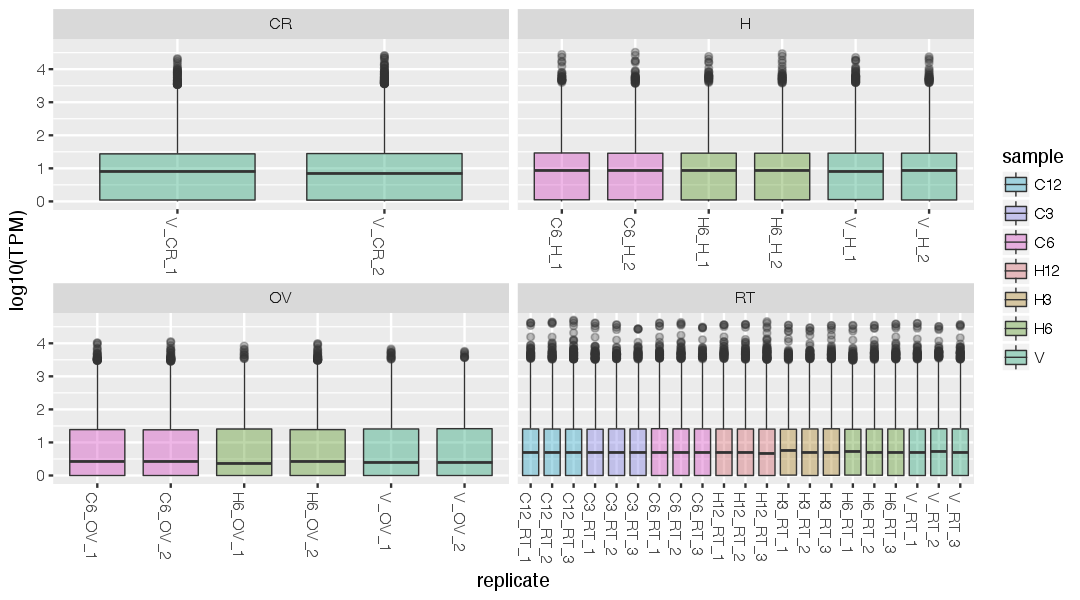

In [14]:
m.expData<-melt(as.matrix(tpmMatrix))
colnames(m.expData) <- c("gene_id", "replicate", "TPM")
m.expData.exp<- within(m.expData, replicate<-data.frame(do.call('rbind', strsplit(as.character(replicate),'_',fixed=TRUE))))
m.expData<-data.frame(m.expData, m.expData.exp$replicate$X1, m.expData.exp$replicate$X2, m.expData.exp$replicate$X3)
colnames(m.expData) <- c("gene_id", "replicate", "TPM", "sample", "tissue", "rep_num")
m.expData$TPM <- m.expData$TPM + 1
options(repr.plot.width = 9, repr.plot.height = 5)
ggplot(m.expData) + 
    geom_boxplot(aes(x = replicate, y = log10(TPM), fill = sample), size = 0.3, alpha = I(1/3)) + 
    facet_wrap(~tissue, scales = "free_x") +
    theme(axis.text.x = element_text(angle = -90, hjust = 0)) + 
    scale_fill_hue(l = 50, h.start = 200)

This is almost useless, but shows that all samples have roughly the same median expression values and similar spread across genes. We'll generate boxplots of normalized log2 counts for subsetted tissue matrices later.

##### Estimate of the number of expressed genes (Brian Haas' method) 

Several approaches can be used to filter out genes with little to no expression. This step is necessary because it reduces the potential for false-positives and improves the strength of detecting differentially expressed genes. One approach that Brian Haas uses with _de novo_ assembled transcripts (which have lots of garbage transcripts) is to plot the aggregate number of genes as a function of minimum TPM. Towards low TPM values, the curve expands and inflates the true number of expressed genes. Thus, fitting a line along the curve provides a reasonable estimate of the true number of expressed genes as the value of the y-intercept.

To accomplish this, we first extract the "trully expressed genes" (in this case, between 10 and 100 TPM):

In [15]:
cbmt.sub = cbmtMatrix[cbmtMatrix[,1] > -100 & cbmtMatrix[,1] < -10,]

Now we a perform a linear regression on this filtered subset of the data and display the value of the Y-intercept:

In [16]:
cbmt.sub_fit = lm(cbmt.sub[,2] ~ cbmt.sub[,1])
print(cbmt.sub_fit)


Call:
lm(formula = cbmt.sub[, 2] ~ cbmt.sub[, 1])

Coefficients:
  (Intercept)  cbmt.sub[, 1]  
       9185.3           69.4  



We can also plot the curve and linear fit:

Warning message:
"Removed 948 rows containing missing values (geom_point)."

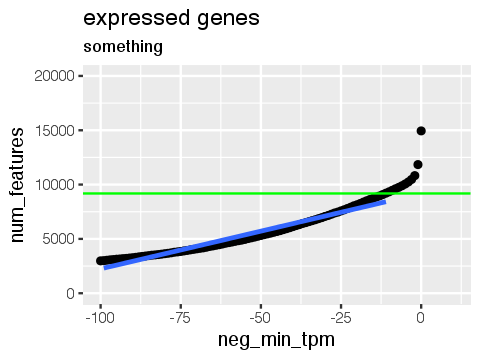

In [17]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(cbmtMatrix, aes(neg_min_tpm,num_features)) + 
    geom_point() +  
    scale_x_continuous(limits=c(-100,10)) + 
    scale_y_continuous(limits=c(0,20000)) + 
    geom_smooth(data=DnovPM_filt_data, method = "lm") + 
    geom_hline(yintercept = 9185, colour = "green") + ggtitle("expressed genes", subtitle = "something")

Out of ~1500 genes, roughly 9000 should remain after filtering lowly expressed geenes. Filtering should be performed on subsetted matrices for each analysis later, but here's the filter applied on the whole matrix. First, obtain the counts per million "CPM" matrix: 

In [18]:
all.CPM <- cpm(countsMatrix)

For now, let's set the minimum CPM to 1, and generate a logical matrix for CPM > 1:

In [19]:
thresh <- all.CPM > 1

We can see how many TRUEs there are in each row:

In [20]:
table(rowSums(thresh))


   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
3998  150  273  164   97   88  401  152  355  162   82   54   65   38   53   42 
  16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31 
  54   30   28   36   29   85   35   49   45   40   26   78   74  599  117   66 
  32   33   34   35 
  66   83  131 7099 

We would like to keep genes that have at least 2 TRUEs in each row of `thresh`:

In [21]:
keep <- rowSums(thresh) >= 2

Now we subset the rows of the counts matrix to keep genes that satisfy our filter, then check how many genes are left:

In [22]:
counts.keep <- DnovPM.dvir1.06.CountsMatrix[keep,]
dim(counts.keep)

[1] 10796    35

## Differential expression analysis

### Virgin tissue contrasts:

The goal of this part of the analysis is to identify transcripts that show tissue-biased expression. We'll set a stringent cut-off of log 2-fold and a _p_-value of 0.001. 

First we'll subset the count matrix to only include virgin tissue samples:

In [23]:
countsMatrix.virgin = subset(countsMatrix, select=grepl("^V", colnames(countsMatrix)))
head(countsMatrix.virgin)

,V_CR_1,V_CR_2,V_H_1,V_H_2,V_OV_1,V_OV_2,V_RT_1,V_RT_2,V_RT_3
FBgn0202928,3232.66,3082.93,3879.65,2595.06,1520.47,1293.97,1092.88,863.67,1396.54
FBgn0199886,0.00,0.00,5.05,5.10,0.00,0.00,0.00,0.00,0.00
FBgn0199563,520.27,645.77,442.95,353.21,689.31,570.83,631.27,559.54,715.31
FBgn0211236,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
FBgn0206588,1251.06,929.85,1578.18,1563.96,3505.96,3700.23,1992.25,1559.37,2273.14
FBgn0211037,47.61,30.46,66.80,28.85,150.51,114.51,88.10,75.31,109.11


Now we can filter out low expression genes with a minimum 5 cpm cutoff:

In [24]:
cpmMatrix.virgin <- cpm(countsMatrix.virgin)
v.thresh <- cpmMatrix.virgin > 5
## look at number of columns with above requirements
table(rowSums(v.thresh))

v.keep <- rowSums(v.thresh) >= 3
countsMatrix.virgin.filt <- countsMatrix.virgin[v.keep,]
## Check how many genes remain in the matrix.
dim(countsMatrix.virgin.filt)


   0    1    2    3    4    5    6    7    8    9 
5057  167 1219  554  488  274  218  841  290 5836 

[1] 8501    9

The filtered matrix contains 9720 genes. Let's see what the # cpm cutoff corresponds to in counts (looking at just one of the samples):

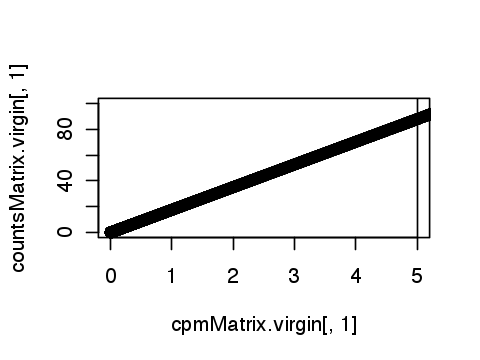

In [25]:
# Let's look at the first column
plot(cpmMatrix.virgin[,1],countsMatrix.virgin[,1],ylim=c(0,100),xlim=c(0,5))
# Add a vertical line at 5 CPM
abline(v=5)

Looks like 5 cpm corresponds to 60-100 mapped reads.

We'll also subset the `samplesData` object to only include the virgin tissue samples:

In [26]:
sampleInfo.v = subset(sampleInfo, Status == "virgin")
sampleInfo.v

,SampleName,Replicate,Tissue,Status,time
27,V_CR,V_CR_1,carcass,virgin,0hpm
28,V_CR,V_CR_2,carcass,virgin,0hpm
29,V_H,V_H_1,head,virgin,0hpm
30,V_H,V_H_2,head,virgin,0hpm
31,V_OV,V_OV_1,ovaries,virgin,0hpm
32,V_OV,V_OV_2,ovaries,virgin,0hpm
33,V_RT,V_RT_1,repTract,virgin,0hpm
34,V_RT,V_RT_2,repTract,virgin,0hpm
35,V_RT,V_RT_3,repTract,virgin,0hpm


We can now define groups for differential expression:

In [27]:
groups.v = factor(sampleInfo.v$Tissue)
design.v = model.matrix( ~ 0 + groups.v)
colnames(design.v) <- levels(groups.v)
rownames(design.v) <- sampleInfo.v$Replicate
design.v

,carcass,head,ovaries,repTract
V_CR_1,1,0,0,0
V_CR_2,1,0,0,0
V_H_1,0,1,0,0
V_H_2,0,1,0,0
V_OV_1,0,0,1,0
V_OV_2,0,0,1,0
V_RT_1,0,0,0,1
V_RT_2,0,0,0,1
V_RT_3,0,0,0,1


Now we'll create the `DGE` object and fit the general linear model:

In [118]:
dgeList.v <- DGEList(counts = countsMatrix.virgin.filt, group = groups.v)
dgeList.v <- calcNormFactors(dgeList.v)
dgeList.v <- estimateCommonDisp(dgeList.v)
dgeList.v <- estimateTagwiseDisp(dgeList.v)

# We'll call this here, but will use it later to test for differential expression.
dgeList.v_fit <- glmFit(dgeList.v, design.v)

We can add annotation information to the fit object, and slot it into the `genes` slot:

In [123]:
ann.v = subset(annot.sum, FBgn_ID %in% rownames(dgeList.v_fit))
head(ann.v)
ann.v = data.frame(lapply(ann.v, as.character), stringsAsFactors=FALSE)
head(ann.v)
ann.v = ann.v[match(rownames(dgeList.v_fit), ann.v$FBgn_ID),]
ann.v
ann.v <- data.frame(lapply(ann.v, as.character), stringsAsFactors=FALSE)
table(ann.v$FBgn_ID==rownames(dgeList.v_fit))
dgeList.v_fit$genes = ann.v

,FBgn_ID,gene_name,SwissProt_BlastX_Description
1,FBgn0015205,140up,RPII140-upstream gene protein
2,FBgn0257406,18SrRNA:GJ25572,.
3,FBgn0257407,18SrRNA:GJ25573,.
4,FBgn0257408,18SrRNA:GJ25574,.
5,FBgn0257409,18SrRNA:GJ25575,.
114,FBgn0256714,5.8SrRNA:GJ24880,.


FBgn_ID,gene_name,SwissProt_BlastX_Description
FBgn0015205,140up,RPII140-upstream gene protein
FBgn0257406,18SrRNA:GJ25572,.
FBgn0257407,18SrRNA:GJ25573,.
FBgn0257408,18SrRNA:GJ25574,.
FBgn0257409,18SrRNA:GJ25575,.
FBgn0256714,5.8SrRNA:GJ24880,.


,FBgn_ID,gene_name,SwissProt_BlastX_Description
3033,FBgn0202928,GJ15740,"6-phosphofructo-2-kinase/fructose-2,6-bisphosphatase 1"
1273,FBgn0199563,GJ12317,Differentially expressed in FDCP 8 homolog
5060,FBgn0206588,GJ19445,High mobility group protein DSP1
6447,FBgn0209112,GJ21998,.
1301,FBgn0199619,GJ12374,60S ribosomal protein L8
585,FBgn0198240,GJ10972,"Beta-1,4-mannosyl-glycoprotein 4-beta-N-acetylglucosaminyltransferase"
3747,FBgn0204214,GJ17037,.
4571,FBgn0205669,GJ18511,Dolichyl-diphosphooligosaccharide--protein glycosyltransferase 48 kDa subunit
6386,FBgn0209018,GJ21901,60S ribosomal protein L38
4079,FBgn0204829,GJ17660,Polyprenol reductase



TRUE 
8501 

In [120]:
rownames(dgeList.v_fit)

[1] "FBgn0202928" "FBgn0199563" "FBgn0206588" "FBgn0209112" "FBgn0199619"
   [6] "FBgn0198240" "FBgn0204214" "FBgn0205669" "FBgn0209018" "FBgn0204829"
  [11] "FBgn0211158" "FBgn0210215" "FBgn0207350" "FBgn0202094" "FBgn0200177"
  [16] "FBgn0204239" "FBgn0210786" "FBgn0197431" "FBgn0207363" "FBgn0206592"
  [21] "FBgn0282919" "FBgn0015214" "FBgn0199963" "FBgn0209419" "FBgn0210577"
  [26] "FBgn0200112" "FBgn0203463" "FBgn0211082" "FBgn0207216" "FBgn0210295"
  [31] "FBgn0207785" "FBgn0197497" "FBgn0203413" "FBgn0203073" "FBgn0200797"
  [36] "FBgn0199547" "FBgn0201000" "FBgn0210395" "FBgn0211324" "FBgn0197473"
  [41] "FBgn0208125" "FBgn0197780" "FBgn0211765" "FBgn0210370" "FBgn0209921"
  [46] "FBgn0211145" "FBgn0209341" "FBgn0210667" "FBgn0198327" "FBgn0209057"
  [51] "FBgn0281932" "FBgn0202859" "FBgn0202260" "FBgn0197860" "FBgn0210073"
  [56] "FBgn0283187" "FBgn0211056" "FBgn0205815" "FBgn0199782" "FBgn0201677"
  [61] "FBgn0202399" "FBgn0282388" "FBgn0208485" "FBgn0201944" "FBgn0202519"
  [66] "FBgn0210724" "FBgn0210434" "FBgn0201994" "FBgn0282105" "FBgn0203095"
  [71] "FBgn0201724" "FBgn0202393" "FBgn0210871" "FBgn0282576" "FBgn0205491"
  [76] "FBgn0208299" "FBgn0208363" "FBgn0204655" "FBgn0204797" "FBgn0207183"
  [81] "FBgn0205248" "FBgn0207424" "FBgn0028438" "FBgn0205398" "FBgn0200503"
  [86] "FBgn0198083" "FBgn0211656" "FBgn0210267" "FBgn0199821" "FBgn0066145"
  [91] "FBgn0209747" "FBgn0197532" "FBgn0204696" "FBgn0199008" "FBgn0211680"
  [96] "FBgn0282697" "FBgn0208919" "FBgn0281877" "FBgn0201871" "FBgn0207663"
 [101] "FBgn0209100" "FBgn0197824" "FBgn0199927" "FBgn0211501" "FBgn0200976"
 [106] "FBgn0208834" "FBgn0201003" "FBgn0199589" "FBgn0211341" "FBgn0211263"
 [111] "FBgn0200436" "FBgn0199627" "FBgn0209493" "FBgn0283126" "FBgn0205756"
 [116] "FBgn0209651" "FBgn0205362" "FBgn0204408" "FBgn0206687" "FBgn0209852"
 [121] "FBgn0204740" "FBgn0211674" "FBgn0207217" "FBgn0199117" "FBgn0197612"
 [126] "FBgn0207229" "FBgn0202516" "FBgn0208360" "FBgn0203074" "FBgn0202576"
 [131] "FBgn0203220" "FBgn0201395" "FBgn0201592" "FBgn0283011" "FBgn0199480"
 [136] "FBgn0204555" "FBgn0207387" "FBgn0208717" "FBgn0198754" "FBgn0198592"
 [141] "FBgn0204702" "FBgn0209724" "FBgn0208894" "FBgn0204936" "FBgn0283283"
 [146] "FBgn0200428" "FBgn0211038" "FBgn0200453" "FBgn0209562" "FBgn0204681"
 [151] "FBgn0206606" "FBgn0205667" "FBgn0209858" "FBgn0282420" "FBgn0205244"
 [156] "FBgn0206576" "FBgn0205492" "FBgn0207191" "FBgn0207329" "FBgn0013913"
 [161] "FBgn0208931" "FBgn0202327" "FBgn0199420" "FBgn0282262" "FBgn0013912"
 [166] "FBgn0205560" "FBgn0282914" "FBgn0210940" "FBgn0209347" "FBgn0198308"
 [171] "FBgn0208434" "FBgn0282059" "FBgn0199337" "FBgn0203612" "FBgn0209019"
 [176] "FBgn0283045" "FBgn0203874" "FBgn0208828" "FBgn0197418" "FBgn0205531"
 [181] "FBgn0022839" "FBgn0206046" "FBgn0204729" "FBgn0202953" "FBgn0204233"
 [186] "FBgn0210312" "FBgn0211233" "FBgn0210159" "FBgn0201671" "FBgn0201448"
 [191] "FBgn0207066" "FBgn0210175" "FBgn0207940" "FBgn0201014" "FBgn0210385"
 [196] "FBgn0210541" "FBgn0203851" "FBgn0210412" "FBgn0208699" "FBgn0210571"
 [201] "FBgn0209023" "FBgn0210194" "FBgn0197841" "FBgn0203116" "FBgn0211449"
 [206] "FBgn0201358" "FBgn0210323" "FBgn0202008" "FBgn0211766" "FBgn0200409"
 [211] "FBgn0204453" "FBgn0211432" "FBgn0200704" "FBgn0206119" "FBgn0199183"
 [216] "FBgn0211149" "FBgn0282055" "FBgn0208094" "FBgn0201246" "FBgn0209503"
 [221] "FBgn0281997" "FBgn0201321" "FBgn0204356" "FBgn0208232" "FBgn0209009"
 [226] "FBgn0204531" "FBgn0204697" "FBgn0207922" "FBgn0211268" "FBgn0205814"
 [231] "FBgn0208487" "FBgn0211570" "FBgn0199623" "FBgn0208548" "FBgn0207810"
 [236] "FBgn0202929" "FBgn0200276" "FBgn0210047" "FBgn0204519" "FBgn0211434"
 [241] "FBgn0206906" "FBgn0201620" "FBgn0203587" "FBgn0201399" "FBgn0198591"
 [246] "FBgn0208242" "FBgn0202555" "FBgn0211106" "FBgn0205739" "FBgn0205125"
 [251] "FBgn0198807" "FBgn0200508" "FBgn0198499" "FBgn0205494" "FBgn0210572"
 [256] "FBgn0211453" "FBgn0208081" "FBgn0202023" "FBgn0202230" "FBgn0200402"

We can look at what's contained in the DGE object

In [121]:
head(ann.v)

FBgn_ID,gene_name,SwissProt_BlastX_Description
FBgn0202928,GJ15740,"6-phosphofructo-2-kinase/fructose-2,6-bisphosphatase 1"
FBgn0199563,GJ12317,Differentially expressed in FDCP 8 homolog
FBgn0206588,GJ19445,High mobility group protein DSP1
FBgn0209112,GJ21998,.
FBgn0199619,GJ12374,60S ribosomal protein L8
FBgn0198240,GJ10972,"Beta-1,4-mannosyl-glycoprotein 4-beta-N-acetylglucosaminyltransferase"


In [106]:
head(rownames(dgeList.v_fit))

[1] "FBgn0202928" "FBgn0199563" "FBgn0206588" "FBgn0209112" "FBgn0199619"
[6] "FBgn0198240"

In [ ]:
subset()

In [124]:
dgeList.v_fit

An object of class "DGEGLM"
$coefficients
               carcass       head    ovaries   repTract
FBgn0202928  -8.416901  -8.460380  -9.756967 -10.056022
FBgn0199563 -10.096278 -10.544873 -10.560267 -10.607022
FBgn0206588  -9.490043  -9.158122  -8.817965  -9.497544
FBgn0209112  -7.707808  -7.499406  -8.162127  -7.483879
FBgn0199619  -6.120271  -6.504968  -6.432740  -6.483691
8496 more rows ...

$fitted.values
               V_CR_1     V_CR_2      V_H_1      V_H_2     V_OV_1     V_OV_2
FBgn0202928  3432.083  2913.3191  3629.3632  2787.9223  1393.6185  1423.4661
FBgn0199563   639.973   543.2402   451.2934   346.6644   624.0497   637.4152
FBgn0206588  1173.479   996.1058  1806.3104  1387.5307  3564.3083  3640.6464
FBgn0209112  6974.600  5920.3794  9488.2002  7288.4314  6867.6877  7014.7754
FBgn0199619 34117.919 28960.9486 25648.7266 19702.2596 38715.1869 39544.3639
                V_RT_1     V_RT_2     V_RT_3
FBgn0202928  1099.2452   913.0754  1318.4846
FBgn0199563   633.5094   526.2173  

In [81]:
dgeList.v_fit

An object of class "DGEGLM"
$coefficients
               carcass       head    ovaries   repTract
FBgn0202928  -8.416901  -8.460380  -9.756967 -10.056022
FBgn0199563 -10.096278 -10.544873 -10.560267 -10.607022
FBgn0206588  -9.490043  -9.158122  -8.817965  -9.497544
FBgn0209112  -7.707808  -7.499406  -8.162127  -7.483879
FBgn0199619  -6.120271  -6.504968  -6.432740  -6.483691
8496 more rows ...

$fitted.values
               V_CR_1     V_CR_2      V_H_1      V_H_2     V_OV_1     V_OV_2
FBgn0202928  3432.083  2913.3191  3629.3632  2787.9223  1393.6185  1423.4661
FBgn0199563   639.973   543.2402   451.2934   346.6644   624.0497   637.4152
FBgn0206588  1173.479   996.1058  1806.3104  1387.5307  3564.3083  3640.6464
FBgn0209112  6974.600  5920.3794  9488.2002  7288.4314  6867.6877  7014.7754
FBgn0199619 34117.919 28960.9486 25648.7266 19702.2596 38715.1869 39544.3639
                V_RT_1     V_RT_2     V_RT_3
FBgn0202928  1099.2452   913.0754  1318.4846
FBgn0199563   633.5094   526.2173  

And a summary of tagwise disperion

In [82]:
summary(dgeList.v$tagwise.dispersion)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01758 0.02442 0.02920 0.04268 0.03762 1.80300 

We can plot the biological coefficient of variation to examine variability within each sample. It would also be useful to generatea `voom` object as an aside to check compare to the edgeR analyses (from this objectm we can look at the mean-variance trend). Also, let's generate a QQ-plot.

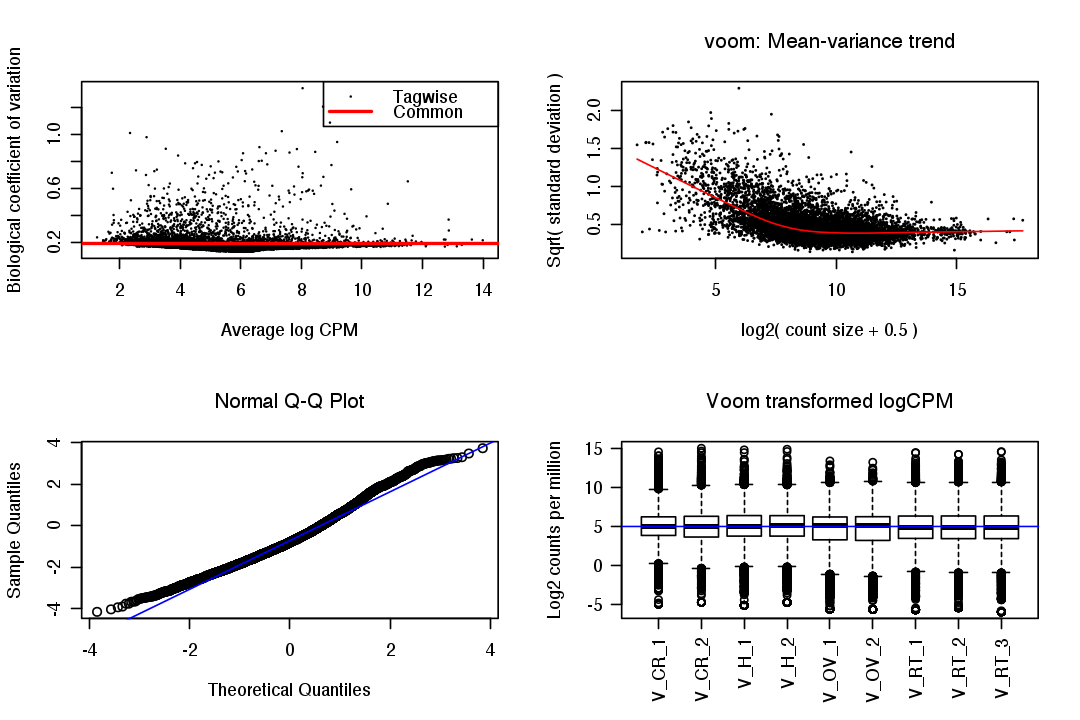

In [83]:
options(repr.plot.width = 9, repr.plot.height = 6)
par(mfrow=c(2,2))
# Biological coefficient of variation
plotBCV(dgeList.v)
# mean-variance trend
virgin.voom = voom(dgeList.v, design.v, plot=TRUE)
# QQ-plot
g.v <- gof(dgeList.v_fit)
z.v <- zscoreGamma(g.v$gof.statistics,shape=g.v$df/2,scale=2)
qqnorm(z.v); qqline(z.v, col = 4,lwd=1,lty=1)
# log2 transformed and normalize boxplot of counts across samples
boxplot(virgin.voom$E, xlab="", ylab="Log2 counts per million",las=2,main="Voom transformed logCPM")
abline(h=median(virgin.voom$E),col="blue")

Looks good. Now let's look at sample groupings using a multidimensional scaling plot (try '`method = "bcv"`' for a different type of grouping):

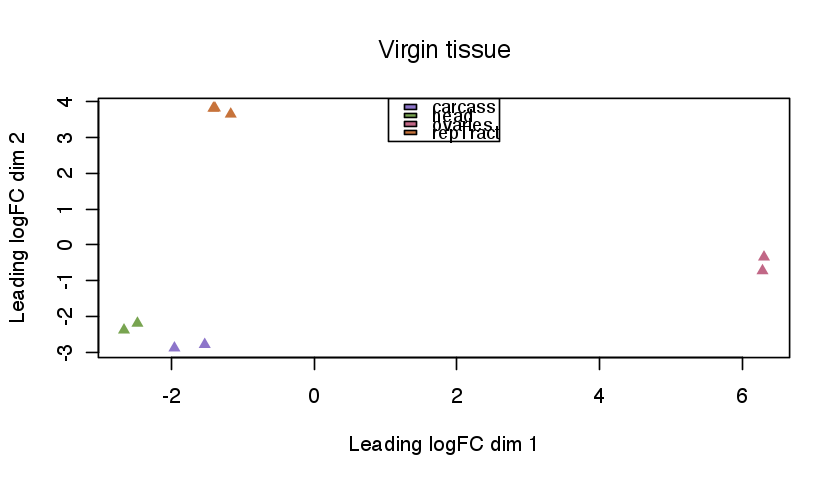

In [84]:
## colour samples by tissue-type
col.tissue <- c("#8d75ca","#78a450","#c16786","#c7733b")[sampleInfo.v$Tissue]
options(repr.plot.width = 7, repr.plot.height = 4)
plotMDS(dgeList.v, col=col.tissue, pch= 17, cex = 1)
legend("top",fill=c("#8d75ca","#78a450","#c16786","#c7733b"),legend=levels(sampleInfo.v$Tissue), cex = 0.85)
# Add a title
title("Virgin tissue")

Samples are grouping correctly, although the head and carcass samples appear to be fairly similar. Another way to look at grouping is by looking at sample correlations:

for plotting:: min.raw: 0.215679189957847 max.raw: 1


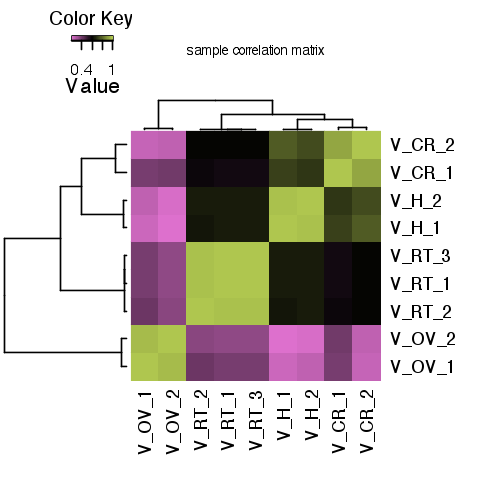

In [85]:
## Plot sample correlation
data = log2(countsMatrix.virgin.filt+1)
data = as.matrix(data)
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')

options(repr.plot.width = 4, repr.plot.height = 4)
heatmap.3(sample_cor, dendrogram='both', Rowv=as.dendrogram(hc_samples), Colv=as.dendrogram(hc_samples), col = colorpanel(75, '#dd70cd','black','#afc64f'), scale='none', symm=TRUE, key=TRUE,density.info='none', trace='none', symkey=FALSE, symbreaks=F, cexCol=1, cexRow=1, cex.main=0.75, main=paste("sample correlation matrix"))

Finally, let's compare replicates within each sample using MA plots:

Warning message:
"Removed 9 rows containing missing values (position_stack)."Warning message:
"Removed 6 rows containing missing values (geom_point)."

Warning message:
"Removed 12 rows containing missing values (position_stack)."Warning message:
"Removed 31 rows containing missing values (geom_point)."

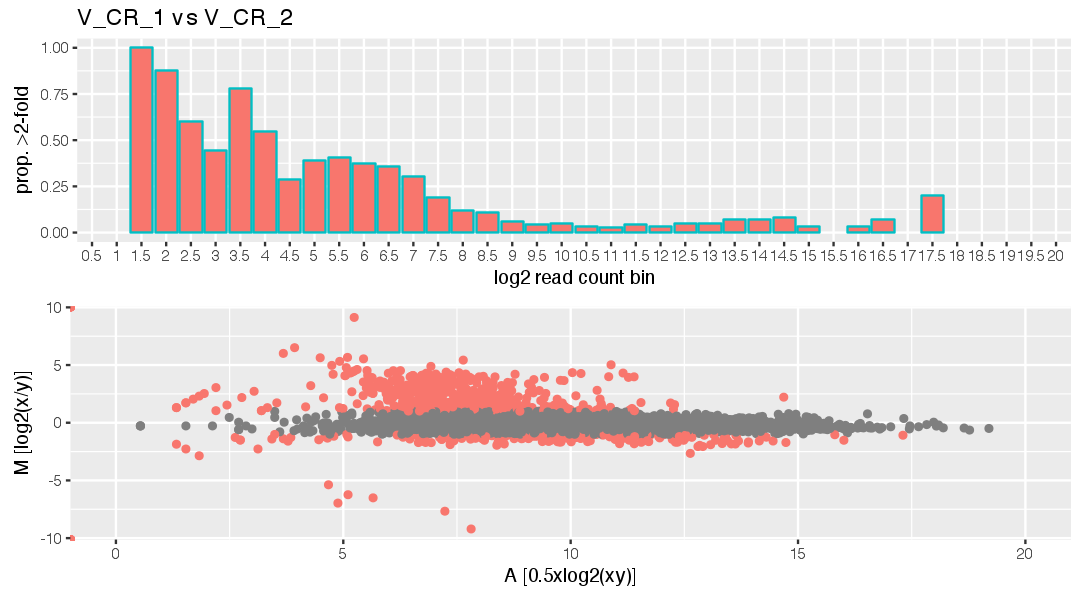

Warning message:
"Removed 10 rows containing missing values (position_stack)."Warning message:
"Removed 184 rows containing missing values (geom_point)."

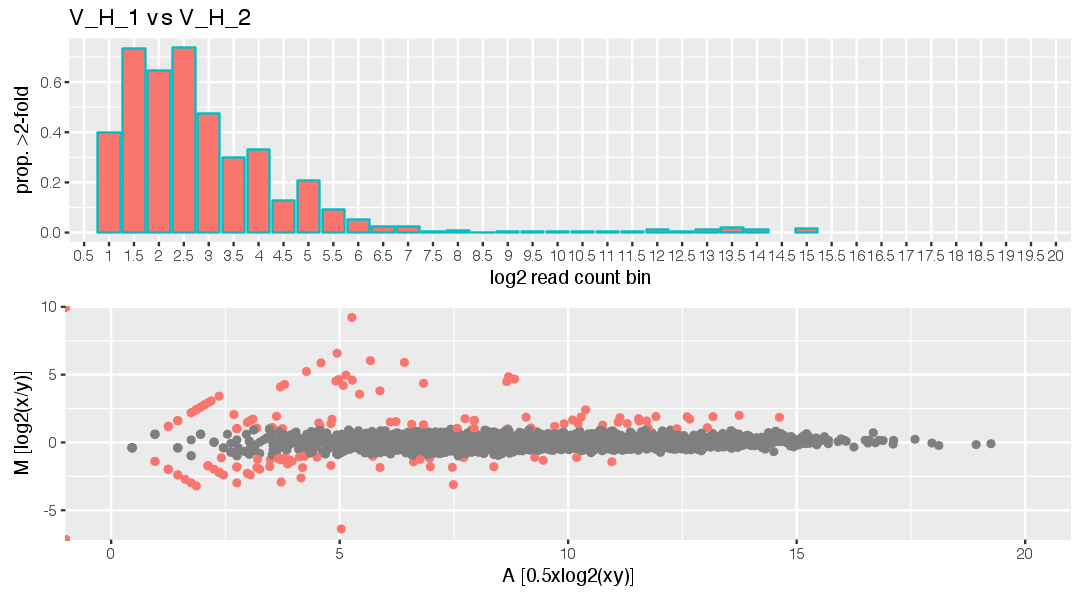

Warning message:
"Removed 15 rows containing missing values (position_stack)."Warning message:
"Removed 55 rows containing missing values (geom_point)."

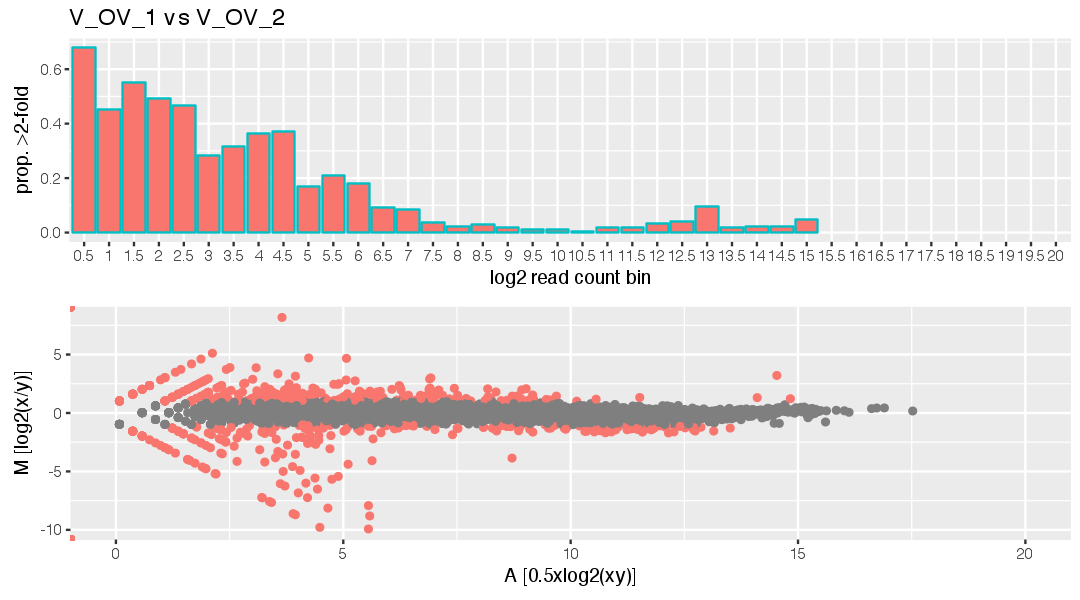

Warning message:
"Removed 15 rows containing missing values (position_stack)."Warning message:
"Removed 77 rows containing missing values (geom_point)."

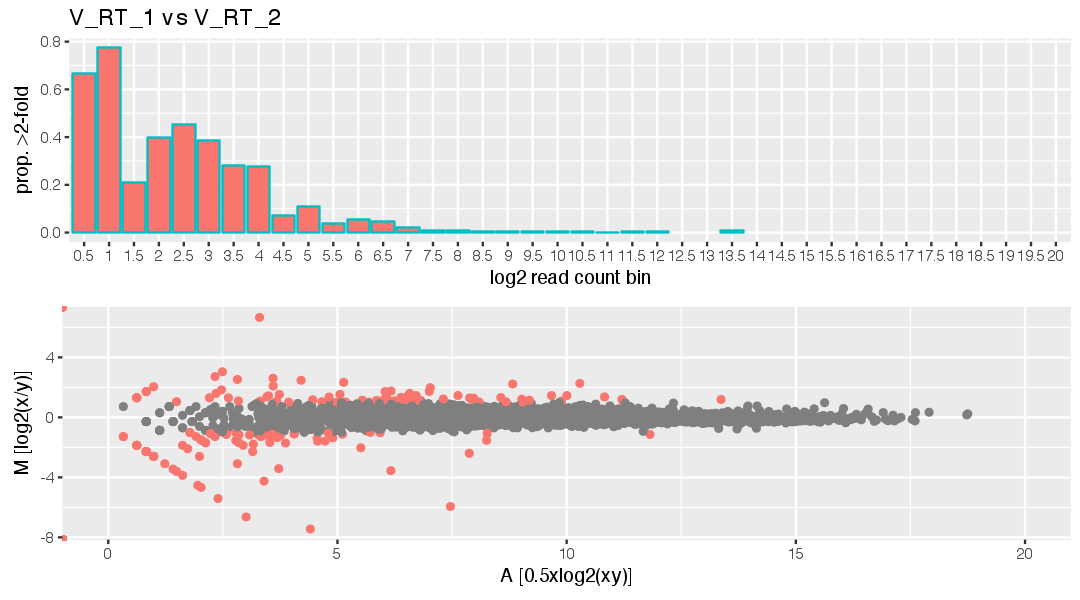

Warning message:
"Removed 17 rows containing missing values (position_stack)."Warning message:
"Removed 56 rows containing missing values (geom_point)."

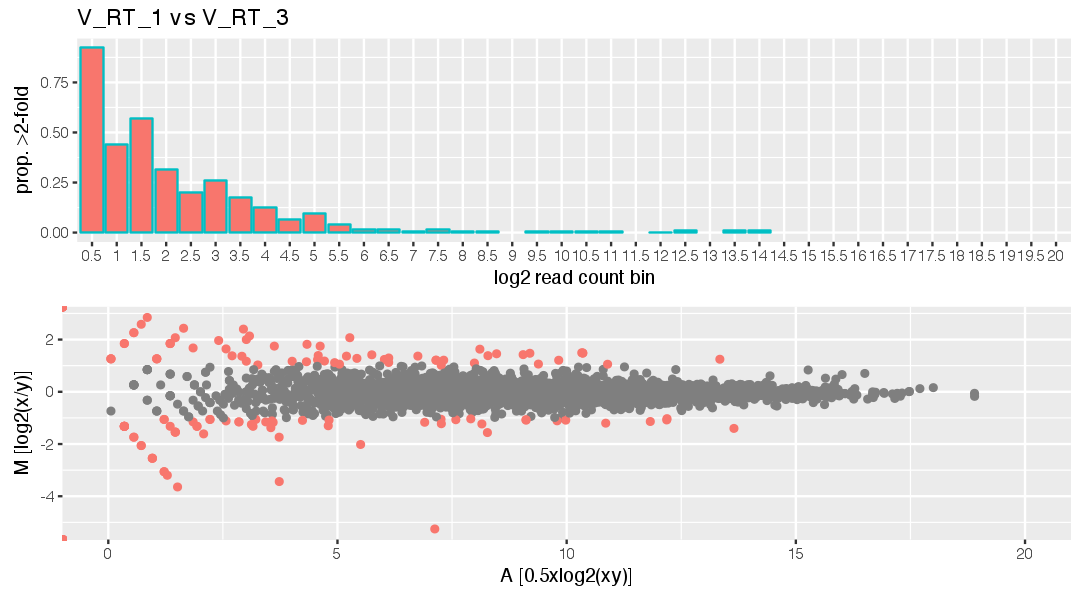

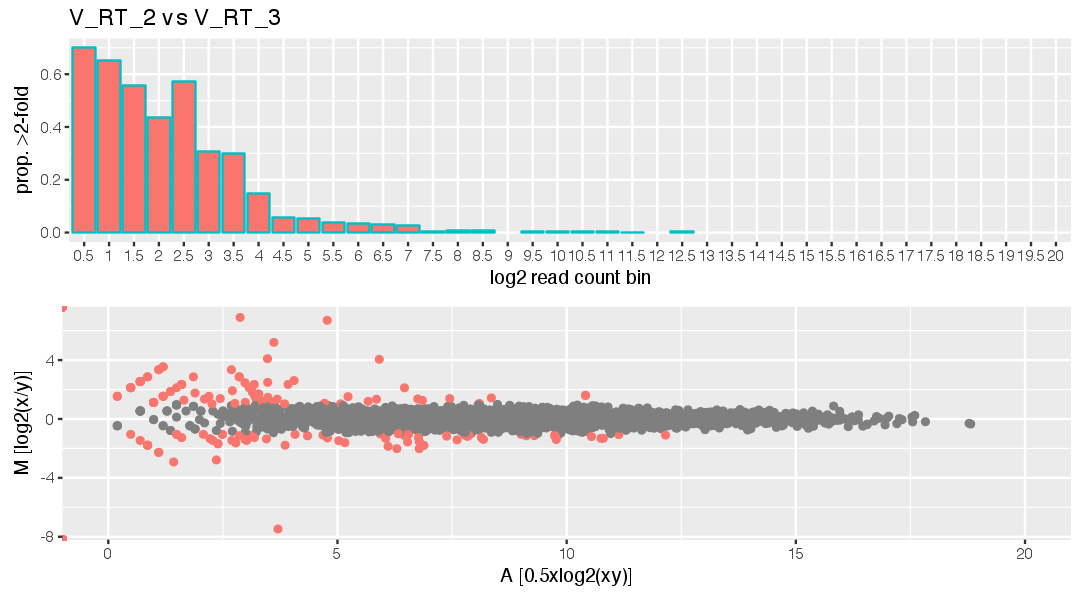

In [34]:
# normalize counts by the DESeq method (this is only used for these plots:
meta.v <- data.frame(row.names=colnames(countsMatrix.virgin.filt), condition=sampleInfo.v$Tissue)
countData.v<-round(countsMatrix.virgin.filt)
countData.v_normByDESeq = newCountDataSet(countData.v, meta.v)
countData.v_normByDESeq = estimateSizeFactors(countData.v_normByDESeq)
countData.v_normByDESeq = data.frame(counts(countData.v_normByDESeq, normalized=T))

options(repr.plot.width = 9, repr.plot.height = 5)
MA_BPlot(countData.v_normByDESeq, "V_CR_1", "V_CR_2")
MA_BPlot(countData.v_normByDESeq, "V_H_1", "V_H_2")
MA_BPlot(countData.v_normByDESeq, "V_OV_1", "V_OV_2")
MA_BPlot(countData.v_normByDESeq, "V_RT_1", "V_RT_2")
MA_BPlot(countData.v_normByDESeq, "V_RT_1", "V_RT_3")
MA_BPlot(countData.v_normByDESeq, "V_RT_2", "V_RT_3")

Now we can identify genes that show tissue-biased expression. First, we define the relevant contrasts. We'll need to define a set of three contrasts for each tissue:

In [86]:
cont.v.repTract <- makeContrasts(V_RT.vs.V_CR=repTract-carcass,
                                 V_RT.vs.V_HD=repTract-head,
                                 V_RT.vs.V_OV=repTract-ovaries,
                                 levels=design.v)
cont.v.ovaries <- makeContrasts(V_OV.vs.V_CR=ovaries-carcass,
                                V_OV.vs.V_HD=ovaries-head,
                                V_OV.vs.V_RT=ovaries-repTract,
                                levels=design.v)
cont.v.head <- makeContrasts(V_H.vs.V_CR=head-carcass,
                             V_H.vs.V_OV=head-ovaries,
                             V_H.vs.V_RT=head-repTract,
                             levels=design.v)

Now we can fit the negative binomial log-linear model to conduct gene-wise statistical tests. For each contrast, we will extract the table with the relevant DE stats.

###### Reproductive tract:

In [87]:
lrt.v.repTract <- glmLRT(dgeList.v_fit, contrast = cont.v.repTract)
lrt.v.repTract.tTags <- topTags(lrt.v.repTract, n = NULL)
lrt.v.repTract.tTags.table <- lrt.v.repTract.tTags$table
repTract.list<-rownames(subset(lrt.v.repTract.tTags.table, logFC.V_RT.vs.V_CR > 2 & logFC.V_RT.vs.V_HD > 2 & logFC.V_RT.vs.V_OV > 2 & FDR<0.001))
length(repTract.list)

[1] 263

##### Ovaries:

In [88]:
topTags(lrt.v.repTract)

,FBgn_ID,gene_name,SwissProt_BlastX_Description,logFC.V_RT.vs.V_CR,logFC.V_RT.vs.V_HD,logFC.V_RT.vs.V_OV,logCPM,LR,PValue,FDR
NA.71,NA,NA,NA,17.13546,20.91091,16.91645,11.962427,2342.888,0,0
7039,FBgn0282566,GJ26297,Collagenase,15.88683,14.99110,16.59665,11.041991,2103.295,0,0
NA.246,NA,NA,NA,15.51632,15.51632,15.51632,6.574363,1804.216,0,0
5359,FBgn0208695,GJ21575,Trypsin epsilon,15.04328,16.57057,17.13029,10.668583,2014.518,0,0
NA.1214,NA,NA,NA,15.02306,15.03956,20.61957,11.671163,1555.868,0,0
NA.388,NA,NA,NA,15.02064,18.26243,14.85952,9.314852,1921.859,0,0
NA.353,NA,NA,NA,14.78647,14.67641,16.11846,11.251055,2008.757,0,0
NA.527,NA,NA,NA,14.68007,14.68007,14.68007,5.743186,1675.579,0,0
1052,FBgn0199434,GJ12182,Trypsin 3A1,14.40101,15.65746,17.14720,10.508859,1951.216,0,0
NA.490,NA,NA,NA,14.09276,14.15444,17.39638,8.449658,1848.492,0,0


In [89]:
lrt.v.ovaries <- glmLRT(dgeList.v_fit, contrast = cont.v.ovaries)
lrt.v.ovaries.tTags <- topTags(lrt.v.ovaries, n = NULL)
lrt.v.ovaries.tTags.table <- lrt.v.ovaries.tTags$table
ovaries.list<-rownames(subset(lrt.v.ovaries.tTags.table, logFC.V_OV.vs.V_CR > 2 & logFC.V_OV.vs.V_HD > 2 & logFC.V_OV.vs.V_RT > 2 & FDR<0.001))
length(ovaries.list)

[1] 560

##### Head:

In [90]:
lrt.v.head <- glmLRT(dgeList.v_fit, contrast = cont.v.head)
lrt.v.head.tTags <- topTags(lrt.v.head, n = NULL)
lrt.v.head.tTags.table <- lrt.v.head.tTags$table
head.list<-rownames(subset(lrt.v.head.tTags.table, logFC.V_H.vs.V_CR > 2 & logFC.V_H.vs.V_OV > 2 & logFC.V_H.vs.V_RT > 2 & FDR<0.001))
length(head.list)

[1] 264

In [58]:
labels <- paste(sampleinfo$SampleName, sampleinfo$CellType, sampleinfo$Status)
group <- paste(sampleinfo$CellType,sampleinfo$Status,sep=".")
group <- factor(group)
glMDSPlot(y, labels=labels, groups=group, folder="mds")

In [63]:
head(annot.sum)

FBgn_ID,gene_name,SwissProt_BlastX_Description
FBgn0015205,140up,RPII140-upstream gene protein
FBgn0026096,Aats-tyr,"Tyrosine--tRNA ligase, cytoplasmic"
FBgn0016478,abd-A,Homeobox protein abdominal-A
FBgn0013102,ac,Achaete-scute complex protein T5
FBgn0199916,Acp65A,Endocuticle structural protein SgAbd-6
FBgn0023233,Acph,Prostatic acid phosphatase


In [66]:
rownames(dgeList.v_fit)

[1] "FBgn0202928" "FBgn0199563" "FBgn0206588" "FBgn0209112" "FBgn0199619"
   [6] "FBgn0198240" "FBgn0204214" "FBgn0205669" "FBgn0209018" "FBgn0204829"
  [11] "FBgn0211158" "FBgn0210215" "FBgn0207350" "FBgn0202094" "FBgn0200177"
  [16] "FBgn0204239" "FBgn0210786" "FBgn0197431" "FBgn0207363" "FBgn0206592"
  [21] "FBgn0282919" "FBgn0015214" "FBgn0199963" "FBgn0209419" "FBgn0210577"
  [26] "FBgn0200112" "FBgn0203463" "FBgn0211082" "FBgn0207216" "FBgn0210295"
  [31] "FBgn0207785" "FBgn0197497" "FBgn0203413" "FBgn0203073" "FBgn0200797"
  [36] "FBgn0199547" "FBgn0201000" "FBgn0210395" "FBgn0211324" "FBgn0197473"
  [41] "FBgn0208125" "FBgn0197780" "FBgn0211765" "FBgn0210370" "FBgn0209921"
  [46] "FBgn0211145" "FBgn0209341" "FBgn0210667" "FBgn0198327" "FBgn0209057"
  [51] "FBgn0281932" "FBgn0202859" "FBgn0202260" "FBgn0197860" "FBgn0210073"
  [56] "FBgn0283187" "FBgn0211056" "FBgn0205815" "FBgn0199782" "FBgn0201677"
  [61] "FBgn0202399" "FBgn0282388" "FBgn0208485" "FBgn0201944" "FBgn0202519"
  [66] "FBgn0210724" "FBgn0210434" "FBgn0201994" "FBgn0282105" "FBgn0203095"
  [71] "FBgn0201724" "FBgn0202393" "FBgn0210871" "FBgn0282576" "FBgn0205491"
  [76] "FBgn0208299" "FBgn0208363" "FBgn0204655" "FBgn0204797" "FBgn0207183"
  [81] "FBgn0205248" "FBgn0207424" "FBgn0028438" "FBgn0205398" "FBgn0200503"
  [86] "FBgn0198083" "FBgn0211656" "FBgn0210267" "FBgn0199821" "FBgn0066145"
  [91] "FBgn0209747" "FBgn0197532" "FBgn0204696" "FBgn0199008" "FBgn0211680"
  [96] "FBgn0282697" "FBgn0208919" "FBgn0281877" "FBgn0201871" "FBgn0207663"
 [101] "FBgn0209100" "FBgn0197824" "FBgn0199927" "FBgn0211501" "FBgn0200976"
 [106] "FBgn0208834" "FBgn0201003" "FBgn0199589" "FBgn0211341" "FBgn0211263"
 [111] "FBgn0200436" "FBgn0199627" "FBgn0209493" "FBgn0283126" "FBgn0205756"
 [116] "FBgn0209651" "FBgn0205362" "FBgn0204408" "FBgn0206687" "FBgn0209852"
 [121] "FBgn0204740" "FBgn0211674" "FBgn0207217" "FBgn0199117" "FBgn0197612"
 [126] "FBgn0207229" "FBgn0202516" "FBgn0208360" "FBgn0203074" "FBgn0202576"
 [131] "FBgn0203220" "FBgn0201395" "FBgn0201592" "FBgn0283011" "FBgn0199480"
 [136] "FBgn0204555" "FBgn0207387" "FBgn0208717" "FBgn0198754" "FBgn0198592"
 [141] "FBgn0204702" "FBgn0209724" "FBgn0208894" "FBgn0204936" "FBgn0283283"
 [146] "FBgn0200428" "FBgn0211038" "FBgn0200453" "FBgn0209562" "FBgn0204681"
 [151] "FBgn0206606" "FBgn0205667" "FBgn0209858" "FBgn0282420" "FBgn0205244"
 [156] "FBgn0206576" "FBgn0205492" "FBgn0207191" "FBgn0207329" "FBgn0013913"
 [161] "FBgn0208931" "FBgn0202327" "FBgn0199420" "FBgn0282262" "FBgn0013912"
 [166] "FBgn0205560" "FBgn0282914" "FBgn0210940" "FBgn0209347" "FBgn0198308"
 [171] "FBgn0208434" "FBgn0282059" "FBgn0199337" "FBgn0203612" "FBgn0209019"
 [176] "FBgn0283045" "FBgn0203874" "FBgn0208828" "FBgn0197418" "FBgn0205531"
 [181] "FBgn0022839" "FBgn0206046" "FBgn0204729" "FBgn0202953" "FBgn0204233"
 [186] "FBgn0210312" "FBgn0211233" "FBgn0210159" "FBgn0201671" "FBgn0201448"
 [191] "FBgn0207066" "FBgn0210175" "FBgn0207940" "FBgn0201014" "FBgn0210385"
 [196] "FBgn0210541" "FBgn0203851" "FBgn0210412" "FBgn0208699" "FBgn0210571"
 [201] "FBgn0209023" "FBgn0210194" "FBgn0197841" "FBgn0203116" "FBgn0211449"
 [206] "FBgn0201358" "FBgn0210323" "FBgn0202008" "FBgn0211766" "FBgn0200409"
 [211] "FBgn0204453" "FBgn0211432" "FBgn0200704" "FBgn0206119" "FBgn0199183"
 [216] "FBgn0211149" "FBgn0282055" "FBgn0208094" "FBgn0201246" "FBgn0209503"
 [221] "FBgn0281997" "FBgn0201321" "FBgn0204356" "FBgn0208232" "FBgn0209009"
 [226] "FBgn0204531" "FBgn0204697" "FBgn0207922" "FBgn0211268" "FBgn0205814"
 [231] "FBgn0208487" "FBgn0211570" "FBgn0199623" "FBgn0208548" "FBgn0207810"
 [236] "FBgn0202929" "FBgn0200276" "FBgn0210047" "FBgn0204519" "FBgn0211434"
 [241] "FBgn0206906" "FBgn0201620" "FBgn0203587" "FBgn0201399" "FBgn0198591"
 [246] "FBgn0208242" "FBgn0202555" "FBgn0211106" "FBgn0205739" "FBgn0205125"
 [251] "FBgn0198807" "FBgn0200508" "FBgn0198499" "FBgn0205494" "FBgn0210572"
 [256] "FBgn0211453" "FBgn0208081" "FBgn0202023" "FBgn0202230" "FBgn0200402"

In [67]:
select(as.data.frame(annot.sum), keys=rownames(dgeList.v_fit), columns = c("FBgn_ID", "gene_name", "SwissProt_BlastX_Description"))

ERROR: Error: Strings must match column names. Unknown columns: FBgn0202928, FBgn0199563, FBgn0206588, FBgn0209112, FBgn0199619, FBgn0198240, FBgn0204214, FBgn0205669, FBgn0209018, FBgn0204829, FBgn0211158, FBgn0210215, FBgn0207350, FBgn0202094, FBgn0200177, FBgn0204239, FBgn0210786, FBgn0197431, FBgn0207363, FBgn0206592, FBgn0282919, FBgn0015214, FBgn0199963, FBgn0209419, FBgn0210577, FBgn0200112, FBgn0203463, FBgn0211082, FBgn0207216, FBgn0210295, FBgn0207785, FBgn0197497, FBgn0203413, FBgn0203073, FBgn0200797, FBgn0199547, FBgn0201000, FBgn0210395, FBgn0211324, FBgn0197473, FBgn0208125, FBgn0197780, FBgn0211765, FBgn0210370, FBgn0209921, FBgn0211145, FBgn0209341, FBgn0210667, FBgn0198327, FBgn0209057, FBgn0281932, FBgn0202859, FBgn0202260, FBgn0197860, FBgn0210073, FBgn0283187, FBgn0211056, FBgn0205815, FBgn0199782, FBgn0201677, FBgn0202399, FBgn0282388, FBgn0208485, FBgn0201944, FBgn0202519, FBgn0210724, FBgn0210434, FBgn0201994, FBgn0282105, FBgn0203095, FBgn0201724, FBgn0202393, FBgn0210871, FBgn0282576, FBgn0205491, FBgn0208299, FBgn0208363, FBgn0204655, FBgn0204797, FBgn0207183, FBgn0205248, FBgn0207424, FBgn0028438, FBgn0205398, FBgn0200503, FBgn0198083, FBgn0211656, FBgn0210267, FBgn0199821, FBgn0066145, FBgn0209747, FBgn0197532, FBgn0204696, FBgn0199008, FBgn0211680, FBgn0282697, FBgn0208919, FBgn0281877, FBgn0201871, FBgn0207663, FBgn0209100, FBgn0197824, FBgn0199927, FBgn0211501, FBgn0200976, FBgn0208834, FBgn0201003, FBgn0199589, FBgn0211341, FBgn0211263, FBgn0200436, FBgn0199627, FBgn0209493, FBgn0283126, FBgn0205756, FBgn0209651, FBgn0205362, FBgn0204408, FBgn0206687, FBgn0209852, FBgn0204740, FBgn0211674, FBgn0207217, FBgn0199117, FBgn0197612, FBgn0207229, FBgn0202516, FBgn0208360, FBgn0203074, FBgn0202576, FBgn0203220, FBgn0201395, FBgn0201592, FBgn0283011, FBgn0199480, FBgn0204555, FBgn0207387, FBgn0208717, FBgn0198754, FBgn0198592, FBgn0204702, FBgn0209724, FBgn0208894, FBgn0204936, FBgn0283283, FBgn0200428, FBgn0211038, FBgn0200453, FBgn0209562, FBgn0204681, FBgn0206606, FBgn0205667, FBgn0209858, FBgn0282420, FBgn0205244, FBgn0206576, FBgn0205492, FBgn0207191, FBgn0207329, FBgn0013913, FBgn0208931, FBgn0202327, FBgn0199420, FBgn0282262, FBgn0013912, FBgn0205560, FBgn0282914, FBgn0210940, FBgn0209347, FBgn0198308, FBgn0208434, FBgn0282059, FBgn0199337, FBgn0203612, FBgn0209019, FBgn0283045, FBgn0203874, FBgn0208828, FBgn0197418, FBgn0205531, FBgn0022839, FBgn0206046, FBgn0204729, FBgn0202953, FBgn0204233, FBgn0210312, FBgn0211233, FBgn0210159, FBgn0201671, FBgn0201448, FBgn0207066, FBgn0210175, FBgn0207940, FBgn0201014, FBgn0210385, FBgn0210541, FBgn0203851, FBgn0210412, FBgn0208699, FBgn0210571, FBgn0209023, FBgn0210194, FBgn0197841, FBgn0203116, FBgn0211449, FBgn0201358, FBgn0210323, FBgn0202008, FBgn0211766, FBgn0200409, FBgn0204453, FBgn0211432, FBgn0200704, FBgn0206119, FBgn0199183, FBgn0211149, FBgn0282055, FBgn0208094, FBgn0201246, FBgn0209503, FBgn0281997, FBgn0201321, FBgn0204356, FBgn0208232, FBgn0209009, FBgn0204531, FBgn0204697, FBgn0207922, FBgn0211268, FBgn0205814, FBgn0208487, FBgn0211570, FBgn0199623, FBgn0208548, FBgn0207810, FBgn0202929, FBgn0200276, FBgn0210047, FBgn0204519, FBgn0211434, FBgn0206906, FBgn0201620, FBgn0203587, FBgn0201399, FBgn0198591, FBgn0208242, FBgn0202555, FBgn0211106, FBgn0205739, FBgn0205125, FBgn0198807, FBgn0200508, FBgn0198499, FBgn0205494, FBgn0210572, FBgn0211453, FBgn0208081, FBgn0202023, FBgn0202230, FBgn0200402, FBgn0210345, FBgn0211509, FBgn0208806, FBgn0209042, FBgn0198869, FBgn0204054, FBgn0199067, FBgn0202956, FBgn0201452, FBgn0208310, FBgn0205715, FBgn0210502, FBgn0204146, FBgn0211462, FBgn0202170, FBgn0200435, FBgn0209363, FBgn0201383, FBgn0207455, FBgn0204132, FBgn0200782, FBgn0201423, FBgn0282502, FBgn0206974, FBgn0202517, FBgn0208455, FBgn0201293, FBgn0202645, FBgn0207071, FBgn0201911, FBgn0283023, FBgn0204846, FBgn0206978, FBgn0198605, FBgn0067466, FBgn0205484, FBgn0198631, FBgn0206309, FBgn0209887, FBgn0204757, FBgn0209151, FBgn0209492, FBgn0207147, FBgn0199373, FBgn0206829, FBgn0208695, FBgn0203670, FBgn0200096, FBgn0200182, FBgn0209751, FBgn0209755, FBgn0205884, FBgn0200456, FBgn0199424, FBgn0202281, FBgn0202950, FBgn0206230, FBgn0197683, FBgn0197836, FBgn0207740, FBgn0210651, FBgn0209035, FBgn0206288, FBgn0203122, FBgn0200491, FBgn0202361, FBgn0210569, FBgn0209849, FBgn0198927, FBgn0211156, FBgn0200171, FBgn0199658, FBgn0282827, FBgn0204850, FBgn0197982, FBgn0206321, FBgn0203247, FBgn0205393, FBgn0199625, FBgn0197413, FBgn0201176, FBgn0208547, FBgn0205282, FBgn0209679, FBgn0201289, FBgn0203882, FBgn0211262, FBgn0205636, FBgn0206082, FBgn0200149, FBgn0199338, FBgn0208680, FBgn0202320, FBgn0207604, FBgn0201652, FBgn0204380, FBgn0205418, FBgn0210942, FBgn0202375, FBgn0283385, FBgn0209092, FBgn0207457, FBgn0203490, FBgn0210986, FBgn0210823, FBgn0013066, FBgn0203209, FBgn0203667, FBgn0209847, FBgn0201824, FBgn0283327, FBgn0197898, FBgn0201626, FBgn0200454, FBgn0197451, FBgn0198632, FBgn0200328, FBgn0203133, FBgn0205653, FBgn0203903, FBgn0201019, FBgn0207085, FBgn0206241, FBgn0206487, FBgn0208296, FBgn0208826, FBgn0208848, FBgn0201251, FBgn0205174, FBgn0282588, FBgn0205358, FBgn0204752, FBgn0202284, FBgn0204839, FBgn0205671, FBgn0210852, FBgn0203924, FBgn0210013, FBgn0202665, FBgn0205854, FBgn0205817, FBgn0283064, FBgn0209948, FBgn0204712, FBgn0198540, FBgn0211740, FBgn0205759, FBgn0206047, FBgn0207398, FBgn0206027, FBgn0201119, FBgn0204682, FBgn0201207, FBgn0204941, FBgn0207626, FBgn0197745, FBgn0206414, FBgn0204498, FBgn0209211, FBgn0211169, FBgn0201509, FBgn0201057, FBgn0198151, FBgn0205071, FBgn0198200, FBgn0198075, FBgn0209582, FBgn0210121, FBgn0282192, FBgn0210011, FBgn0206156, FBgn0202503, FBgn0199294, FBgn0208921, FBgn0202511, FBgn0198584, FBgn0205825, FBgn0209197, FBgn0205704, FBgn0204848, FBgn0200581, FBgn0208989, FBgn0207522, FBgn0203852, FBgn0208981, FBgn0206770, FBgn0205169, FBgn0203510, FBgn0201104, FBgn0204669, FBgn0203337, FBgn0201502, FBgn0026093, FBgn0210635, FBgn0208753, FBgn0211685, FBgn0211630, FBgn0208373, FBgn0198042, FBgn0204720, FBgn0207860, FBgn0205925, FBgn0209687, FBgn0210951, FBgn0197856, FBgn0201185, FBgn0209358, FBgn0201163, FBgn0209710, FBgn0200260, FBgn0197678, FBgn0022424, FBgn0209547, FBgn0207531, FBgn0209176, FBgn0200804, FBgn0205142, FBgn0211728, FBgn0282172, FBgn0203451, FBgn0197417, FBgn0197633, FBgn0204817, FBgn0205965, FBgn0202218, FBgn0204782, FBgn0211007, FBgn0204883, FBgn0205935, FBgn0205316, FBgn0201654, FBgn0207979, FBgn0200764, FBgn0204661, FBgn0202997, FBgn0204176, FBgn0207569, FBgn0209346, FBgn0198757, FBgn0211465, FBgn0211159, FBgn0199970, FBgn0208541, FBgn0206442, FBgn0199716, FBgn0210928, FBgn0201763, FBgn0205173, FBgn0206998, FBgn0207058, FBgn0204904, FBgn0208775, FBgn0203270, FBgn0201490, FBgn0200330, FBgn0210422, FBgn0203347, FBgn0206193, FBgn0205969, FBgn0208986, FBgn0210128, FBgn0201353, FBgn0209080, FBgn0202024, FBgn0205349, FBgn0199013, FBgn0211128, FBgn0210231, FBgn0202493, FBgn0209353, FBgn0200773, FBgn0210660, FBgn0211393, FBgn0209658, FBgn0041649, FBgn0204245, FBgn0205118, FBgn0207049, FBgn0204527, FBgn0205609, FBgn0211202, FBgn0207312, FBgn0211359, FBgn0205593, FBgn0209357, FBgn0198749, FBgn0205449, FBgn0211033, FBgn0211133, FBgn0202014, FBgn0203557, FBgn0201137, FBgn0203946, FBgn0209994, FBgn0209277, FBgn0207091, FBgn0210181, FBgn0205850, FBgn0203827, FBgn0282022, FBgn0205384, FBgn0197685, FBgn0198209, FBgn0207496, FBgn0208936, FBgn0205425, FBgn0206042, FBgn0204030, FBgn0209386, FBgn0041650, FBgn0207222, FBgn0204342, FBgn0199110, FBgn0205258, FBgn0197942, FBgn0206454, FBgn0202237, FBgn0211258, FBgn0201661, FBgn0197679, FBgn0210066, FBgn0198030, FBgn0208698, FBgn0205350, FBgn0198117, FBgn0209142, FBgn0208307, FBgn0282679, FBgn0209150, FBgn0200645, FBgn0200088, FBgn0202845, FBgn0199066, FBgn0203276, FBgn0198173, FBgn0283397, FBgn0203575, FBgn0069459, FBgn0208510, FBgn0013137, FBgn0199223, FBgn0203352, FBgn0199034, FBgn0203686, FBgn0209989, FBgn0201457, FBgn0210432, FBgn0205447, FBgn0198003, FBgn0209897, FBgn0207215, FBgn0208430, FBgn0209224, FBgn0199083, FBgn0205417, FBgn0197755, FBgn0198005, FBgn0209439, FBgn0205396, FBgn0206333, FBgn0203183, FBgn0208886, FBgn0210944, FBgn0211435, FBgn0206370, FBgn0206608, FBgn0200079, FBgn0204693, FBgn0206822, FBgn0013918, FBgn0211799, FBgn0208155, FBgn0206357, FBgn0203989, FBgn0200654, FBgn0208376, FBgn0203886, FBgn0204377, FBgn0204793, FBgn0211193, FBgn0200803, FBgn0207108, FBgn0210653, FBgn0207203, FBgn0207895, FBgn0207379, FBgn0199410, FBgn0282268, FBgn0204025, FBgn0210255, FBgn0207525, FBgn0208411, FBgn0202233, FBgn0206312, FBgn0202442, FBgn0202160, FBgn0199192, FBgn0204683, FBgn0199213, FBgn0199048, FBgn0202324, FBgn0203256, FBgn0201138, FBgn0204898, FBgn0206365, FBgn0204905, FBgn0205639, FBgn0201812, FBgn0209205, FBgn0203488, FBgn0203033, FBgn0202600, FBgn0200653, FBgn0201977, FBgn0210904, FBgn0210090, FBgn0209878, FBgn0283424, FBgn0206313, FBgn0202964, FBgn0199265, FBgn0200412, FBgn0206506, FBgn0203688, FBgn0209914, FBgn0203977, FBgn0204158, FBgn0014844, FBgn0200451, FBgn0207482, FBgn0204034, FBgn0201760, FBgn0013104, FBgn0205892, FBgn0209788, FBgn0211605, FBgn0203622, FBgn0206559, FBgn0209437, FBgn0205389, FBgn0205870, FBgn0209791, FBgn0210778, FBgn0205929, FBgn0204037, FBgn0201371, FBgn0208185, FBgn0202774, FBgn0282592, FBgn0198227, FBgn0200497, FBgn0208513, FBgn0198072, FBgn0201749, FBgn0206227, FBgn0210810, FBgn0201376, FBgn0207893, FBgn0198603, FBgn0209854, FBgn0198963, FBgn0206551, FBgn0207581, FBgn0013115, FBgn0199138, FBgn0204653, FBgn0207294, FBgn0197979, FBgn0206823, FBgn0200280, FBgn0207200, FBgn0202003, FBgn0209998, FBgn0203577, FBgn0202965, FBgn0209912, FBgn0210030, FBgn0200836, FBgn0206671, FBgn0204638, FBgn0202209, FBgn0210429, FBgn0204013, FBgn0202082, FBgn0198702, FBgn0198064, FBgn0205371, FBgn0198367, FBgn0205499, FBgn0197970, FBgn0201412, FBgn0204501, FBgn0202012, FBgn0200634, FBgn0203214, FBgn0283047, FBgn0208202, FBgn0201102, FBgn0204742, FBgn0208014, FBgn0209326, FBgn0209295, FBgn0200554, FBgn0206297, FBgn0210114, FBgn0210132, FBgn0198267, FBgn0210260, FBgn0208026, FBgn0210620, FBgn0199951, FBgn0211004, FBgn0210077, FBgn0203494, FBgn0197553, FBgn0211061, FBgn0208036, FBgn0199369, FBgn0206725, FBgn0210048, FBgn0209377, FBgn0201990, FBgn0201375, FBgn0199444, FBgn0209668, FBgn0200097, FBgn0210736, FBgn0200336, FBgn0210824, FBgn0205983, FBgn0205264, FBgn0201441, FBgn0204387, FBgn0204117, FBgn0198027, FBgn0211642, FBgn0205112, FBgn0204350, FBgn0210559, FBgn0210482, FBgn0204711, FBgn0206656, FBgn0197387, FBgn0200345, FBgn0203650, FBgn0208378, FBgn0198040, FBgn0206468, FBgn0201864, FBgn0013080, FBgn0211173, FBgn0209495, FBgn0204621, FBgn0211306, FBgn0197912, FBgn0282249, FBgn0204012, FBgn0199417, FBgn0205962, FBgn0205985, FBgn0206595, FBgn0199123, FBgn0206101, FBgn0197464, FBgn0210489, FBgn0206498, FBgn0208659, FBgn0200743, FBgn0201851, FBgn0197735, FBgn0209420, FBgn0201828, FBgn0282775, FBgn0200635, FBgn0209220, FBgn0207854, FBgn0197812, FBgn0200637, FBgn0208642, FBgn0203480, FBgn0209395, FBgn0207982, FBgn0200547, FBgn0209392, FBgn0209530, FBgn0202022, FBgn0201305, FBgn0206304, FBgn0211689, FBgn0201676, FBgn0067461, FBgn0204004, FBgn0205136, FBgn0199936, FBgn0209909, FBgn0200361, FBgn0205069, FBgn0197692, FBgn0202087, FBgn0207776, FBgn0205801, FBgn0207570, FBgn0207254, FBgn0197703, FBgn0208777, FBgn0211152, FBgn0203697, FBgn0203001, FBgn0203021, FBgn0208002, FBgn0207453, FBgn0206048, FBgn0198114, FBgn0282570, FBgn0203945, FBgn0208237, FBgn0203527, FBgn0198762, FBgn0202291, FBgn0198145, FBgn0203722, FBgn0208263, FBgn0203576, FBgn0197922, FBgn0197581, FBgn0205063, FBgn0207884, FBgn0206125, FBgn0210919, FBgn0199982, FBgn0210860, FBgn0200109, FBgn0282112, FBgn0210171, FBgn0022427, FBgn0205672, FBgn0205085, FBgn0208410, FBgn0207813, FBgn0201680, FBgn0208474, FBgn0203011, FBgn0197489, FBgn0206912, FBgn0200305, FBgn0209335, FBgn0205191, FBgn0211070, FBgn0208336, FBgn0205157, FBgn0205451, FBgn0211198, FBgn0200791, FBgn0210722, FBgn0209549, FBgn0203832, FBgn0206043, FBgn0210108, FBgn0205628, FBgn0199822, FBgn0198735, FBgn0197611, FBgn0204853, FBgn0199156, FBgn0206616, FBgn0209418, FBgn0207221, FBgn0211628, FBgn0282512, FBgn0200496, FBgn0201092, FBgn0202799, FBgn0198264, FBgn0200830, FBgn0202045, FBgn0202115, FBgn0204758, FBgn0200208, FBgn0204218, FBgn0197446, FBgn0211471, FBgn0208165, FBgn0200536, FBgn0198048, FBgn0205475, FBgn0204932, FBgn0199689, FBgn0209945, FBgn0199208, FBgn0209778, FBgn0210939, FBgn0207712, FBgn0197798, FBgn0200091, FBgn0203911, FBgn0206436, FBgn0204430, FBgn0202724, FBgn0208678, FBgn0203580, FBgn0203232, FBgn0201987, FBgn0209568, FBgn0198310, FBgn0202249, FBgn0203734, FBgn0282703, FBgn0204869, FBgn0208653, FBgn0202494, FBgn0210443, FBgn0209809, FBgn0198298, FBgn0210694, FBgn0211246, FBgn0203822, FBgn0198560, FBgn0204418, FBgn0211121, FBgn0205138, FBgn0211086, FBgn0199911, FBgn0203143, FBgn0197632, FBgn0211270, FBgn0200783, FBgn0210204, FBgn0206299, FBgn0198987, FBgn0210191, FBgn0209919, FBgn0209743, FBgn0208802, FBgn0210839, FBgn0204845, FBgn0200461, FBgn0203219, FBgn0198705, FBgn0197868, FBgn0202131, FBgn0203446, FBgn0211249, FBgn0203218, FBgn0202296, FBgn0202137, FBgn0208736, FBgn0208300, FBgn0203564, FBgn0203078, FBgn0208935, FBgn0210669, FBgn0209555, FBgn0209642, FBgn0210189, FBgn0211353, FBgn0201694, FBgn0209317, FBgn0201572, FBgn0203159, FBgn0209556, FBgn0203731, FBgn0209436, FBgn0210468, FBgn0205062, FBgn0210442, FBgn0210597, FBgn0207476, FBgn0206029, FBgn0205787, FBgn0204877, FBgn0203397, FBgn0203941, FBgn0203076, FBgn0208397, FBgn0210148, FBgn0206035, FBgn0206744, FBgn0197381, FBgn0204199, FBgn0202940, FBgn0197492, FBgn0210629, FBgn0204194, FBgn0211366, FBgn0201186, FBgn0200652, FBgn0197450, FBgn0282266, FBgn0203069, FBgn0199753, FBgn0205294, FBgn0205113, FBgn0211456, FBgn0199219, FBgn0208385, FBgn0201758, FBgn0208730, FBgn0203023, FBgn0203306, FBgn0197675, FBgn0209469, FBgn0209553, FBgn0208396, FBgn0210985, FBgn0205873, FBgn0210522, FBgn0208676, FBgn0201080, FBgn0198832, FBgn0199929, FBgn0200504, FBgn0205395, FBgn0084331, FBgn0210771, FBgn0208805, FBgn0209507, FBgn0202231, FBgn0200058, FBgn0204018, FBgn0198844, FBgn0209053, FBgn0207628, FBgn0262800, FBgn0207649, FBgn0200062, FBgn0207972, FBgn0200157, FBgn0205133, FBgn0207806, FBgn0205616, FBgn0281895, FBgn0203693, FBgn0206566, FBgn0203282, FBgn0208275, FBgn0205024, FBgn0200861, FBgn0209360, FBgn0208825, FBgn0197601, FBgn0206528, FBgn0205621, FBgn0202604, FBgn0211592, FBgn0208951, FBgn0206882, FBgn0201066, FBgn0282553, FBgn0200832, FBgn0201272, FBgn0210706, FBgn0209332, FBgn0202392, FBgn0205262, FBgn0203543, FBgn0197939, FBgn0200075, FBgn0205300, FBgn0208381, FBgn0209825, FBgn0199717, FBgn0200980, FBgn0208845, FBgn0199679, FBgn0282956, FBgn0201528, FBgn0282049, FBgn0200735, FBgn0207342, FBgn0211534, FBgn0205261, FBgn0207437, FBgn0199775, FBgn0208443, FBgn0211360, FBgn0199134, FBgn0205768, FBgn0198376, FBgn0200677, FBgn0209290, FBgn0203099, FBgn0206492, FBgn0211546, FBgn0207104, FBgn0200748, FBgn0209999, FBgn0013096, FBgn0206025, FBgn0203025, FBgn0211332, FBgn0205791, FBgn0209696, FBgn0202945, FBgn0209593, FBgn0207272, FBgn0210416, FBgn0208395, FBgn0200950, FBgn0206177, FBgn0283384, FBgn0209661, FBgn0208816, FBgn0205871, FBgn0208183, FBgn0207417, FBgn0198419, FBgn0204486, FBgn0204164, FBgn0200074, FBgn0203418, FBgn0204641, FBgn0208588, FBgn0199443, FBgn0209588, FBgn0204704, FBgn0204096, FBgn0205638, FBgn0206743, FBgn0204121, FBgn0015684, FBgn0205952, FBgn0211629, FBgn0211382, FBgn0283412, FBgn0207497, FBgn0205390, FBgn0206342, FBgn0201123, FBgn0205738, FBgn0198615, FBgn0210819, FBgn0282311, FBgn0210060, FBgn0202043, FBgn0206665, FBgn0208929, FBgn0200780, FBgn0209345, FBgn0205534, FBgn0209128, FBgn0211248, FBgn0197488, FBgn0200318, FBgn0200616, FBgn0210643, FBgn0198024, FBgn0203984, FBgn0282856, FBgn0205688, FBgn0207333, FBgn0205978, FBgn0208078, FBgn0198777, FBgn0211205, FBgn0205420, FBgn0204784, FBgn0198318, FBgn0211739, FBgn0202844, FBgn0208303, FBgn0208417, FBgn0013110, FBgn0205936, FBgn0210958, FBgn0207467, FBgn0200460, FBgn0203217, FBgn0209856, FBgn0198044, FBgn0208314, FBgn0283403, FBgn0205941, FBgn0199300, FBgn0205832, FBgn0199203, FBgn0211132, FBgn0199949, FBgn0202564, FBgn0198090, FBgn0205917, FBgn0208438, FBgn0210784, FBgn0203225, FBgn0202836, FBgn0207356, FBgn0200925, FBgn0197495, FBgn0210642, FBgn0198106, FBgn0199758, FBgn0203381, FBgn0198228, FBgn0198124, FBgn0199017, FBgn0211631, FBgn0198449, FBgn0208934, FBgn0198876, FBgn0206284, FBgn0205947, FBgn0210134, FBgn0210208, FBgn0198616, FBgn0206946, FBgn0209689, FBgn0203890, FBgn0201879, FBgn0282491, FBgn0200387, FBgn0203978, FBgn0200655, FBgn0201900, FBgn0204039, FBgn0206315, FBgn0207572, FBgn0210889, FBgn0210387, FBgn0199414, FBgn0202907, FBgn0209406, FBgn0198156, FBgn0198219, FBgn0205253, FBgn0201673, FBgn0205126, FBgn0210166, FBgn0205421, FBgn0209246, FBgn0064309, FBgn0200381, FBgn0204133, FBgn0210374, FBgn0209991, FBgn0209933, FBgn0208716, FBgn0199557, FBgn0199350, FBgn0281914, FBgn0210161, FBgn0197465, FBgn0208166, FBgn0199635, FBgn0211170, FBgn0205095, FBgn0211723, FBgn0206305, FBgn0207910, FBgn0202810, FBgn0209305, FBgn0204843, FBgn0204398, FBgn0198275, FBgn0198520, FBgn0205525, FBgn0202415, FBgn0199764, FBgn0204667, FBgn0211726, FBgn0205728, FBgn0201286, FBgn0205538, FBgn0200142, FBgn0064308, FBgn0198782, FBgn0202359, FBgn0201503, FBgn0210711, FBgn0206628, FBgn0205288, FBgn0204411, FBgn0201313, FBgn0200024, FBgn0198368, FBgn0200230, FBgn0202648, FBgn0201430, FBgn0201326, FBgn0210178, FBgn0209413, FBgn0208735, FBgn0203083, FBgn0210640, FBgn0203636, FBgn0203799, FBgn0207528, FBgn0208369, FBgn0203258, FBgn0210467, FBgn0198589, FBgn0201800, FBgn0203774, FBgn0211099, FBgn0211602, FBgn0200100, FBgn0199472, FBgn0198180, FBgn0207152, FBgn0198848, FBgn0209218, FBgn0206049, FBgn0198572, FBgn0197541, FBgn0206898, FBgn0205626, FBgn0203498, FBgn0204594, FBgn0208004, FBgn0210390, FBgn0210666, FBgn0197961, FBgn0207876, FBgn0202948, FBgn0199248, FBgn0203200, FBgn0208614, FBgn0206050, FBgn0201577, FBgn0206347, FBgn0197669, FBgn0203077, FBgn0204799, FBgn0204842, FBgn0207664, FBgn0199593, FBgn0197934, FBgn0206517, FBgn0208546, FBgn0205016, FBgn0202152, FBgn0207616, FBgn0209250, FBgn0205377, FBgn0203811, FBgn0207037, FBgn0209749, FBgn0204200, FBgn0200325, FBgn0206635, FBgn0197421, FBgn0207498, FBgn0208213, FBgn0210461, FBgn0199009, FBgn0204050, FBgn0205444, FBgn0200586, FBgn0204456, FBgn0210755, FBgn0208792, FBgn0203725, FBgn0208767, FBgn0201167, FBgn0197340, FBgn0209984, FBgn0202142, FBgn0199388, FBgn0206569, FBgn0209487, FBgn0207293, FBgn0203927, FBgn0211223, FBgn0211702, FBgn0202365, FBgn0199522, FBgn0201262, FBgn0203728, FBgn0199057, FBgn0198845, FBgn0202235, FBgn0205408, FBgn0207530, FBgn0282670, FBgn0199829, FBgn0211412, FBgn0203887, FBgn0208875, FBgn0200756, FBgn0204069, FBgn0203146, FBgn0200189, FBgn0209973, FBgn0201587, FBgn0198322, FBgn0198834, FBgn0211531, FBgn0202195, FBgn0207438, FBgn0206735, FBgn0199441, FBgn0200844, FBgn0199224, FBgn0201675, FBgn0202225, FBgn0208171, FBgn0210287, FBgn0205695, FBgn0198565, FBgn0206148, FBgn0203409, FBgn0210152, FBgn0211635, FBgn0283168, FBgn0204973, FBgn0211057, FBgn0202321, FBgn0210151, FBgn0206750, FBgn0199160, FBgn0206530, FBgn0207061, FBgn0206293, FBgn0198052, FBgn0204816, FBgn0208608, FBgn0210053, FBgn0199430, FBgn0210131, FBgn0203835, FBgn0204920, FBgn0204709, FBgn0281960, FBgn0205151, FBgn0281976, FBgn0211693, FBgn0207924, FBgn0200578, FBgn0207557, FBgn0203653, FBgn0204663, FBgn0200534, FBgn0204825, FBgn0203171, FBgn0201925, FBgn0200261, FBgn0210555, FBgn0199362, FBgn0209545, FBgn0198916, FBgn0206565, FBgn0207733, FBgn0282950, FBgn0208860, FBgn0199595, FBgn0202106, FBgn0208714, FBgn0198061, FBgn0209063, FBgn0198062, FBgn0205216, FBgn0201279, FBgn0205763, FBgn0204882, FBgn0199257, FBgn0200990, FBgn0203971, FBgn0211113, FBgn0282407, FBgn0201271, FBgn0205813, FBgn0204145, FBgn0205482, FBgn0283332, FBgn0203965, FBgn0206349, FBgn0199485, FBgn0208901, FBgn0210392, FBgn0200739, FBgn0206065, FBgn0205590, FBgn0201110, FBgn0201839, FBgn0203913, FBgn0201043, FBgn0209476, FBgn0211079, FBgn0209472, FBgn0202797, FBgn0046899, FBgn0200641, FBgn0200784, FBgn0199286, FBgn0204399, FBgn0197837, FBgn0206535, FBgn0209803, FBgn0203059, FBgn0204562, FBgn0201432, FBgn0197660, FBgn0199096, FBgn0200774, FBgn0207367, FBgn0024377, FBgn0210723, FBgn0208179, FBgn0204386, FBgn0205481, FBgn0201746, FBgn0211716, FBgn0211414, FBgn0203793, FBgn0210314, FBgn0201539, FBgn0210495, FBgn0198068, FBgn0209002, FBgn0208451, FBgn0208520, FBgn0282562, FBgn0197448, FBgn0198595, FBgn0202506, FBgn0282099, FBgn0210336, FBgn0199128, FBgn0204616, FBgn0202180, FBgn0206973, FBgn0282855, FBgn0200147, FBgn0209773, FBgn0211611, FBgn0198325, FBgn0207662, FBgn0200277, FBgn0203313, FBgn0210979, FBgn0199804, FBgn0282309, FBgn0209655, FBgn0202027, FBgn0206777, FBgn0020676, FBgn0208146, FBgn0203603, FBgn0202899, FBgn0211663, FBgn0210864, FBgn0198738, FBgn0203520, FBgn0200510, FBgn0203810, FBgn0211715, FBgn0199683, FBgn0203736, FBgn0206210, FBgn0210187, FBgn0206249, FBgn0197843, FBgn0206661, FBgn0207285, FBgn0207670, FBgn0208230, FBgn0207553, FBgn0204009, FBgn0210127, FBgn0203854, FBgn0200490, FBgn0205170, FBgn0200893, FBgn0198587, FBgn0204493, FBgn0282537, FBgn0201006, FBgn0015210, FBgn0209271, FBgn0208969, FBgn0203050, FBgn0203839, FBgn0209296, FBgn0203487, FBgn0199105, FBgn0211666, FBgn0202843, FBgn0202297, FBgn0198332, FBgn0207014, FBgn0201236, FBgn0203468, FBgn0208292, FBgn0206465, FBgn0211513, FBgn0207695, FBgn0200862, FBgn0208780, FBgn0203291, FBgn0211273, FBgn0207102, FBgn0203421, FBgn0198536, FBgn0199551, FBgn0203343, FBgn0206571, FBgn0197559, FBgn0199357, FBgn0201253, FBgn0202575, FBgn0209526, FBgn0211247, FBgn0283352, FBgn0209993, FBgn0198362, FBgn0200467, FBgn0210225, FBgn0207512, FBgn0197477, FBgn0197761, FBgn0199786, FBgn0210938, FBgn0202308, FBgn0207615, FBgn0199238, FBgn0199333, FBgn0205670, FBgn0199408, FBgn0203868, FBgn0204108, FBgn0283076, FBgn0207535, FBgn0206215, FBgn0208302, FBgn0203260, FBgn0208018, FBgn0210338, FBgn0203012, FBgn0207038, FBgn0202942, FBgn0210119, FBgn0199838, FBgn0202717, FBgn0200353, FBgn0207393, FBgn0207213, FBgn0198489, FBgn0200765, FBgn0206314, FBgn0209135, FBgn0205635, FBgn0210781, FBgn0209576, FBgn0209289, FBgn0209681, FBgn0206067, FBgn0200651, FBgn0211423, FBgn0203672, FBgn0202171, FBgn0211401, FBgn0210056, FBgn0206660, FBgn0207758, FBgn0205830, FBgn0204773, FBgn0204263, FBgn0210733, FBgn0211483, FBgn0207484, FBgn0210031, FBgn0200037, FBgn0208343, FBgn0205694, FBgn0205188, FBgn0206512, FBgn0207296, FBgn0204020, FBgn0209461, FBgn0201574, FBgn0210656, FBgn0209391, FBgn0203408, FBgn0210035, FBgn0209868, FBgn0209676, FBgn0209108, FBgn0200056, FBgn0206231, FBgn0208442, FBgn0198302, FBgn0281961, FBgn0208937, FBgn0198574, FBgn0199666, FBgn0198306, FBgn0201819, FBgn0203186, FBgn0211758, FBgn0200681, FBgn0202835, FBgn0201431, FBgn0199521, FBgn0198847, FBgn0203118, FBgn0209380, FBgn0200953, FBgn0208092, FBgn0207850, FBgn0200209, FBgn0209683, FBgn0205933, FBgn0202121, FBgn0203110, FBgn0200796, FBgn0210941, FBgn0204038, FBgn0203820, FBgn0207658, FBgn0198265, FBgn0198313, FBgn0200937, FBgn0197950, FBgn0204104, FBgn0208266, FBgn0200370, FBgn0205168, FBgn0197338, FBgn0205259, FBgn0282968, FBgn0202712, FBgn0205163, FBgn0204809, FBgn0205719, FBgn0210976, FBgn0210708, FBgn0085961, FBgn0209072, FBgn0197551, FBgn0283420, FBgn0204694, FBgn0197391, FBgn0197980, FBgn0202886, FBgn0210379, FBgn0197743, FBgn0200114, FBgn0207131, FBgn0201082, FBgn0202651, FBgn0206369, FBgn0211499, FBgn0205819, FBgn0200909, FBgn0208713, FBgn0198231, FBgn0204393, FBgn0210277, FBgn0016459, FBgn0197582, FBgn0201190, FBgn0208706, FBgn0206814, FBgn0209329, FBgn0210743, FBgn0201738, FBgn0211356, FBgn0201953, FBgn0207995, FBgn0206283, FBgn0205204, FBgn0282756, FBgn0205764, FBgn0199202, FBgn0283060, FBgn0204435, FBgn0202775, FBgn0206607, FBgn0207764, FBgn0211416, FBgn0205990, FBgn0208008, FBgn0205613, FBgn0198685, FBgn0210381, FBgn0201895, FBgn0211727, FBgn0210955, FBgn0203190, FBgn0211621, FBgn0206294, FBgn0201414, FBgn0200369, FBgn0207564, FBgn0203462, FBgn0211785, FBgn0198047, FBgn0197442, FBgn0283305, FBgn0198006, FBgn0202896, FBgn0211734, FBgn0198952, FBgn0198263, FBgn0203002, FBgn0202878, FBgn0211452, FBgn0205940, FBgn0207596, FBgn0208977, FBgn0199864, FBgn0202772, FBgn0198739, FBgn0202618, FBgn0200988, FBgn0209236, FBgn0208286, FBgn0210772, FBgn0198538, FBgn0281864, FBgn0200891, FBgn0204706, FBgn0197914, FBgn0205090, FBgn0200429, FBgn0208738, FBgn0204209, FBgn0282357, FBgn0204933, FBgn0205998, FBgn0208905, FBgn0208540, FBgn0198894, FBgn0197360, FBgn0206464, FBgn0199458, FBgn0207944, FBgn0200707, FBgn0202954, FBgn0205479, FBgn0206278, FBgn0210663, FBgn0198086, FBgn0204184, FBgn0200126, FBgn0282514, FBgn0201280, FBgn0200936, FBgn0206774, FBgn0198132, FBgn0199486, FBgn0206411, FBgn0199261, FBgn0207856, FBgn0201583, FBgn0199798, FBgn0199776, FBgn0208216, FBgn0210728, FBgn0197644, FBgn0200487, FBgn0203525, FBgn0208956, FBgn0201513, FBgn0204228, FBgn0202968, FBgn0205948, FBgn0205325, FBgn0209930, FBgn0200506, FBgn0199476, FBgn0207073, FBgn0206501, FBgn0203203, FBgn0197925, FBgn0207637, FBgn0282346, FBgn0204465, FBgn0262634, FBgn0205793, FBgn0202376, FBgn0199803, FBgn0203634, FBgn0200262, FBgn0201456, FBgn0206811, FBgn0208633, FBgn0202529, FBgn0198012, FBgn0208599, FBgn0202980, FBgn0205022, FBgn0210278, FBgn0200076, FBgn0210748, FBgn0198846, FBgn0207410, FBgn0200614, FBgn0211042, FBgn0207059, FBgn0282369, FBgn0205205, FBgn0208351, FBgn0205718, FBgn0204820, FBgn0198562, FBgn0203769, FBgn0208961, FBgn0210783, FBgn0209344, FBgn0205960, FBgn0201540, FBgn0200309, FBgn0203583, FBgn0016474, FBgn0199742, FBgn0197409, FBgn0204813, FBgn0201951, FBgn0199287, FBgn0204297, FBgn0200396, FBgn0206820, FBgn0211215, FBgn0211395, FBgn0200362, FBgn0210525, FBgn0209137, FBgn0202390, FBgn0200407, FBgn0197578, FBgn0197916, FBgn0207750, FBgn0211486, FBgn0204906, FBgn0282942, FBgn0198887, FBgn0207257, FBgn0201290, FBgn0204068, FBgn0200110, FBgn0211237, FBgn0201403, FBgn0200656, FBgn0200518, FBgn0201536, FBgn0199344, FBgn0209786, FBgn0205883, FBgn0205143, FBgn0209270, FBgn0200200, FBgn0207904, FBgn0209233, FBgn0201045, FBgn0205382, FBgn0202906, FBgn0281980, FBgn0197336, FBgn0197567, FBgn0209742, FBgn0283077, FBgn0210690, FBgn0204073, FBgn0206807, FBgn0203191, FBgn0202895, FBgn0205155, FBgn0209667, FBgn0205324, FBgn0202923, FBgn0211679, FBgn0013132, FBgn0200155, FBgn0208115, FBgn0205530, FBgn0203329, FBgn0198213, FBgn0203856, FBgn0198031, FBgn0211438, FBgn0204036, FBgn0202145, FBgn0204705, FBgn0281911, FBgn0046720, FBgn0207503, FBgn0207354, FBgn0207583, FBgn0200570, FBgn0200030, FBgn0198205, FBgn0201921, FBgn0085843, FBgn0199537, FBgn0199020, FBgn0200938, FBgn0200408, FBgn0203931, FBgn0206168, FBgn0204888, FBgn0208620, FBgn0282583, FBgn0205689, FBgn0211695, FBgn0207120, FBgn0204618, FBgn0202044, FBgn0204431, FBgn0197454, FBgn0209303, FBgn0197863, FBgn0207443, FBgn0210855, FBgn0210566, FBgn0211719, FBgn0199297, FBgn0204690, FBgn0204756, FBgn0208751, FBgn0202933, FBgn0202095, FBgn0198724, FBgn0198522, FBgn0208697, FBgn0204395, FBgn0282763, FBgn0202814, FBgn0200600, FBgn0205702, FBgn0209895, FBgn0208176, FBgn0198786, FBgn0210246, FBgn0205944, FBgn0202173, FBgn0202416, FBgn0283111, FBgn0203951, FBgn0210966, FBgn0020450, FBgn0210177, FBgn0203147, FBgn0206178, FBgn0207513, FBgn0204061, FBgn0209038, FBgn0204378, FBgn0204929, FBgn0211289, FBgn0204687, FBgn0209843, FBgn0205239, FBgn0207159, FBgn0201907, FBgn0207374, FBgn0207665, FBgn0203953, FBgn0210762, FBgn0282999, FBgn0203841, FBgn0281964, FBgn0206609, FBgn0204416, FBgn0204910, FBgn0199306, FBgn0200800, FBgn0210963, FBgn0283054, FBgn0208605, FBgn0210716, FBgn0205986, FBgn0204834, FBgn0201589, FBgn0201115, FBgn0207136, FBgn0201715, FBgn0203626, FBgn0201417, FBgn0201107, FBgn0209098, FBgn0204242, FBgn0197964, FBgn0201031, FBgn0207303, FBgn0205086, FBgn0210582, FBgn0203948, FBgn0205723, FBgn0209805, FBgn0207479, FBgn0204651, FBgn0211788, FBgn0210718, FBgn0211034, FBgn0199335, FBgn0206632, FBgn0211367, FBgn0200965, FBgn0210244, FBgn0211756, FBgn0208211, FBgn0202066, FBgn0211537, FBgn0204893, FBgn0209978, FBgn0206164, FBgn0210689, FBgn0203960, FBgn0206971, FBgn0209210, FBgn0199475, FBgn0203234, FBgn0206846, FBgn0204095, FBgn0206972, FBgn0282300, FBgn0281989, FBgn0199800, FBgn0208390, FBgn0204172, FBgn0205775, FBgn0210211, FBgn0210606, FBgn0200758, FBgn0209746, FBgn0040407, FBgn0209338, FBgn0282009, FBgn0210266, FBgn0208429, FBgn0209366, FBgn0208432, FBgn0208243, FBgn0198400, FBgn0199098, FBgn0200071, FBgn0211253, FBgn0199162, FBgn0209822, FBgn0200060, FBgn0202917, FBgn0202952, FBgn0207801, FBgn0209202, FBgn0202593, FBgn0199339, FBgn0203908, FBgn0203654, FBgn0201510, FBgn0205691, FBgn0199397, FBgn0201564, FBgn0210720, FBgn0200368, FBgn0207274, FBgn0205059, FBgn0198199, FBgn0208191, FBgn0210299, FBgn0204114, FBgn0210360, FBgn0203866, FBgn0202727, FBgn0209883, FBgn0199079, FBgn0197384, FBgn0207826, FBgn0204718, FBgn0203400, FBgn0203439, FBgn0197623, FBgn0207238, FBgn0207220, FBgn0203449, FBgn0202077, FBgn0202853, FBgn0207039, FBgn0208047, FBgn0201623, FBgn0199778, FBgn0198808, FBgn0207267, FBgn0197556, FBgn0204156, FBgn0208544, FBgn0210607, FBgn0205058, FBgn0199839, FBgn0200580, FBgn0198370, FBgn0209690, FBgn0282435, FBgn0211724, FBgn0203574, FBgn0208842, FBgn0200073, FBgn0201340, FBgn0209389, FBgn0204847, FBgn0208415, FBgn0208891, FBgn0206982, FBgn0197622, FBgn0205353, FBgn0209826, FBgn0206533, FBgn0209595, FBgn0199655, FBgn0282307, FBgn0203469, FBgn0205013, FBgn0198836, FBgn0204609, FBgn0207182, FBgn0200845, FBgn0200245, FBgn0044890, FBgn0201450, FBgn0203226, FBgn0207094, FBgn0282189, FBgn0204006, FBgn0198393, FBgn0283099, FBgn0198448, FBgn0210091, FBgn0202730, FBgn0197529, FBgn0203983, FBgn0206204, FBgn0211342, FBgn0283233, FBgn0210892, FBgn0209673, FBgn0208844, FBgn0013921, FBgn0209440, FBgn0198109, FBgn0211482, FBgn0206545, FBgn0198528, FBgn0205686, FBgn0201247, FBgn0206990, FBgn0209399, FBgn0205958, FBgn0197496, FBgn0197865, FBgn0210676, FBgn0205230, FBgn0203042, FBgn0201842, FBgn0206037, FBgn0206062, FBgn0283123, FBgn0206503, FBgn0199517, FBgn0207492, FBgn0208138, FBgn0202652, FBgn0204098, FBgn0209065, FBgn0210615, FBgn0202863, FBgn0211123, FBgn0206259, FBgn0203328, FBgn0202166, FBgn0204673, FBgn0208789, FBgn0204513, FBgn0208279, FBgn0205677, FBgn0200633, FBgn0201941, FBgn0211065, FBgn0203801, FBgn0199921, FBgn0197414, FBgn0211547, FBgn0200725, FBgn0282102, FBgn0198444, FBgn0198271, FBgn0201276, FBgn0198771, FBgn0202333, FBgn0205735, FBgn0207044, FBgn0203756, FBgn0197680, FBgn0282615, FBgn0199106, FBgn0202374, FBgn0201523, FBgn0201302, FBgn0198794, FBgn0208978, FBgn0205975, FBgn0206295, FBgn0198611, FBgn0198272, FBgn0200048, FBgn0197962, FBgn0205583, FBgn0209752, FBgn0197469, FBgn0016403, FBgn0015212, FBgn0210253, FBgn0210149, FBgn0205539, FBgn0204780, FBgn0200450, FBgn0197487, FBgn0210001, FBgn0197447, FBgn0283226, FBgn0206577, FBgn0207411, FBgn0202125, FBgn0204854, FBgn0211290, FBgn0199797, FBgn0208406, FBgn0202328, FBgn0197926, FBgn0202437, FBgn0204554, FBgn0205043, FBgn0198938, FBgn0201155, FBgn0202822, FBgn0205436, FBgn0208151, FBgn0199630, FBgn0207545, FBgn0208552, FBgn0206541, FBgn0204311, FBgn0201030, FBgn0204719, FBgn0210200, FBgn0205180, FBgn0206197, FBgn0210604, FBgn0202813, FBgn0201660, FBgn0207923, FBgn0204679, FBgn0198002, FBgn0209032, FBgn0020069, FBgn0205699, FBgn0201551, FBgn0207321, FBgn0211383, FBgn0198800, FBgn0211006, FBgn0206355, FBgn0282493, FBgn0199512, FBgn0201191, FBgn0207135, FBgn0208928, FBgn0199724, FBgn0204266, FBgn0204029, FBgn0209081, FBgn0283128, FBgn0206409, FBgn0207532, FBgn0199498, FBgn0210884, FBgn0199255, FBgn0282575, FBgn0208832, FBgn0201241, FBgn0209374, FBgn0203940, FBgn0086440, FBgn0210584, FBgn0197899, FBgn0204858, FBgn0203178, FBgn0206853, FBgn0208294, FBgn0207942, FBgn0206126, FBgn0197952, FBgn0282158, FBgn0199969, FBgn0197851, FBgn0210752, FBgn0198069, FBgn0211067, FBgn0203126, FBgn0257408, FBgn0200235, FBgn0283257, FBgn0201404, FBgn0199371, FBgn0208235, FBgn0204079, FBgn0201779, FBgn0199500, FBgn0211793, FBgn0210010, FBgn0209134, FBgn0204830, FBgn0210579, FBgn0204388, FBgn0207168, FBgn0198359, FBgn0211251, FBgn0203673, FBgn0205406, FBgn0206509, FBgn0211650, FBgn0206921, FBgn0211339, FBgn0201815, FBgn0198051, FBgn0282822, FBgn0202379, FBgn0203588, FBgn0200540, FBgn0200078, FBgn0210116, FBgn0201693, FBgn0208441, FBgn0283244, FBgn0282138, FBgn0197984, FBgn0282501, FBgn0203830, FBgn0208679, FBgn0208301, FBgn0202241, FBgn0209045, FBgn0201598, FBgn0202280, FBgn0199780, FBgn0210989, FBgn0283252, FBgn0208010, FBgn0207752, FBgn0210693, FBgn0282351, FBgn0205121, FBgn0211773, FBgn0208340, FBgn0013118, FBgn0205922, FBgn0204934, FBgn0207909, FBgn0198396, FBgn0199678, FBgn0202864, FBgn0199504, FBgn0204620, FBgn0204689, FBgn0205032, FBgn0025845, FBgn0208348, FBgn0199996, FBgn0210238, FBgn0202084, FBgn0204353, FBgn0204526, FBgn0198558, FBgn0208911, FBgn0209376, FBgn0208477, FBgn0282676, FBgn0209171, FBgn0197946, FBgn0204529, FBgn0200974, FBgn0204277, FBgn0203292, FBgn0199103, FBgn0198804, FBgn0200331, FBgn0210779, FBgn0207999, FBgn0200964, FBgn0209949, FBgn0209759, FBgn0209688, FBgn0209261, FBgn0256714, FBgn0199231, FBgn0202433, FBgn0197966, FBgn0200676, FBgn0198492, FBgn0199232, FBgn0205611, FBgn0200473, FBgn0203901, FBgn0203264, FBgn0204237, FBgn0198602, FBgn0200850, FBgn0201561, FBgn0207648, FBgn0205501, FBgn0198689, FBgn0197453, FBgn0203255, FBgn0205081, FBgn0200934, FBgn0202124, FBgn0207499, FBgn0201627, FBgn0205781, FBgn0208377, FBgn0209407, FBgn0208361, FBgn0203156, FBgn0204852, FBgn0205263, FBgn0211422, FBgn0210517, FBgn0209806, FBgn0206303, FBgn0206032, FBgn0203959, FBgn0205051, FBgn0203442, FBgn0199119, FBgn0199503, FBgn0202250, FBgn0204703, FBgn0211379, FBgn0210357, FBgn0204077, FBgn0204995, FBgn0283307, FBgn0208649, FBgn0199342, FBgn0207092, FBgn0202938, FBgn0198172, FBgn0205235, FBgn0199634, FBgn0203461, FBgn0201264, FBgn0210692, FBgn0208945, FBgn0210872, FBgn0282372, FBgn0199626, FBgn0209829, FBgn0200611, FBgn0205845, FBgn0201050, FBgn0205968, FBgn0204866, FBgn0283149, FBgn0207680, FBgn0211100, FBgn0013116, FBgn0200099, FBgn0206477, FBgn0197896, FBgn0210024, FBgn0206552, FBgn0203802, FBgn0205840, FBgn0210245, FBgn0211261, FBgn0203248, FBgn0201344, FBgn0202238, FBgn0198511, FBgn0208927, FBgn0206702, FBgn0211615, FBgn0210415, FBgn0199033, FBgn0203142, FBgn0211378, FBgn0199467, FBgn0199332, FBgn0283306, FBgn0208398, FBgn0201981, FBgn0207529, FBgn0198564, FBgn0201401, FBgn0209039, FBgn0282137, FBgn0203424, FBgn0211168, FBgn0209660, FBgn0210661, FBgn0208338, FBgn0205972, FBgn0206472, FBgn0198453, FBgn0210777, FBgn0203923, FBgn0020071, FBgn0205114, FBgn0198037, FBgn0204734, FBgn0199674, FBgn0201659, FBgn0208330, FBgn0210258, FBgn0199112, FBgn0197753, FBgn0204824, FBgn0201216, FBgn0202370, FBgn0208422, FBgn0199068, FBgn0202869, FBgn0204485, FBgn0204341, FBgn0204970, FBgn0207754, FBgn0203966, FBgn0209273, FBgn0208382, FBgn0209498, FBgn0202164, FBgn0200306, FBgn0210818, FBgn0200680, FBgn0202089, FBgn0200552, FBgn0206308, FBgn0282487, FBgn0207084, FBgn0201317, FBgn0201235, FBgn0201567, FBgn0207416, FBgn0200311, FBgn0206816, FBgn0208941, FBgn0209206, FBgn0208035, FBgn0202970, FBgn0200174, FBgn0205285, FBgn0208480, FBgn0206483, FBgn0204964, FBgn0208984, FBgn0201744, FBgn0210202, FBgn0211598, FBgn0199568, FBgn0202504, FBgn0203707, FBgn0200905, FBgn0208379, FBgn0197901, FBgn0209659, FBgn0202955, FBgn0198798, FBgn0206587, FBgn0206888, FBgn0201243, FBgn0203054, FBgn0208032, FBgn0201761, FBgn0204481, FBgn0198307, FBgn0207969, FBgn0205503, FBgn0208067, FBgn0204195, FBgn0209381, FBgn0198001, FBgn0199908, FBgn0202742, FBgn0205878, FBgn0201098, FBgn0198740, FBgn0281874, FBgn0198250, FBgn0208868, FBgn0198984, FBgn0205308, FBgn0201956, FBgn0203492, FBgn0203785, FBgn0208568, FBgn0203014, FBgn0202113, FBgn0206821, FBgn0204384, FBgn0203319, FBgn0202010, FBgn0205790, FBgn0197760, FBgn0200228, FBgn0197893, FBgn0206074, FBgn0209684, FBgn0197386, FBgn0209173, FBgn0208450, FBgn0206302, FBgn0209248, FBgn0203020, FBgn0197707, FBgn0208089, FBgn0203180, FBgn0206202, FBgn0209768, FBgn0202330, FBgn0206625, FBgn0207973, FBgn0199288, FBgn0206098, FBgn0202334, FBgn0201544, FBgn0199789, FBgn0211725, FBgn0203431, FBgn0282768, FBgn0203610, FBgn0204525, FBgn0207233, FBgn0203202, FBgn0202967, FBgn0197647, FBgn0204397, FBgn0204219, FBgn0201645, FBgn0205391, FBgn0208468, FBgn0199450, FBgn0205921, FBgn0210498, FBgn0200644, FBgn0206508, FBgn0204220, FBgn0198882, FBgn0208075, FBgn0211118, FBgn0198982, FBgn0201696, FBgn0202889, FBgn0201295, FBgn0209015, FBgn0206700, FBgn0209368, FBgn0200480, FBgn0207030, FBgn0199411, FBgn0199928, FBgn0201591, FBgn0197584, FBgn0210815, FBgn0203824, FBgn0200753, FBgn0200840, FBgn0209249, FBgn0211210, FBgn0208015, FBgn0210730, FBgn0210051, FBgn0210411, FBgn0197977, FBgn0201323, FBgn0200560, FBgn0197989, FBgn0202768, FBgn0208347, FBgn0201084, FBgn0207811, FBgn0202736, FBgn0209140, FBgn0203052, FBgn0204409, FBgn0197572, FBgn0203955, FBgn0197969, FBgn0209111, FBgn0211657, FBgn0204772, FBgn0199616, FBgn0199182, FBgn0201519, FBgn0203995, FBgn0205140, FBgn0209947, FBgn0204860, FBgn0199122, FBgn0211093, FBgn0205312, FBgn0207757, FBgn0197341, FBgn0204812, FBgn0205976, FBgn0205757, FBgn0197870, FBgn0017793, FBgn0207368, FBgn0209231, FBgn0200391, FBgn0210945, FBgn0200437, FBgn0207327, FBgn0199857, FBgn0201124, FBgn0201275, FBgn0199137, FBgn0203244, FBgn0208039, FBgn0201497, FBgn0199102, FBgn0197449, FBgn0198146, FBgn0200708, FBgn0201156, FBgn0206668, FBgn0209812, FBgn0282816, FBgn0198404, FBgn0205761, FBgn0210043, FBgn0200630, FBgn0202910, FBgn0207548, FBgn0203998, FBgn0205272, FBgn0211562, FBgn0204628, FBgn0201930, FBgn0199558, FBgn0201596, FBgn0206336, FBgn0014837, FBgn0197518, FBgn0205856, FBgn0206812, FBgn0204899, FBgn0207602, FBgn0207009, FBgn0208085, FBgn0198113, FBgn0207574, FBgn0207245, FBgn0203192, FBgn0205158, FBgn0204672, FBgn0202934, FBgn0201904, FBgn0205912, FBgn0208955, FBgn0197624, FBgn0197500, FBgn0282603, FBgn0200322, FBgn0207632, FBgn0197445, FBgn0207585, FBgn0211775, FBgn0200569, FBgn0013149, FBgn0200740, FBgn0202179, FBgn0207372, FBgn0205422, FBgn0211272, FBgn0200531, FBgn0210595, FBgn0207538, FBgn0210609, FBgn0202000, FBgn0207469, FBgn0207981, FBgn0282133, FBgn0203237, FBgn0199548, FBgn0200568, FBgn0201368, FBgn0208174, FBgn0211350, FBgn0209731, FBgn0199585, FBgn0210707, FBgn0197928, FBgn0211259, FBgn0199220, FBgn0209745, FBgn0206794, FBgn0201797, FBgn0201201, FBgn0209782, FBgn0208416, FBgn0197801, FBgn0210069, FBgn0204473, FBgn0209442, FBgn0201748, FBgn0205404, FBgn0202354, FBgn0209177, FBgn0208405, FBgn0208739, FBgn0197443, FBgn0207914, FBgn0205256, FBgn0197887, FBgn0198583, FBgn0197850, FBgn0198885, FBgn0201254, FBgn0207415, FBgn0205124, FBgn0209079, FBgn0198588, FBgn0209992, FBgn0208517, FBgn0282322, FBgn0202738, FBgn0199833, FBgn0200384, FBgn0207005, FBgn0199139, FBgn0198884, FBgn0211014, FBgn0198775, FBgn0199389, FBgn0199570, FBgn0208321, FBgn0283117, FBgn0204975, FBgn0282657, FBgn0204649, FBgn0207264, FBgn0283335, FBgn0207934, FBgn0205096, FBgn0206772, FBgn0206124, FBgn0210062, FBgn0202429, FBgn0208122, FBgn0203729, FBgn0198759, FBgn0206684, FBgn0210428, FBgn0199363, FBgn0204561, FBgn0209664, FBgn0197709, FBgn0203109, FBgn0283318, FBgn0197759, FBgn0210271, FBgn0202229, FBgn0205442, FBgn0210705, FBgn0198175, FBgn0209187, FBgn0041262, FBgn0281938, FBgn0201437, FBgn0203080, FBgn0206797, FBgn0200955, FBgn0198590, FBgn0208538, FBgn0207409, FBgn0201554, FBgn0210738, FBgn0199602, FBgn0205299, FBgn0199324, FBgn0207749, FBgn0197791, FBgn0208188, FBgn0199453, FBgn0198230, FBgn0211594, FBgn0200787, FBgn0202663, FBgn0200146, FBgn0282526, FBgn0204743, FBgn0207335, FBgn0207537, FBgn0210895, FBgn0209567, FBgn0209894, FBgn0198578, FBgn0207106, FBgn0199904, FBgn0202958, FBgn0200270, FBgn0204909, FBgn0025844, FBgn0203412, FBgn0200817, FBgn0198626, FBgn0209774, FBgn0203243, FBgn0201077, FBgn0199699, FBgn0197371, FBgn0211055, FBgn0203974, FBgn0282951, FBgn0207961, FBgn0207100, FBgn0204715, FBgn0198613, FBgn0199952, FBgn0210534, FBgn0204828, FBgn0208104, FBgn0201741, FBgn0198945, FBgn0197395, FBgn0207491, FBgn0208238, FBgn0198819, FBgn0210005, FBgn0207331, FBgn0200323, FBgn0210995, FBgn0197978, FBgn0210195, FBgn0201200, FBgn0206908, FBgn0200326, FBgn0206358, FBgn0200582, FBgn0210827, FBgn0208837, FBgn0023233, FBgn0210578, FBgn0202021, FBgn0198781, FBgn0208490, FBgn0207941, FBgn0197972, FBgn0013070, FBgn0282870, FBgn0205497, FBgn0201602, FBgn0199618, FBgn0200049, FBgn0202172, FBgn0013097, FBgn0200034, FBgn0207556, FBgn0201890, FBgn0210487, FBgn0209638, FBgn0207683, FBgn0205872, FBgn0208284, FBgn0207301, FBgn0208484, FBgn0211488, FBgn0210968, FBgn0210117, FBgn0209950, FBgn0206400, FBgn0209810, FBgn0085982, FBgn0206839, FBgn0208641, FBgn0199765, FBgn0200970, FBgn0205411, FBgn0205441, FBgn0207619, FBgn0199813, FBgn0200359, FBgn0204891, FBgn0202227, FBgn0202011, FBgn0200032, FBgn0199705, FBgn0201537, FBgn0211214, FBgn0205943, FBgn0203674, FBgn0208664, FBgn0209152, FBgn0205078, FBgn0209756, FBgn0200283, FBgn0199423, FBgn0015207, FBgn0202187, FBgn0210594, FBgn0206717, FBgn0207259, FBgn0282364, FBgn0207127, FBgn0207210, FBgn0198261, FBgn0199499, FBgn0209750, FBgn0200835, FBgn0199698, FBgn0202387, FBgn0210900, FBgn0197335, FBgn0282017, FBgn0197740, FBgn0064311, FBgn0283051, FBgn0210273, FBgn0199992, FBgn0204447, FBgn0202268, FBgn0210943, FBgn0203646, FBgn0210867, FBgn0200250, FBgn0198177, FBgn0207427, FBgn0198747, FBgn0203700, FBgn0199319, FBgn0197457, FBgn0204040, FBgn0208087, FBgn0207742, FBgn0210399, FBgn0197871, FBgn0211049, FBgn0205844, FBgn0199638, FBgn0207797, FBgn0202667, FBgn0204396, FBgn0211440, FBgn0204560, FBgn0207819, FBgn0208407, FBgn0203414, FBgn0197862, FBgn0208257, FBgn0206282, FBgn0197799, FBgn0282252, FBgn0206159, FBgn0202569, FBgn0203113, FBgn0200350, FBgn0211362, FBgn0198893, FBgn0282428, FBgn0205684, FBgn0201277, FBgn0205473, FBgn0199351, FBgn0210587, FBgn0210248, FBgn0203611, FBgn0211665, FBgn0211505, FBgn0199037, FBgn0209116, FBgn0200668, FBgn0202351, FBgn0204592, FBgn0201189, FBgn0210169, FBgn0202071, FBgn0199295, FBgn0204345, FBgn0208558, FBgn0207506, FBgn0205831, FBgn0046896, FBgn0208337, FBgn0203791, FBgn0201213, FBgn0067465, FBgn0201950, FBgn0206340, FBgn0201670, FBgn0201899, FBgn0205964, FBgn0203370, FBgn0201603, FBgn0204778, FBgn0203657, FBgn0203148, FBgn0209359, FBgn0197420, FBgn0200315, FBgn0207344, FBgn0202805, FBgn0202443, FBgn0206585, FBgn0200455, FBgn0203962, FBgn0205403, FBgn0205913, FBgn0201239, FBgn0204903, FBgn0197346, FBgn0210785, FBgn0203315, FBgn0205196, FBgn0206638, FBgn0199670, FBgn0207458, FBgn0202456, FBgn0205810, FBgn0282740, FBgn0205238, FBgn0207494, FBgn0200766, FBgn0202401, FBgn0207887, FBgn0210897, FBgn0203250, FBgn0198766, FBgn0209590, FBgn0205855, FBgn0199639, FBgn0205517, FBgn0282243, FBgn0207709, FBgn0199957, FBgn0211281, FBgn0211655, FBgn0282602, FBgn0207209, FBgn0204884, FBgn0201001, FBgn0197411, FBgn0204646, FBgn0204626, FBgn0203295, FBgn0198604, FBgn0198828, FBgn0206083, FBgn0207842, FBgn0208156, FBgn0200908, FBgn0211357, FBgn0201720, FBgn0204508, FBgn0206169, FBgn0203096, FBgn0207689, FBgn0198473, FBgn0257406, FBgn0203560, FBgn0202304, FBgn0199796, FBgn0207521, FBgn0197815, FBgn0197478, FBgn0200472, FBgn0197347, FBgn0208773, FBgn0201972, FBgn0199615, FBgn0205075, FBgn0208139, FBgn0197602, FBgn0205184, FBgn0201813, FBgn0210274, FBgn0211394, FBgn0203719, FBgn0208439, FBgn0210691, FBgn0282328, FBgn0282303, FBgn0208800, FBgn0204382, FBgn0204901, FBgn0207667, FBgn0198303, FBgn0210857, FBgn0198142, FBgn0208341, FBgn0200458, FBgn0209675, FBgn0204474, FBgn0200129, FBgn0204779, FBgn0204980, FBgn0199416, FBgn0210756, FBgn0207244, FBgn0201329, FBgn0205091, FBgn0200520, FBgn0207382, FBgn0201369, FBgn0210679, FBgn0201421, FBgn0211389, FBgn0198331, FBgn0204212, FBgn0207721, FBgn0208793, FBgn0197967, FBgn0200483, FBgn0200479, FBgn0206070, FBgn0206899, FBgn0206206, FBgn0198676, FBgn0202446, FBgn0206366, FBgn0198514, FBgn0197403, FBgn0198612, FBgn0282067, FBgn0205618, FBgn0202336, FBgn0199710, FBgn0211654, FBgn0210145, FBgn0282820, FBgn0199756, FBgn0201985, FBgn0201411, FBgn0204244, FBgn0198830, FBgn0201081, FBgn0198039, FBgn0211406, FBgn0200772, FBgn0198851, FBgn0208489, FBgn0209281, FBgn0210816, FBgn0198532, FBgn0200801, FBgn0210040, FBgn0209700, FBgn0197803, FBgn0204064, FBgn0202914, FBgn0208287, FBgn0199343, FBgn0282975, FBgn0198148, FBgn0202990, FBgn0199259, FBgn0208267, FBgn0201335, FBgn0201692, FBgn0198580, FBgn0209730, FBgn0211721, FBgn0205053, FBgn0205465, FBgn0200585, FBgn0210586, FBgn0206800, FBgn0206287, FBgn0198491, FBgn0210782, FBgn0282088, FBgn0211213, FBgn0200742, FBgn0201172, FBgn0211373, FBgn0201228, FBgn0208020, FBgn0210449, FBgn0199923, FBgn0208812, FBgn0202356, FBgn0211424, FBgn0203229, FBgn0210243, FBgn0211381, FBgn0207678, FBgn0208003, FBgn0208366, FBgn0198239, FBgn0209243, FBgn0202169, FBgn0207542, FBgn0201965, FBgn0210935, FBgn0204003, FBgn0201047, FBgn0207112, FBgn0209607, FBgn0044888, FBgn0202996, FBgn0202737, FBgn0205959, FBgn0207705, FBgn0205816, FBgn0209180, FBgn0209117, FBgn0202921, FBgn0208227, FBgn0208190, FBgn0205202, FBgn0204385, FBgn0208124, FBgn0211256, FBgn0203933, FBgn0211346, FBgn0199000, FBgn0203359, FBgn0198682, FBgn0211087, FBgn0204642, FBgn0209252, FBgn0198186, FBgn0200221, FBgn0209414, FBgn0199461, FBgn0197968, FBgn0282818, FBgn0283024, FBgn0200821, FBgn0207517, FBgn0205310, FBgn0208169, FBgn0197736, FBgn0204867, FBgn0205234, FBgn0207231, FBgn0200041, FBgn0201048, FBgn0201086, FBgn0204449, FBgn0199506, FBgn0202971, FBgn0210843, FBgn0202259, FBgn0208001, FBgn0202629, FBgn0203714, FBgn0199883, FBgn0211189, FBgn0201170, FBgn0203900, FBgn0205164, FBgn0198425, FBgn0204226, FBgn0200989, FBgn0200476, FBgn0013917, FBgn0198482, FBgn0207370, FBgn0205769, FBgn0208922, FBgn0198373, FBgn0200378, FBgn0205057, FBgn0205284, FBgn0201379, FBgn0199396, FBgn0201745, FBgn0206683, FBgn0200211, FBgn0208866, FBgn0199262, FBgn0198831, FBgn0282047, FBgn0198010, FBgn0206363, FBgn0282809, FBgn0207899, FBgn0198783, FBgn0023229, FBgn0209028, FBgn0208533, FBgn0201299, FBgn0210431, FBgn0210311, FBgn0207763, FBgn0209931, FBgn0201557, FBgn0199356, FBgn0209944, FBgn0198559, FBgn0199366, FBgn0207976, FBgn0202986, FBgn0208596, FBgn0207966, FBgn0207672, FBgn0200440, FBgn0203224, FBgn0211415, FBgn0201022, FBgn0201989, FBgn0203182, FBgn0202329, FBgn0211668, FBgn0203380, FBgn0283339, FBgn0207142, FBgn0198684, FBgn0210637, FBgn0208876, FBgn0205233, FBgn0203323, FBgn0202580, FBgn0209263, FBgn0200972, FBgn0199425, FBgn0203542, FBgn0211643, FBgn0209566, FBgn0198733, FBgn0204129, FBgn0207429, FBgn0205340, FBgn0204400, FBgn0211080, FBgn0207086, FBgn0200433, FBgn0209519, FBgn0198636, FBgn0203046, FBgn0206272, FBgn0200875, FBgn0202636, FBgn0205652, FBgn0202720, FBgn0283105, FBgn0210803, FBgn0204299, FBgn0211216, FBgn0208613, FBgn0208944, FBgn0208839, FBgn0197372, FBgn0199943, FBgn0205178, FBgn0202458, FBgn0200666, FBgn0209260, FBgn0207964, FBgn0282836, FBgn0210371, FBgn0203138, FBgn0199372, FBgn0209088, FBgn0208042, FBgn0202892, FBgn0200588, FBgn0206039, FBgn0207686, FBgn0203593, FBgn0208686, FBgn0209509, FBgn0197833, FBgn0203035, FBgn0207832, FBgn0205245, FBgn0198485, FBgn0198694, FBgn0205119, FBgn0204066, FBgn0209541, FBgn0203893, FBgn0198585, FBgn0202293, FBgn0199848, FBgn0201601, FBgn0211494, FBgn0210538, FBgn0203957, FBgn0211553, FBgn0203921, FBgn0209089, FBgn0210206, FBgn0210072, FBgn0210536, FBgn0197337, FBgn0209900, FBgn0207021, FBgn0205402, FBgn0282565, FBgn0198326, FBgn0203330, FBgn0204338, FBgn0283315, FBgn0198799, FBgn0203938, FBgn0202278, FBgn0206286, FBgn0204563, FBgn0282161, FBgn0013071, FBgn0207032, FBgn0201517, FBgn0198015, FBgn0203918, FBgn0203114, FBgn0207096, FBgn0204480, FBgn0206310, FBgn0210361, FBgn0208987, FBgn0197957, FBgn0207820, FBgn0197600, FBgn0207242, FBgn0198576, FBgn0211760, FBgn0203309, FBgn0208964, FBgn0207319, FBgn0209119, FBgn0207606, FBgn0203902, FBgn0211463, FBgn0197383, FBgn0200084, FBgn0205549, FBgn0204298, FBgn0197672, FBgn0198573, FBgn0203212, FBgn0202441, FBgn0198067, FBgn0197441, FBgn0197592, FBgn0201935, FBgn0200617, FBgn0282704, FBgn0205516, FBgn0197733, FBgn0202830, FBgn0201064, FBgn0198074, FBgn0211479, FBgn0204685, FBgn0204966, FBgn0281962, FBgn0200452, FBgn0210304, FBgn0210805, FBgn0211736, FBgn0209970, FBgn0210068, FBgn0205077, FBgn0203905, FBgn0206233, FBgn0206209, FBgn0207281, FBgn0206729, FBgn0200722, FBgn0203861, FBgn0201166, FBgn0207543, FBgn0199565, FBgn0198780, FBgn0199981, FBgn0205623, FBgn0205323, FBgn0197561, FBgn0200958, FBgn0206410, FBgn0201134, FBgn0199313, FBgn0211439, FBgn0199702, FBgn0210045, FBgn0208768, FBgn0203410, FBgn0199769, FBgn0198862, FBgn0208917, FBgn0205980, FBgn0197694, FBgn0207593, FBgn0208692, FBgn0202978, FBgn0208681, FBgn0201025, FBgn0204222, FBgn0200933, FBgn0206155, FBgn0283165, FBgn0206266, FBgn0209017, FBgn0198076, FBgn0210915, FBgn0206031, FBgn0201595, FBgn0199523, FBgn0200434, FBgn0201174, FBgn0203034, FBgn0197585, FBgn0282331, FBgn0197940, FBgn0199130, FBgn0208050, FBgn0206943, FBgn0207589, FBgn0201410, FBgn0206886, FBgn0202129, FBgn0203187, FBgn0205335, FBgn0205301, FBgn0201983, FBgn0207718, FBgn0208756, FBgn0042729, FBgn0209864, FBgn0208859, FBgn0199095, FBgn0203809, FBgn0205898, FBgn0207322, FBgn0200125, FBgn0208285, FBgn0201145, FBgn0211480, FBgn0205115, FBgn0207900, FBgn0205434, FBgn0206298, FBgn0204286, FBgn0198364, FBgn0202650, FBgn0202915, FBgn0204163, FBgn0209320, FBgn0199024, FBgn0204676, FBgn0204849, FBgn0199194, FBgn0202202, FBgn0211372, FBgn0064305, FBgn0199299, FBgn0208465, FBgn0208746, FBgn0199890, FBgn0200760, FBgn0198953, FBgn0204186, FBgn0199501, FBgn0203831, FBgn0202514, FBgn0282400, FBgn0207693, FBgn0200999, FBgn0199022, FBgn0209714, FBgn0199999, FBgn0209201, FBgn0211575, FBgn0208218, FBgn0206198, FBgn0026096, FBgn0203301, FBgn0201765, FBgn0201914, FBgn0205181, FBgn0198317, FBgn0199659, FBgn0210002, FBgn0209230, FBgn0208091, FBgn0199836, FBgn0201998, FBgn0200082, FBgn0209083, FBgn0208618, FBgn0197486, FBgn0204913, FBgn0205223, FBgn0202839, FBgn0203420, FBgn0201599, FBgn0201616, FBgn0205160, FBgn0199064, FBgn0203325, FBgn0202744, FBgn0197588, FBgn0208527, FBgn0202981, FBgn0200816, FBgn0207255, FBgn0207054, FBgn0200866, FBgn0211732, FBgn0204983, FBgn0201571, FBgn0206881, FBgn0198642, FBgn0210474, FBgn0208578, FBgn0200624, FBgn0210811, FBgn0204951, FBgn0207103, FBgn0201915, FBgn0205874, FBgn0204922, FBgn0198970, FBgn0201407, FBgn0201018, FBgn0205175, FBgn0204810, FBgn0210481, FBgn0206394, FBgn0199631, FBgn0210380, FBgn0281920, FBgn0208212, FBgn0199552, FBgn0209245, FBgn0202943, FBgn0013142, FBgn0198123, FBgn0206640, FBgn0202749, FBgn0202815, FBgn0210530, FBgn0203196, FBgn0198727, FBgn0197762, FBgn0202666, FBgn0203607, FBgn0210157, FBgn0206560, FBgn0202208, FBgn0207696, FBgn0203238, FBgn0198089, FBgn0205111, FBgn0200294, FBgn0211536, FBgn0198339, FBgn0208322, FBgn0206542, FBgn0068554, FBgn0199209, FBgn0210768, FBgn0205189, FBgn0198036, FBgn0200546, FBgn0207818, FBgn0210725, FBgn0202539, FBgn0202276, FBgn0209118, FBgn0282010, FBgn0198697, FBgn0197897, FBgn0203907, FBgn0210870, FBgn0205910, FBgn0204379, FBgn0210383, FBgn0202243, FBgn0199207, FBgn0200426, FBgn0201336, FBgn0205879, FBgn0197424, FBgn0197590, FBgn0203548, FBgn0283120, FBgn0210840, FBgn0208576, FBgn0204343, FBgn0210499, FBgn0210715, FBgn0207830, FBgn0210473, FBgn0204894, FBgn0211140, FBgn0198167, FBgn0203906, FBgn0211174, FBgn0208611, FBgn0205440, FBgn0282783, FBgn0203873, FBgn0202332, FBgn0020976, FBgn0283214, FBgn0211380, FBgn0207652, FBgn0209086, FBgn0205678, FBgn0282085, FBgn0203944, FBgn0203374, FBgn0202273, FBgn0207699, FBgn0202807, FBgn0211565, FBgn0210317, FBgn0200650, FBgn0199395, FBgn0208457, FBgn0198127, FBgn0211047, FBgn0203277, FBgn0205811, FBgn0211046, FBgn0208817, FBgn0203070, FBgn0206583, FBgn0200043, FBgn0199379, FBgn0198641, FBgn0204476, FBgn0201315, FBgn0198788, FBgn0200059, FBgn0209789, FBgn0203136, FBgn0203333, FBgn0207154, FBgn0201015, FBgn0208316, FBgn0203213, FBgn0211691, FBgn0203043, FBgn0200775, FBgn0208222, FBgn0201789, FBgn0282532, FBgn0200604, FBgn0203838, FBgn0209862, FBgn0210146, FBgn0203677, FBgn0202616, FBgn0198372, FBgn0198365, FBgn0204714, FBgn0204444, FBgn0204494, FBgn0210550, FBgn0199749, FBgn0206579, FBgn0200935, FBgn0202386, FBgn0207540, FBgn0202540, FBgn0209047, FBgn0200896, FBgn0208930, FBgn0210235, FBgn0209348, FBgn0203150, FBgn0207435, FBgn0210719, FBgn0210067, FBgn0210764, FBgn0198859, FBgn0204550, FBgn0204470, FBgn0283071, FBgn0211285, FBgn0208030, FBgn0205673, FBgn0207132, FBgn0207227, FBgn0208709, FBgn0202163, FBgn0202790, FBgn0206030, FBgn0210318, FBgn0210343, FBgn0205687, FBgn0202866, FBgn0203904, FBgn0211720, FBgn0201005, FBgn0086436, FBgn0205319, FBgn0210581, FBgn0200897, FBgn0211469, FBgn0208143, FBgn0209981, FBgn0204837, FBgn0197400, FBgn0204732, FBgn0200271, FBgn0202599, FBgn0206244, FBgn0201021, FBgn0208573, FBgn0209010, FBgn0202085, FBgn0211644, FBgn0208323, FBgn0205551, FBgn0209025, FBgn0210265, FBgn0209501, FBgn0281888, FBgn0206311, FBgn0207188, FBgn0197377, FBgn0211446, FBgn0198814, FBgn0203963, FBgn0197859, FBgn0201579, FBgn0210709, FBgn0206636, FBgn0210086, FBgn0205798, FBgn0204033, FBgn0198480, FBgn0210488, FBgn0200175, FBgn0201719, FBgn0210526, FBgn0210549, FBgn0200398, FBgn0207232, FBgn0282258, FBgn0200923, FBgn0203026, FBgn0204248, FBgn0197770, FBgn0204126, FBgn0281951, FBgn0197929, FBgn0064307, FBgn0199129, FBgn0210491, FBgn0202803, FBgn0207774, FBgn0210759, FBgn0205949, FBgn0204764, FBgn0085906, FBgn0211212, FBgn0210969, FBgn0207129, FBgn0283103, FBgn0202725, FBgn0204721, FBgn0197580, FBgn0201792, FBgn0201125, FBgn0206885, FBgn0199966, FBgn0197631, FBgn0199636, FBgn0282634, FBgn0205752, FBgn0211130, FBgn0198674, FBgn0202287, FBgn0211066, FBgn0198131, FBgn0208749, FBgn0210016, FBgn0203027, FBgn0204781, FBgn0209130, FBgn0203726, FBgn0203405, FBgn0197722, FBgn0205348, FBgn0208796, FBgn0202541, FBgn0197589, FBgn0203321, FBgn0201386, FBgn0204221, FBgn0202473, FBgn0205303, FBgn0206316, FBgn0210462, FBgn0206246, FBgn0210352, FBgn0205056, FBgn0203792, FBgn0204323, FBgn0206657, FBgn0082392, FBgn0200687, FBgn0199298, FBgn0198737, FBgn0207214, FBgn0201889, FBgn0205313, FBgn0206479, FBgn0200198, FBgn0201101, FBgn0204144, FBgn0197560, FBgn0206262, FBgn0201862, FBgn0199275, FBgn0205296, FBgn0203404, FBgn0204240, FBgn0204005, FBgn0207998, FBgn0209473, FBgn0203876, FBgn0204552, FBgn0200390, FBgn0208654, FBgn0211626, FBgn0205409, FBgn0203961, FBgn0203981, FBgn0205624, FBgn0203149, FBgn0204724, FBgn0204548, FBgn0209670, FBgn0209396, FBgn0201420, FBgn0203845, FBgn0211081, FBgn0207099, FBgn0197392, FBgn0197666, FBgn0211175, FBgn0201419, FBgn0206933, FBgn0198286, FBgn0282803, FBgn0207295, FBgn0202176, FBgn0206910, FBgn0199768, FBgn0197523, FBgn0205995, FBgn0204908, FBgn0201550, FBgn0282215, FBgn0201362, FBgn0197949, FBgn0206277, FBgn0207201, FBgn0205865, FBgn0198155, FBgn0197767, FBgn0209191, FBgn0203363, FBgn0198270, FBgn0205146, FBgn0211426, FBgn0197563, FBgn0202868, FBgn0203367, FBgn0198890, FBgn0199428, FBgn0208356, FBgn0016470, FBgn0204333, FBgn0198948, FBgn0203447, FBgn0209342, FBgn0211790, FBgn0211385, FBgn0203181, FBgn0209351, FBgn0204457, FBgn0205510, FBgn0208723, FBgn0210325, FBgn0199541, FBgn0207858, FBgn0207927, FBgn0282981, FBgn0200210, FBgn0198351, FBgn0207359, FBgn0198430, FBgn0210537, FBgn0197807, FBgn0207304, FBgn0204963, FBgn0199308, FBgn0199677, FBgn0197655, FBgn0203534, FBgn0208791, FBgn0203683, FBgn0202396, FBgn0204944, FBgn0198655, FBgn0210563, FBgn0202319, FBgn0202502, FBgn0198774, FBgn0206059, FBgn0210776, FBgn0203470, FBgn0199494, FBgn0210270, FBgn0210540, FBgn0204451, FBgn0199085, FBgn0202566, FBgn0198891, FBgn0211690, FBgn0198160, FBgn0204551, FBgn0204751, FBgn0207945, FBgn0209737, FBgn0209323, FBgn0203105, FBgn0198744, FBgn0198654, FBgn0200392, FBgn0282715, FBgn0200523, FBgn0206339, FBgn0203663, FBgn0211209, FBgn0206364, FBgn0207107, FBgn0199777, FBgn0202133, FBgn0202711, FBgn0205304, FBgn0201008, FBgn0200532, FBgn0210327, FBgn0210766, FBgn0201187, FBgn0209306, FBgn0200124, FBgn0282872, FBgn0202856, FBgn0204530, FBgn0282753, FBgn0200111, FBgn0207795, FBgn0201498, FBgn0203205, FBgn0205061, FBgn0201373, FBgn0211092, FBgn0203101, FBgn0203253, FBgn0209594, FBgn0204613, FBgn0202367, FBgn0201310, FBgn0210887, FBgn0205320, FBgn0201096, FBgn0201613, FBgn0210765, FBgn0201495, FBgn0205179, FBgn0200468, FBgn0207064, FBgn0200151, FBgn0209754, FBgn0202773, FBgn0203632, FBgn0210626, FBgn0199652, FBgn0211419, FBgn0204856, FBgn0205466, FBgn0210516, FBgn0202002, FBgn0207526, FBgn0201838, FBgn0207478, FBgn0205841, FBgn0282255, FBgn0197557, FBgn0211659, FBgn0211636, FBgn0202432, FBgn0198260, FBgn0206485, FBgn0209490, FBgn0209074, FBgn0205664, FBgn0207759, FBgn0208219, FBgn0205027, FBgn0199502, FBgn0206766, FBgn0211580, FBgn0282238, FBgn0198683, FBgn0211201, FBgn0207130, FBgn0203637, FBgn0282325, FBgn0210574, FBgn0209003, FBgn0282555, FBgn0197888, FBgn0202898, FBgn0205018, FBgn0211599, FBgn0199435, FBgn0198280, FBgn0208888, FBgn0203010, FBgn0203570, FBgn0198797, FBgn0201618, FBgn0282645, FBgn0207714, FBgn0207308, FBgn0205054, FBgn0209872, FBgn0210126, FBgn0209753, FBgn0209877, FBgn0202588, FBgn0200416, FBgn0199781, FBgn0086437, FBgn0197547, FBgn0202378, FBgn0211437, FBgn0207592, FBgn0208123, FBgn0201113, FBgn0198863, FBgn0207575, FBgn0207546, FBgn0203691, FBgn0208688, FBgn0198198, FBgn0209529, FBgn0207452, FBgn0204166, FBgn0209367, FBgn0210662, FBgn0198609, FBgn0210751, FBgn0206556, FBgn0211347, FBgn0205928, FBgn0200044, FBgn0207349, FBgn0202823, FBgn0202675, FBgn0209997, FBgn0199126, FBgn0207396, FBgn0208255, FBgn0200728, FBgn0257409, FBgn0204138, FBgn0199090, FBgn0207451, FBgn0201982, FBgn0208271, FBgn0202204, FBgn0205383, FBgn0197772, FBgn0200946, FBgn0199005, FBgn0210188, FBgn0208511, FBgn0209884, FBgn0204496, FBgn0206526, FBgn0197822, FBgn0200613, FBgn0202664, FBgn0209523, FBgn0199097, FBgn0208778, FBgn0199750, FBgn0198835, FBgn0206017, FBgn0200279, FBgn0198045, FBgn0208121, FBgn0204466, FBgn0211197, FBgn0198527, FBgn0203952, FBgn0209251, FBgn0207180, FBgn0199473, FBgn0206614, FBgn0205662, FBgn0282671, FBgn0204160, FBgn0200755, FBgn0209021, FBgn0197959, FBgn0199660, FBgn0202398, FBgn0205419, FBgn0202165, FBgn0207015, FBgn0204576, FBgn0206367, FBgn0208971, FBgn0208077, FBgn0203349, FBgn0201199, FBgn0209811, FBgn0208647, FBgn0203320, FBgn0204699, FBgn0205876, FBgn0206285, FBgn0205519, FBgn0199239, FBgn0211731, FBgn0206462, FBgn0202719, FBgn0013081, FBgn0203465, FBgn0208687, FBgn0211660, FBgn0209447, FBgn0208651, FBgn0209671, FBgn0208652, FBgn0200133, FBgn0205809, FBgn0207614, FBgn0197646, FBgn0197399, FBgn0199004, FBgn0207045, FBgn0201116, FBgn0205461, FBgn0203782, FBgn0205326, FBgn0197700, FBgn0201963, FBgn0206830, FBgn0199471, FBgn0210567, FBgn0200385, FBgn0202274, FBgn0201727, FBgn0282304, FBgn0199958, FBgn0198287, FBgn0197606, FBgn0203616, FBgn0198977, FBgn0210747, FBgn0203619, FBgn0197668, FBgn0204716, FBgn0201328, FBgn0208488, FBgn0208962, FBgn0209928, FBgn0198506, FBgn0207544, FBgn0204965, FBgn0201786, FBgn0211561, FBgn0209225, FBgn0210568, FBgn0201683, FBgn0204483, FBgn0211114, FBgn0204119, FBgn0200730, FBgn0204140, FBgn0201139, FBgn0206152, FBgn0207490, FBgn0200042, FBgn0203364, FBgn0206460, FBgn0207527, FBgn0197618, FBgn0204753, FBgn0208601, FBgn0200156, FBgn0206580, FBgn0282463, FBgn0207063, FBgn0202404, FBgn0206006, FBgn0205088, FBgn0207389, FBgn0282177, FBgn0208516, FBgn0199621, FBgn0198745, FBgn0210589, FBgn0209234, FBgn0197515, FBgn0211369, FBgn0200814, FBgn0200040, FBgn0282607, FBgn0210346, FBgn0205561, FBgn0203476, FBgn0198860, FBgn0198099, FBgn0201514, FBgn0208999, FBgn0282190, FBgn0201352, FBgn0201695, FBgn0209104, FBgn0207248, FBgn0203369, FBgn0211098, FBgn0202969, FBgn0208835, FBgn0210949, FBgn0209087, FBgn0205254, FBgn0203748, FBgn0208177, FBgn0205265, FBgn0282663, FBgn0202905, FBgn0198795, FBgn0197634, FBgn0202831, FBgn0202015, FBgn0282959, FBgn0207541, FBgn0208345, FBgn0200788, FBgn0201648, FBgn0199084, FBgn0209713, FBgn0198801, FBgn0200430, FBgn0206419, FBgn0204861, FBgn0200657, FBgn0210470, FBgn0205914, FBgn0200754, FBgn0208454, FBgn0200799, FBgn0197397, FBgn0204414, FBgn0198944, FBgn0207268, FBgn0205424, FBgn0200083, FBgn0206079, FBgn0208950, FBgn0199752, FBgn0013140, FBgn0204390, FBgn0205576, FBgn0201051, FBgn0200081, FBgn0210603, FBgn0211196, FBgn0208335, FBgn0204662, FBgn0208400, FBgn0210529, FBgn0205596, FBgn0207228, FBgn0200057, FBgn0200267, FBgn0209572, FBgn0200621, FBgn0199447, FBgn0201055, FBgn0202438, FBgn0199518, FBgn0013146, FBgn0210849, FBgn0199234, FBgn0205724, FBgn0199114, FBgn0204750, FBgn0200962, FBgn0197704, FBgn0281947, FBgn0207768, FBgn0064312, FBgn0202525, FBgn0204593, FBgn0211609, FBgn0209708, FBgn0204099, FBgn0200684, FBgn0200903, FBgn0199561, FBgn0211582, FBgn0208184, FBgn0198409, FBgn0198925, FBgn0210608, FBgn0206790, FBgn0197706, FBgn0204648, FBgn0206296, FBgn0207323, FBgn0209247, FBgn0209879, FBgn0068555, FBgn0281959, FBgn0207936, FBgn0199613, FBgn0205220, FBgn0210494, FBgn0198698, FBgn0203279, FBgn0200356, FBgn0208590, FBgn0206170, FBgn0211436, FBgn0200383, FBgn0200482, FBgn0204070, FBgn0199405, FBgn0207051, FBgn0204952, FBgn0210834, FBgn0200736, FBgn0203638, FBgn0204988, FBgn0207468, FBgn0207464, FBgn0198278, FBgn0201752, FBgn0197485, FBgn0210471, FBgn0211541, FBgn0209628, FBgn0199701, FBgn0203817, FBgn0197920, FBgn0205372, FBgn0208471, FBgn0198007, FBgn0208604, FBgn0203290, FBgn0211036, FBgn0199629, FBgn0200834, FBgn0283375, FBgn0197729, FBgn0282543, FBgn0211688, FBgn0204422, FBgn0207271, FBgn0282949, FBgn0202877, FBgn0204426, FBgn0199409, FBgn0197690, FBgn0209620, FBgn0205305, FBgn0207919, FBgn0198440, FBgn0207708, FBgn0210220, FBgn0207357, FBgn0209604, FBgn0198715, FBgn0209454, FBgn0205148, FBgn0207111, FBgn0197758, FBgn0197625, FBgn0202414, FBgn0206682, FBgn0210038, FBgn0198071, FBgn0209827, FBgn0208370, FBgn0204954, FBgn0201400, FBgn0200355, FBgn0203299, FBgn0202289, FBgn0208145, FBgn0199649, FBgn0207358, FBgn0207908, FBgn0209761, FBgn0208148, FBgn0197349, FBgn0202847, FBgn0201088, FBgn0201117, FBgn0199211, FBgn0209937, FBgn0200379, FBgn0209819, FBgn0211155, FBgn0197763, FBgn0201931, FBgn0201278, FBgn0197689, FBgn0208685, FBgn0201611, FBgn0025647, FBgn0198021, FBgn0204058, FBgn0205274, FBgn0205120, FBgn0206108, FBgn0199533, FBgn0209327, FBgn0199580, FBgn0282209, FBgn0197915, FBgn0207243, FBgn0201736, FBgn0204347, FBgn0204087, FBgn0208339, FBgn0209373, FBgn0200763, FBgn0201428, FBgn0199707, FBgn0211252, FBgn0211245, FBgn0209506, FBgn0198512, FBgn0202258, FBgn0203398, FBgn0201504, FBgn0211588, FBgn0204134, FBgn0209043, FBgn0203553, FBgn0203173, FBgn0198726, FBgn0206889, FBgn0283290, FBgn0206633, FBgn0204595, FBgn0208045, FBgn0198299, FBgn0204452, FBgn0202885, FBgn0211451, FBgn0197671, FBgn0204459, FBgn0206785, FBgn0283235, FBgn0201735, FBgn0208810, FBgn0199847, FBgn0204841, FBgn0209355, FBgn0210123, FBgn0209266, FBgn0206180, FBgn0203373, FBgn0211498, FBgn0208384, FBgn0200219, FBgn0198022, FBgn0199569, FBgn0205967, FBgn0200335, FBgn0209951, FBgn0200132, FBgn0206432, FBgn0205846, FBgn0202140, FBgn0199784, FBgn0207807, FBgn0201372, FBgn0207644, FBgn0208794, FBgn0199434, FBgn0206680, FBgn0201067, FBgn0204990, FBgn0204566, FBgn0203036, FBgn0209244, FBgn0282681, FBgn0197987, FBgn0202407, FBgn0200493, FBgn0209613, FBgn0200863, FBgn0207486, FBgn0208194, FBgn0207588, FBgn0205137, FBgn0197748, FBgn0201053, FBgn0282865, FBgn0210393, FBgn0201301, FBgn0200975, FBgn0203274, FBgn0204769, FBgn0202053, FBgn0200948, FBgn0208207, FBgn0199016, FBgn0199070, FBgn0210654, FBgn0210210, FBgn0206826, FBgn0198934, FBgn0204708, FBgn0200969, FBgn0210901, FBgn0201059, FBgn0200694, FBgn0208453, FBgn0198125, FBgn0198640, FBgn0210650, FBgn0282825, FBgn0206189, FBgn0203162, FBgn0199755, FBgn0201966, FBgn0204065, FBgn0206406, FBgn0211502, FBgn0211307, FBgn0211131, FBgn0197923, FBgn0197986, FBgn0202245, FBgn0199121, FBgn0207857, FBgn0201607, FBgn0208164, FBgn0199398, FBgn0211542, FBgn0016496, FBgn0203057, FBgn0205582, FBgn0205240, FBgn0205221, FBgn0206516, FBgn0197661, FBgn0206505, FBgn0208414, FBgn0204902, FBgn0203308, FBgn0204406, FBgn0205314, FBgn0205401, FBgn0200180, FBgn0198149, FBgn0282573, FBgn0209797, FBgn0205592, FBgn0211610, FBgn0199642, FBgn0208387, FBgn0208589, FBgn0203316, FBgn0209712, FBgn0283346, FBgn0210685, FBgn0197471, FBgn0211764, FBgn0200285, FBgn0207305, FBgn0202069, FBgn0206458, FBgn0200190, FBgn0201071, FBgn0199131, FBgn0209766, FBgn0209548, FBgn0205050, FBgn0200658, FBgn0204360, FBgn0208643, FBgn0198053, FBgn0200258, FBgn0210847, FBgn0209415, FBgn0201330, FBgn0206160, FBgn0204684, FBgn0200085, FBgn0282665, FBgn0207199, FBgn0203482, FBgn0201578, FBgn0200757, FBgn0204827, FBgn0199527, FBgn0205144, FBgn0200886, FBgn0210647, FBgn0202726, FBgn0210886, FBgn0210435, FBgn0200087, FBgn0282847, FBgn0208561, FBgn0210000, FBgn0210813, FBgn0200752, FBgn0197682, FBgn0208364, FBgn0200201, FBgn0013098, FBgn0202086, FBgn0197808, FBgn0206194, FBgn0203441, FBgn0199802, FBgn0013088, FBgn0199197, FBgn0200236, FBgn0206776, FBgn0208689, FBgn0208507, FBgn0200818, FBgn0198233, FBgn0198101, FBgn0211548, FBgn0202973, FBgn0205869, FBgn0204713, FBgn0209070, FBgn0211172, FBgn0205951, FBgn0208276, FBgn0207565, FBgn0282566, FBgn0197716, FBgn0197516, FBgn0202061, FBgn0205014, FBgn0203144, FBgn0199754, FBgn0210074, FBgn0208940, FBgn0210418, FBgn0207674, FBgn0198314, FBgn0210028, FBgn0204627, FBgn0200176, FBgn0211199, FBgn0206301, FBgn0198818, FBgn0208048, FBgn0205194, FBgn0204125, FBgn0210850, FBgn0198999, FBgn0202234, FBgn0201499, FBgn0205131, FBgn0198556, FBgn0200405, FBgn0281973, FBgn0210083, FBgn0205360, FBgn0209443, FBgn0207090, FBgn0204568, FBgn0203609, FBgn0198579, FBgn0211420, FBgn0013135, FBgn0205994, FBgn0211309, FBgn0206639, FBgn0204162, FBgn0205605, FBgn0198122, FBgn0210280, FBgn0209680, FBgn0198235, FBgn0201783, FBgn0044889, FBgn0205778, FBgn0210828, FBgn0197540, FBgn0199672, FBgn0199933, FBgn0204389, FBgn0201597, FBgn0208906, FBgn0209279, FBgn0204919, FBgn0208550, FBgn0202812, FBgn0200984, FBgn0207346, FBgn0198496, FBgn0211683, FBgn0210665, FBgn0207140, FBgn0202854, FBgn0203872, FBgn0206174, FBgn0210291, FBgn0204516, FBgn0210054, FBgn0201285, FBgn0205725, FBgn0205445, FBgn0200789, FBgn0203140, FBgn0199474, FBgn0203300, FBgn0205378, FBgn0199695, FBgn0203049, FBgn0282368, FBgn0198600, FBgn0208972, FBgn0210673, FBgn0198009, FBgn0209621, FBgn0205385, FBgn0199438, FBgn0199732, FBgn0210251, FBgn0207481, FBgn0201360, FBgn0211178, FBgn0283249, FBgn0208814, FBgn0197874, FBgn0198300, FBgn0207408, FBgn0199310, FBgn0202406, FBgn0203252, FBgn0197858, FBgn0209554, FBgn0198252, FBgn0282988, FBgn0210501, FBgn0208291, FBgn0203242, FBgn0201027, FBgn0282884, FBgn0211352, FBgn0201552, FBgn0198711, FBgn0199850, FBgn0205562, FBgn0210477, FBgn0199841, FBgn0199364, FBgn0209160, FBgn0210329, FBgn0200226, FBgn0208925, FBgn0210070, FBgn0208995, FBgn0201600, FBgn0209558, FBgn0198262, FBgn0204639, FBgn0207743, FBgn0209337, FBgn0198555, FBgn0198013, FBgn0207013, FBgn0205520, FBgn0013134, FBgn0200489, FBgn0204985, FBgn0210921, FBgn0207148, FBgn0198618, FBgn0203117, FBgn0208997, FBgn0210761, FBgn0203450, FBgn0204838, FBgn0209653, FBgn0198490, FBgn0204424, FBgn0202417, FBgn0198150, FBgn0201184, FBgn0197554, FBgn0203382, FBgn0200555, FBgn0282121, FBgn0198957, FBgn0210236, FBgn0208386, FBgn0211754, FBgn0203273, FBgn0283330, FBgn0205963, FBgn0209114, FBgn0199161, FBgn0202425, FBgn0202826, FBgn0202897, FBgn0207078, FBgn0208072, FBgn0201791, FBgn0201232, FBgn0202858, FBgn0198179, FBgn0210378, FBgn0200761, FBgn0204063, FBgn0199427, FBgn0208344, FBgn0281990, FBgn0201753, FBgn0208563, FBgn0205166, FBgn0206457, FBgn0209222, FBgn0282874, FBgn0203814, FBgn0205468, FBgn0206121, FBgn0282965, FBgn0205437, FBgn0206867, FBgn0203108, FBgn0204670, FBgn0197501, FBgn0200865, FBgn0202804, FBgn0211639, FBgn0198455, FBgn0198328, FBgn0198176, FBgn0199251, FBgn0283277, FBgn0204879, FBgn0207817, FBgn0199641, FBgn0208519, FBgn0210780, FBgn0204461, FBgn0209656, FBgn0199281, FBgn0207598, FBgn0203204, FBgn0204892, FBgn0200469, FBgn0197674, FBgn0281875, FBgn0210873, FBgn0197603, FBgn0208582, FBgn0202680, FBgn0200807, FBgn0210885, FBgn0208923, FBgn0206480, FBgn0203048, FBgn0206176, FBgn0201040, FBgn0211634, FBgn0207113, FBgn0200525, FBgn0203526, FBgn0200320, FBgn0205064, FBgn0208437, FBgn0209240, FBgn0207660, FBgn0208932, FBgn0200158, FBgn0199529, FBgn0209880, FBgn0206338, FBgn0199582, FBgn0208044, FBgn0203871, FBgn0200827, FBgn0202006, FBgn0206154, FBgn0202377, FBgn0202246, FBgn0201961, FBgn0204807, FBgn0210143, FBgn0209979, FBgn0208998, FBgn0205916, FBgn0199040, FBgn0201234, FBgn0204002, FBgn0209193, FBgn0197638, FBgn0202825, FBgn0204787, FBgn0210532, FBgn0198878, FBgn0209542, FBgn0209770, FBgn0211105, FBgn0209873, FBgn0204955, FBgn0197366, FBgn0202851, FBgn0211458, FBgn0282341, FBgn0209694, FBgn0202286, FBgn0202459, FBgn0204275, FBgn0200919, FBgn0204071, FBgn0203460, FBgn0202016, FBgn0198011, FBgn0200968, FBgn0207352, FBgn0207083, FBgn0200572, FBgn0206913, FBgn0199481, FBgn0211043, FBgn0208943, FBgn0205033, FBgn0210302, FBgn0201919, FBgn0208515, FBgn0201494, FBgn0197848, FBgn0204375, FBgn0210917, FBgn0202705, FBgn0210573, FBgn0203585, FBgn0200983, FBgn0209304, FBgn0211429, FBgn0199094, FBgn0206896, FBgn0203628, FBgn0209475, FBgn0211239, FBgn0204234, FBgn0202226, FBgn0201721, FBgn0200462, FBgn0281979, FBgn0209474, FBgn0282839, FBgn0199457, FBgn0199706, FBgn0207307, FBgn0202013, FBgn0208973, FBgn0204339, FBgn0210012, FBgn0209005, FBgn0209262, FBgn0209352, FBgn0205989, FBgn0211094, FBgn0202579, FBgn0203348, FBgn0200952, FBgn0209794, FBgn0204691, FBgn0210170, FBgn0013093, FBgn0210095, FBgn0282334, FBgn0201630, FBgn0208062, FBgn0207105, FBgn0201229, FBgn0205700, FBgn0199452, FBgn0209213, FBgn0204981, FBgn0203669, FBgn0204953, FBgn0205297, FBgn0208745, FBgn0203254, FBgn0204624, FBgn0200805, FBgn0210612, FBgn0201541, FBgn0207266, FBgn0204368, FBgn0206248, FBgn0203393, FBgn0200410, FBgn0200417, FBgn0203936, FBgn0199002, FBgn0207500, FBgn0281958, FBgn0201248, FBgn0209892, FBgn0204511, FBgn0209291, FBgn0211646, FBgn0211737, FBgn0202017, FBgn0282150, FBgn0200793, FBgn0197503, FBgn0202949, FBgn0198716, FBgn0207519, FBgn0203350, FBgn0207270, FBgn0203394, FBgn0211497, FBgn0211791, FBgn0197975, FBgn0208244, FBgn0197936, FBgn0201422, FBgn0208851, FBgn0201210, FBgn0210362, FBgn0206224, FBgn0282196, FBgn0198866, FBgn0201212, FBgn0203617, FBgn0201384, FBgn0282922, FBgn0203660, FBgn0197548, FBgn0201917, FBgn0199099, FBgn0211124, FBgn0203773, FBgn0199715, FBgn0203215, FBgn0211072, FBgn0205394, FBgn0203949, FBgn0199827, FBgn0199657, FBgn0197891, FBgn0199204, FBgn0208909, FBgn0204725, FBgn0210853, FBgn0209343, FBgn0206080, FBgn0206895, FBgn0204383, FBgn0198978, FBgn0282774, FBgn0197738, FBgn0200225, FBgn0202777, FBgn0207906, FBgn0203195, FBgn0197425, FBgn0199392, FBgn0209196, FBgn0210763, FBgn0210064, FBgn0201901, FBgn0206676, FBgn0209600, FBgn0197794, FBgn0203407, FBgn0199236, FBgn0199179, FBgn0205897, FBgn0201732, FBgn0197886, FBgn0209319, FBgn0206883, FBgn0211712, FBgn0209967, FBgn0205690, FBgn0209842, FBgn0202582, FBgn0204434, FBgn0202372, FBgn0199783, FBgn0282293, FBgn0209011, FBgn0211274, FBgn0201802, FBgn0211593, FBgn0207675, FBgn0197444, FBgn0022834, FBgn0203862, FBgn0210773, FBgn0208144, FBgn0199835, FBgn0211744, FBgn0207280, FBgn0201418, FBgn0209078, FBgn0204925, FBgn0207118, FBgn0199078, FBgn0197636, FBgn0204659, FBgn0198979, FBgn0209390, FBgn0206051, FBgn0209913, FBgn0198717, FBgn0207671, FBgn0210484, FBgn0201710, FBgn0203166, FBgn0282390, FBgn0201594, FBgn0206172, FBgn0208033, FBgn0202120, FBgn0198410, FBgn0202598, FBgn0204976, FBgn0209893, FBgn0200181, FBgn0209404, FBgn0202411, FBgn0199264, FBgn0203883, FBgn0013068, FBgn0201612, FBgn0203582, FBgn0206491, FBgn0206044, FBgn0200251, FBgn0205028, FBgn0201903, FBgn0205760, FBgn0211226, FBgn0198647, FBgn0198049, FBgn0210366, FBgn0202809, FBgn0205135, FBgn0209596, FBgn0202632, FBgn0211738, FBgn0201793, FBgn0200344, FBgn0198659, FBgn0204868, FBgn0200794, FBgn0208452, FBgn0209792, FBgn0200102, FBgn0207630, FBgn0208648, FBgn0204328, FBgn0282601, FBgn0197880, FBgn0198222, FBgn0207713, FBgn0207685, FBgn0211460, FBgn0199830, FBgn0199321, FBgn0201054, FBgn0207659, FBgn0205186, FBgn0210514, FBgn0282456, FBgn0207707, FBgn0207760, FBgn0198557, FBgn0211150, FBgn0205141, FBgn0203317, FBgn0201631, FBgn0203015, FBgn0206836, FBgn0204591, FBgn0282963, FBgn0203102, FBgn0197883, FBgn0204695, FBgn0203262, FBgn0199100, FBgn0199081, FBgn0205797, FBgn0200253, FBgn0207711, FBgn0197363, FBgn0210436, FBgn0205749, FBgn0197552, FBgn0206615, FBgn0208226, FBgn0210564, FBgn0210861, FBgn0205666, FBgn0209085, FBgn0200559, FBgn0198843, FBgn0197879, FBgn0209328, FBgn0198678, FBgn0204124, FBgn0198243, FBgn0206196, FBgn0199846, FBgn0197617, FBgn0202072, FBgn0200167, FBgn0207041, FBgn0207612, FBgn0200442, FBgn0207725, FBgn0204814, FBgn0204106, FBgn0201209, FBgn0064315, FBgn0210186, FBgn0197764, FBgn0204611, FBgn0206695, FBgn0208619, FBgn0201016, FBgn0211694, FBgn0201179, FBgn0199173, FBgn0282568, FBgn0207485, FBgn0200769, FBgn0204741, FBgn0205663, FBgn0208734, FBgn0209482, FBgn0209649, FBgn0015213, FBgn0198508, FBgn0211337, FBgn0281879, FBgn0203161, FBgn0205820, FBgn0206840, FBgn0207006, FBgn0202926, FBgn0207745, FBgn0199402, FBgn0203724, FBgn0202879, FBgn0202445, FBgn0203684, FBgn0198904, FBgn0200941, FBgn0210617, FBgn0209828, FBgn0210893, FBgn0202871, FBgn0203396, FBgn0210732, FBgn0200470, FBgn0207590, FBgn0198078, FBgn0206290, FBgn0203956, FBgn0204484, FBgn0205812, FBgn0198935, FBgn0211759, FBgn0210339, FBgn0206688, FBgn0198450, FBgn0200737, FBgn0199439, FBgn0204766, FBgn0204169, FBgn0209164, FBgn0198284, FBgn0207814, FBgn0202621, FBgn0206019, FBgn0207348, FBgn0208375, FBgn0282920, FBgn0205637, FBgn0209369, FBgn0204777, FBgn0203644, FBgn0200178, FBgn0209702, FBgn0202175, FBgn0197558, FBgn0209217, FBgn0210297, FBgn0210553, FBgn0204419, FBgn0013065, FBgn0202827, FBgn0207935, FBgn0197428, FBgn0202679, FBgn0200499, FBgn0210308, FBgn0200224, FBgn0207179, FBgn0208562, FBgn0202141, FBgn0205692, FBgn0200698, FBgn0028753, FBgn0207373, FBgn0200545, FBgn0199737, FBgn0206575, FBgn0211457, FBgn0207580, FBgn0201743, FBgn0198398, FBgn0205359, FBgn0202426, FBgn0205227, FBgn0199577, FBgn0207666, FBgn0200039, FBgn0208976, FBgn0207236, FBgn0209451, FBgn0210476, FBgn0283292, FBgn0197911, FBgn0206153, FBgn0205249, FBgn0204159, FBgn0209382, FBgn0013069, FBgn0198020, FBgn0043390, FBgn0210659, FBgn0207943, FBgn0204589, FBgn0198763, FBgn0198880, FBgn0200922, FBgn0202194, FBgn0204999, FBgn0206430, FBgn0202840, FBgn0210240, FBgn0204361, FBgn0207703, FBgn0197747, FBgn0207624, FBgn0211117, FBgn0201132, FBgn0200046, FBgn0202236, FBgn0206026, FBgn0202196, FBgn0200642, FBgn0209622, FBgn0201339, FBgn0198391, FBgn0204477, FBgn0204045, FBgn0209097, FBgn0200278, FBgn0203633, FBgn0200566, FBgn0198660, FBgn0202702, FBgn0207762, FBgn0211035, FBgn0205890, FBgn0207406, FBgn0200307, FBgn0211217, FBgn0205397, FBgn0206548, FBgn0202035, FBgn0210953, FBgn0203339, FBgn0202824, FBgn0210023, FBgn0208342, FBgn0209030, FBgn0197731, FBgn0205147, FBgn0017795, FBgn0202244, FBgn0199566, FBgn0199924, FBgn0204674, FBgn0263275, FBgn0209693, FBgn0200137, FBgn0205295, FBgn0207634, FBgn0206817, FBgn0198544, FBgn0199520, FBgn0202523, FBgn0202751, FBgn0198980, FBgn0199296, FBgn0209793, FBgn0199945, FBgn0281860, FBgn0201733, FBgn0200006, FBgn0200481, FBgn0282214, FBgn0208402, FBgn0207753, FBgn0203571, FBgn0209339, FBgn0204789, FBgn0207400, FBgn0202337, FBgn0203767, FBgn0204405, FBgn0211029, FBgn0281981, FBgn0204105, FBgn0203554, FBgn0198507, FBgn0201604, FBgn0202568, FBgn0208787, FBgn0208419, FBgn0198610, FBgn0199053, FBgn0207110, FBgn0201964, FBgn0208154, FBgn0201780, FBgn0205938, FBgn0199206, FBgn0203297, FBgn0208847, FBgn0201740, FBgn0199125, FBgn0211508, FBgn0200691, FBgn0200246, FBgn0201049, FBgn0208076, FBgn0211792, FBgn0200811, FBgn0208994, FBgn0205619, FBgn0203402, FBgn0201737, FBgn0206088, FBgn0203639, FBgn0210349, FBgn0199995, FBgn0203125, FBgn0209853, FBgn0203894, FBgn0201121, FBgn0197903, FBgn0200996, FBgn0209923, FBgn0199909, FBgn0209433, FBgn0202277, FBgn0281896, FBgn0200573, FBgn0205674, FBgn0208141, FBgn0203806, FBgn0200661, FBgn0197648, FBgn0207688, FBgn0209165, FBgn0202524, FBgn0209046, FBgn0209288, FBgn0209804, FBgn0204236, FBgn0205287, FBgn0209938, FBgn0208256, FBgn0206130, FBgn0210980, FBgn0206762, FBgn0199172, FBgn0208553, FBgn0211305, FBgn0208811, FBgn0206804, FBgn0207514, FBgn0200918, FBgn0282972, FBgn0199263, FBgn0206865, FBgn0203310, FBgn0202800, FBgn0199532, FBgn0207929, FBgn0210033, FBgn0210680, FBgn0208295, FBgn0201861, FBgn0203859, FBgn0205504, FBgn0201007, FBgn0283201, FBgn0202837, FBgn0282001, FBgn0201747, FBgn0210908, FBgn0206710, FBgn0211377, FBgn0205185, FBgn0198121, FBgn0208204, FBgn0203701, FBgn0200199, FBgn0205307, FBgn0202682, FBgn0209438, FBgn0205717, FBgn0204935, FBgn0211387, FBgn0203694, FBgn0205991, FBgn0202887, FBgn0205187, FBgn0210831, FBgn0208549, FBgn0207287, FBgn0202939, FBgn0205074, FBgn0206841, FBgn0199834, FBgn0211574, FBgn0207938, FBgn0205685, FBgn0201669, FBgn0204320, FBgn0205066, FBgn0063931, FBgn0203155, FBgn0202103, FBgn0206228, FBgn0281856, FBgn0283116, FBgn0200464, FBgn0211667, FBgn0208916, FBgn0210164, FBgn0199315, FBgn0206572, FBgn0198675, FBgn0207844, FBgn0205842, FBgn0208865, FBgn0281883, FBgn0209957, FBgn0211638, FBgn0197715, FBgn0199407, FBgn0202223, FBgn0198784, FBgn0204645, FBgn0209643, FBgn0207698, FBgn0283192, FBgn0203041, FBgn0205034, FBgn0206201, FBgn0207487, FBgn0204630, FBgn0211601, FBgn0207241, FBgn0206173, FBgn0202767, FBgn0283211, FBgn0203753, FBgn0199088, FBgn0197415, FBgn0203009, FBgn0201655, FBgn0205252, FBgn0209771, FBgn0210057, FBgn0204301, FBgn0204938, FBgn0208801, FBgn0206563, FBgn0207603, FBgn0197816, FBgn0199345, FBgn0207001, FBgn0198649, FBgn0198530, FBgn0211358, FBgn0201052, FBgn0199092, FBgn0200900, FBgn0199189, FBgn0209007, FBgn0211769, FBgn0208233, FBgn0200947, FBgn0204997, FBgn0208491, FBgn0203467, FBgn0206925, FBgn0209232, FBgn0016478, FBgn0198912, FBgn0197522, FBgn0200615, FBgn0200334, FBgn0198529, FBgn0209040, FBgn0197545, FBgn0198695, FBgn0198778, FBgn0205526, FBgn0205500, FBgn0203378, FBgn0204549, FBgn0210310, FBgn0198399, FBgn0204346, FBgn0208592, FBgn0063930, FBgn0208478, FBgn0209775, FBgn0207586, FBgn0198143, FBgn0200347, FBgn0203389, FBgn0198758, FBgn0203573, FBgn0198380, FBgn0200607, FBgn0198779, FBgn0207508, FBgn0201927, FBgn0205867, FBgn0211122, FBgn0208771, FBgn0201020, FBgn0209837, FBgn0061220, FBgn0211606, FBgn0207885, FBgn0198154, FBgn0208938, FBgn0211179, FBgn0202874, FBgn0208436, FBgn0197475, FBgn0205446, FBgn0207953, FBgn0208514, FBgn0202254, FBgn0202500, FBgn0202832, FBgn0201004, FBgn0209783, FBgn0209983, FBgn0282279, FBgn0205581, FBgn0205087, FBgn0208317, FBgn0210750, FBgn0209457, FBgn0203968, FBgn0211484, FBgn0200217, FBgn0198429, FBgn0282093, FBgn0207607, FBgn0207937, FBgn0282906, FBgn0210479, FBgn0204489, FBgn0199997, FBgn0200031, FBgn0201175, FBgn0201010, FBgn0206920, FBgn0203223, FBgn0197339, FBgn0204348, FBgn0207794, FBgn0209904, FBgn0211269, FBgn0283302, FBgn0206904, FBgn0199605, FBgn0210015, FBgn0203201, FBgn0020983, FBgn0205161, FBgn0197546, FBgn0016538, FBgn0210008, FBgn0202703, FBgn0207027, FBgn0200134, FBgn0208560, FBgn0204143, FBgn0206105, FBgn0211664, FBgn0198311, FBgn0210275, FBgn0198648, FBgn0210463, FBgn0197459, FBgn0205159, FBgn0200170, FBgn0204506, FBgn0204950, FBgn0203221, FBgn0202101, FBgn0208701, FBgn0203988, FBgn0198304, FBgn0197873, FBgn0205680, FBgn0199662, FBgn0208830, FBgn0200598, FBgn0198232, FBgn0210102, FBgn0199087, FBgn0207991, FBgn0199006, FBgn0211705, FBgn0200382, FBgn0199376, FBgn0203735, FBgn0200682, FBgn0202054, FBgn0203128, FBgn0210721, FBgn0206175, FBgn0207181, FBgn0206319, FBgn0200252, FBgn0210876, FBgn0283227, FBgn0200825, FBgn0210089, FBgn0205065, FBgn0210153, FBgn0203346, FBgn0199899, FBgn0206146, FBgn0205117, FBgn0202079, FBgn0197752, FBgn0199191, FBgn0209375, FBgn0282281, FBgn0202559, FBgn0210193, FBgn0201219, FBgn0198407, FBgn0197981, FBgn0203495, FBgn0201496, FBgn0208496, FBgn0200310, FBgn0205634, FBgn0207423, FBgn0205368, FBgn0204728, FBgn0199579, FBgn0206087, FBgn0201221, FBgn0202200, FBgn0211762, FBgn0206420, FBgn0200798, FBgn0205222, FBgn0210557, FBgn0198849, FBgn0206673, FBgn0197637, FBgn0282834, FBgn0202151, FBgn0210350, FBgn0199026, FBgn0209076, FBgn0204601, FBgn0207177, FBgn0200888, FBgn0208214, FBgn0197895, FBgn0201775, FBgn0210614, FBgn0203730, FBgn0209939, FBgn0199516, FBgn0200608, FBgn0203867, FBgn0200244, FBgn0206038, FBgn0209465, FBgn0198947, FBgn0202315, FBgn0206806, FBgn0209544, FBgn0199940, FBgn0208813, FBgn0206825, FBgn0207549, FBgn0207219, FBgn0013148, FBgn0201988, FBgn0207436, FBgn0205257, FBgn0282084, FBgn0206165, FBgn0209956, FBgn0207746, FBgn0205311, FBgn0200932, FBgn0211789, FBgn0205055, FBgn0199482, FBgn0198524, FBgn0282418, FBgn0204986, FBgn0209294, FBgn0206009, FBgn0210924, FBgn0208650, FBgn0210424, FBgn0197353, FBgn0211370, FBgn0282406, FBgn0198017, FBgn0207902, FBgn0208186, FBgn0201674, FBgn0200411, FBgn0209105, FBgn0199751, FBgn0198516, FBgn0206805, FBgn0208669, FBgn0204394, FBgn0198411, FBgn0281885, FBgn0205386, FBgn0210413, FBgn0203303, FBgn0202385, FBgn0205563, FBgn0211500, FBgn0203483, FBgn0013112, FBgn0200329, FBgn0199314, FBgn0204795, FBgn0204688, FBgn0207682, FBgn0208566, FBgn0208991, FBgn0200035, FBgn0197616, FBgn0202143, FBgn0207195, FBgn0202257, FBgn0204404, FBgn0202423, FBgn0208829, FBgn0204974, FBgn0206915, FBgn0206686, FBgn0198809, FBgn0199038, FBgn0211135, FBgn0202960, FBgn0282166, FBgn0203950, FBgn0210419, FBgn0204211, FBgn0204415, FBgn0199468, FBgn0207692, FBgn0208352, FBgn0199731, FBgn0205177, FBgn0208236, FBgn0211418, FBgn0200173, FBgn0199832, FBgn0283349, FBgn0197698, FBgn0207883, FBgn0206008, FBgn0197918, FBgn0282037, FBgn0203377, FBgn0200528, FBgn0203230, FBgn0211005, FBgn0210515, FBgn0201576, FBgn0209958, FBgn0207605, FBgn0210075, FBgn0208637, FBgn0202891, FBgn0205829, FBgn0198309, FBgn0201975, FBgn0209287, FBgn0198940, FBgn0211054, FBgn0209514, FBgn0204357, FBgn0197653, FBgn0283057, FBgn0197594, FBgn0205895, FBgn0211749, FBgn0211361, FBgn0201105, FBgn0211181, FBgn0206997, FBgn0205448, FBgn0199052, FBgn0209565, FBgn0204403, FBgn0208559, FBgn0281974, FBgn0198105, FBgn0201980, FBgn0201217, FBgn0210896, FBgn0209840, FBgn0205167, FBgn0200463, FBgn0202001, FBgn0282436, FBgn0282159, FBgn0210593, FBgn0201037, FBgn0209851, FBgn0282799, FBgn0203539, FBgn0199709, FBgn0208682, FBgn0067464, FBgn0207074, FBgn0199147, FBgn0207650, FBgn0204671, FBgn0201440, FBgn0282534, FBgn0209922, FBgn0211211, FBgn0208963, FBgn0198825, FBgn0210293, FBgn0206544, FBgn0067462, FBgn0207507, FBgn0198188, FBgn0210926, FBgn0282632, FBgn0205675, FBgn0206385, FBgn0204857, FBgn0211151, FBgn0203662, FBgn0199422, FBgn0199327, FBgn0210309, FBgn0210041, FBgn0209216, FBgn0209908, FBgn0203898, FBgn0201691, FBgn0199511, FBgn0203869, FBgn0200674, FBgn0207279, FBgn0207863, FBgn0199159, FBgn0209398, FBgn0201978, FBgn0209516, FBgn0200425, FBgn0209817, FBgn0210992, FBgn0205483, FBgn0197818, FBgn0208581, FBgn0199818, FBgn0282343, FBgn0025403, FBgn0202849, FBgn0202007, FBgn0201405, FBgn0198518, FBgn0282817, FBgn0203474, FBgn0211243, FBgn0201089, FBgn0204423, FBgn0202731, FBgn0203837, FBgn0200418, FBgn0203307, FBgn0210954, FBgn0204844, FBgn0206291, FBgn0203794, FBgn0198079, FBgn0210259, FBgn0202657, FBgn0200987, FBgn0206279, FBgn0201168, FBgn0206149, FBgn0209371, FBgn0210978, FBgn0209370, FBgn0204602, FBgn0282366, FBgn0211326, FBgn0198545, FBgn0204448, FBgn0210701, FBgn0198163, FBgn0203198, FBgn0199647, FBgn0203016, FBgn0198975, FBgn0203058, FBgn0206435, FBgn0206091, FBgn0197576, FBgn0208531, FBgn0207010, FBgn0204864, FBgn0282476, FBgn0209073, FBgn0208952, FBgn0209109, FBgn0200498, FBgn0197842, FBgn0208556, FBgn0208128, FBgn0203884, FBgn0206674, FBgn0204161, FBgn0206599, FBgn0199817, FBgn0211747, FBgn0210858, FBgn0201590, FBgn0210758, FBgn0202630, FBgn0282445, FBgn0201426, FBgn0062278, FBgn0204660, FBgn0211632, FBgn0200064, FBgn0205993, FBgn0199791, FBgn0210585, FBgn0206666, FBgn0209780, FBgn0205754, FBgn0209966, FBgn0198586, FBgn0211355, FBgn0205093, FBgn0205900, FBgn0197937, FBgn0203550, FBgn0199065, FBgn0200603, FBgn0198630, FBgn0206995, FBgn0209611, FBgn0203082, FBgn0201319, FBgn0204413, FBgn0203207, FBgn0209293, FBgn0204010, FBgn0202067, FBgn0209686, FBgn0200993, FBgn0207378, FBgn0205779, FBgn0202931, FBgn0199708, FBgn0202808, FBgn0203471, FBgn0210298, FBgn0202752, FBgn0209802, FBgn0283081, FBgn0199576, FBgn0209850, FBgn0200602, FBgn0208591, FBgn0201443, FBgn0198841, FBgn0197434, FBgn0200501, FBgn0198258, FBgn0204826, FBgn0197948, FBgn0282441, FBgn0013144, FBgn0210061, FBgn0199460, FBgn0083351, FBgn0202916, FBgn0210042, FBgn0198019, FBgn0211417, FBgn0202855, FBgn0199412, FBgn0206810, FBgn0198423, FBgn0199240, FBgn0204060, FBgn0201223, FBgn0206068, FBgn0208038, FBgn0210598, FBgn0206258, FBgn0203452, FBgn0204612, FBgn0209195, FBgn0206631, FBgn0209573, FBgn0210547, FBgn0211328, FBgn0205486, FBgn0203720, FBgn0204141, FBgn0197456, FBgn0205132, FBgn0204930, FBgn0201774, FBgn0210865, FBgn0211119, FBgn0210688, FBgn0209455, FBgn0202288, FBgn0206531, FBgn0200971, FBgn0204032, FBgn0207956, FBgn0204818, FBgn0198501, FBgn0209881, FBgn0210142, FBgn0204942, FBgn0205060, FBgn0206424, FBgn0209798, FBgn0204230, FBgn0201300, FBgn0209199, FBgn0200257, FBgn0200762, FBgn0198915, FBgn0211649, FBgn0202583, FBgn0203621, FBgn0209037, FBgn0210744, FBgn0198369, FBgn0204420, FBgn0209682, FBgn0209536, FBgn0210221, FBgn0211687, FBgn0201034, FBgn0207355, FBgn0204911, FBgn0207412, FBgn0197744, FBgn0208359, FBgn0197820, FBgn0210085, FBgn0210948, FBgn0283127, FBgn0205380, FBgn0211232, FBgn0207190, FBgn0207831, FBgn0205276, FBgn0211522, FBgn0201378, FBgn0013078, FBgn0200477, FBgn0209006, FBgn0202380, FBgn0209014, FBgn0199399, FBgn0013109, FBgn0207345, FBgn0020672, FBgn0198329, FBgn0197549, FBgn0204127, FBgn0208153, FBgn0208743, FBgn0206833, FBgn0205251, FBgn0200515, FBgn0201028, FBgn0209458, FBgn0197905, FBgn0202796, FBgn0201830, FBgn0199559, FBgn0205067, FBgn0205450, FBgn0202032, FBgn0209149, FBgn0208023, FBgn0202306, FBgn0205023, FBgn0207761, FBgn0199509, FBgn0209800, FBgn0197944, FBgn0203257, FBgn0204587, FBgn0206251, FBgn0204707, FBgn0067469, FBgn0201560, FBgn0208996, FBgn0210009, FBgn0201311, FBgn0206647, FBgn0202518, FBgn0283396, FBgn0205942, FBgn0208600, FBgn0203618, FBgn0211782, FBgn0203643, FBgn0198765, FBgn0201294, FBgn0200994, FBgn0199201, FBgn0199696, FBgn0197866, FBgn0199528, FBgn0207211, FBgn0208788, FBgn0197599, FBgn0282174, FBgn0210770, FBgn0206594, FBgn0199704, FBgn0197362, FBgn0200539, FBgn0197396, FBgn0204863, FBgn0202338, FBgn0210107, FBgn0207204, FBgn0020068, FBgn0198746, FBgn0205696, FBgn0198594, FBgn0282807, FBgn0199766, FBgn0210527, FBgn0210859, FBgn0208983, FBgn0205924, FBgn0199027, FBgn0210324, FBgn0207684, FBgn0209494, FBgn0204177, FBgn0207377, FBgn0282923, FBgn0203889, FBgn0211009, FBgn0200297, FBgn0209459, FBgn0204801, FBgn0016537, FBgn0205766, FBgn0197645, FBgn0210466, FBgn0206486, FBgn0207793, FBgn0207286, FBgn0202974, FBgn0211224, FBgn0203391, FBgn0282050, FBgn0205182, FBgn0206222, FBgn0210767, FBgn0201214, FBgn0201555, FBgn0206371, FBgn0207360, FBgn0205321, FBgn0201087, FBgn0210742, FBgn0199195, FBgn0208228, FBgn0207926, FBgn0200327, FBgn0197416, FBgn0203047, FBgn0202562, FBgn0206021, FBgn0282650, FBgn0197813, FBgn0283079, FBgn0203765, FBgn0207677, FBgn0199124, FBgn0205431, FBgn0201058, FBgn0206697, FBgn0210301, FBgn0208982, FBgn0200113, FBgn0200944, FBgn0198402, FBgn0207629, FBgn0211600, FBgn0207618, FBgn0014836, FBgn0210947, FBgn0201244, FBgn0208518, FBgn0211713, FBgn0205467, FBgn0200916, FBgn0204454, FBgn0208645, FBgn0211374, FBgn0210630, FBgn0205506, FBgn0201091, FBgn0205911, FBgn0208985, FBgn0208368, FBgn0207185, FBgn0198539, FBgn0208684, FBgn0204462, FBgn0207388, FBgn0207827, FBgn0208289, FBgn0200915, FBgn0205068, FBgn0199148, FBgn0209125, FBgn0206546, FBgn0208140, FBgn0202373, FBgn0205601, FBgn0211295, FBgn0201698, FBgn0197974, FBgn0209055, FBgn0210842, FBgn0204112, FBgn0210321, FBgn0206099, FBgn0206562, FBgn0210565, FBgn0207265, FBgn0200341, FBgn0205716, FBgn0282280, FBgn0208711, FBgn0206405, FBgn0198057, FBgn0282557, FBgn0205045, FBgn0199693, FBgn0211431, FBgn0199436, FBgn0202924, FBgn0206758, FBgn0200227, FBgn0205827, FBgn0203145, FBgn0200291, FBgn0211753, FBgn0205860, FBgn0207036, FBgn0204731, FBgn0198403, FBgn0197894, FBgn0197947, FBgn0201487, FBgn0201349, FBgn0207587, FBgn0207691, FBgn0203863, FBgn0199787, FBgn0199132, FBgn0202070, FBgn0200902, FBgn0202801, FBgn0202753, FBgn0064310, FBgn0209552, FBgn0203758, FBgn0202966, FBgn0199967, FBgn0207898, FBgn0206036, FBgn0200587, FBgn0208626, FBgn0207625, FBgn0202733, FBgn0199851, FBgn0201032, FBgn0211487, FBgn0205273, FBgn0199381, FBgn0282567, FBgn0205710, FBgn0198563, FBgn0202867, FBgn0203417, FBgn0208665, FBgn0211779, FBgn0206549, FBgn0208440, FBgn0198277, FBgn0207829, FBgn0201173, FBgn0208567, FBgn0203365, FBgn0204083, FBgn0198756, FBgn0211143, FBgn0210822, FBgn0211048, FBgn0198994, FBgn0200494, FBgn0209616, FBgn0199897, FBgn0201365, FBgn0201162, FBgn0209309, FBgn0200116, FBgn0016402, FBgn0206756, FBgn0207631, FBgn0208357, FBgn0209769, FBgn0207218, FBgn0198102, FBgn0207119, FBgn0208658, FBgn0205247, FBgn0208655, FBgn0209012, FBgn0199301, FBgn0207139, FBgn0207002, FBgn0198418, FBgn0207812, FBgn0199267, FBgn0282974, FBgn0208737, FBgn0209000, FBgn0200715, FBgn0207578, FBgn0202389, FBgn0044887, FBgn0282005, FBgn0200495, FBgn0208881, FBgn0199469, FBgn0202210, FBgn0203864, FBgn0206423, FBgn0200274, FBgn0204264, FBgn0207208, FBgn0201316, FBgn0202206, FBgn0204698, FBgn0202307, FBgn0201784, FBgn0209647, FBgn0203881, FBgn0209064, FBgn0282308, FBgn0209497, FBgn0204967, FBgn0202894, FBgn0205835, FBgn0204768, FBgn0207450, FBgn0209833, FBgn0205863, FBgn0207894, FBgn0202335, FBgn0205021, FBgn0204370, FBgn0206157, FBgn0199519, FBgn0200643, FBgn0207298, FBgn0201148, FBgn0201140, FBgn0201520, FBgn0199455, FBgn0202982, FBgn0207366, FBgn0207622, FBgn0208700, FBgn0200831, FBgn0209741, FBgn0209093, FBgn0201061, FBgn0209013, FBgn0208206, FBgn0205089, FBgn0206247, FBgn0202436, FBgn0283069, FBgn0204111, FBgn0207194, FBgn0200371, FBgn0201288, FBgn0282253, FBgn0210286, FBgn0199676, FBgn0208476, FBgn0210147, FBgn0205048, FBgn0203613, FBgn0201367, FBgn0209902, FBgn0199361, FBgn0199050, FBgn0209844, FBgn0197681, FBgn0206421, FBgn0204153, FBgn0202283, FBgn0198043, FBgn0209521, FBgn0197608, FBgn0197490, FBgn0201672, FBgn0202551, FBgn0205280, FBgn0199152, FBgn0202048, FBgn0282895, FBgn0200706, FBgn0042731, FBgn0201013, FBgn0202999, FBgn0203103, FBgn0015681, FBgn0199854, FBgn0209411, FBgn0211603, FBgn0201923, FBgn0205645, FBgn0206353, FBgn0197452, FBgn0282846, FBgn0204635, FBgn0209629, FBgn0206427, FBgn0211647, FBgn0211203, FBgn0210282, FBgn0207567, FBgn0209695, FBgn0202036, FBgn0201728, FBgn0210354, FBgn0211781, FBgn0210596, FBgn0204210, FBgn0198169, FBgn0201808, FBgn0201093, FBgn0207247, FBgn0200025, FBgn0211425, FBgn0209674, FBgn0203664, FBgn0206416, FBgn0208799, FBgn0203833, FBgn0207509, FBgn0198681, FBgn0198750, FBgn0205665, FBgn0202397, FBgn0208132, FBgn0203568, FBgn0199594, FBgn0200319, FBgn0207744, FBgn0198704, FBgn0207422, FBgn0201094, FBgn0205620, FBgn0206260, FBgn0210841, FBgn0210285, FBgn0209486, FBgn0209365, FBgn0210814, FBgn0199108, FBgn0199181, FBgn0282732, FBgn0207582, FBgn0210929, FBgn0200544, FBgn0203690, FBgn0204982, FBgn0204739, FBgn0210866, FBgn0199495, FBgn0205992, FBgn0203353, FBgn0210417, FBgn0208435, FBgn0202927, FBgn0205317, FBgn0198521, FBgn0282541, FBgn0201382, FBgn0210672, FBgn0211101, FBgn0203823, FBgn0209434, FBgn0207230, FBgn0205697, FBgn0199330, FBgn0210006, FBgn0205532, FBgn0205758, FBgn0203081, FBgn0200939, FBgn0204505, FBgn0203910, FBgn0206490, FBgn0206900, FBgn0197885, FBgn0197908, FBgn0207566, FBgn0202331, FBgn0205554, FBgn0204425, FBgn0200724, FBgn0211142, FBgn0202083, FBgn0200324, FBgn0202062, FBgn0208448, FBgn0206332, FBgn0206238, FBgn0204533, FBgn0203236, FBgn0209430, FBgn0211441, FBgn0209845, FBgn0203184, FBgn0204407, FBgn0198159, FBgn0203432, FBgn0198488, FBgn0208481, FBgn0205487, FBgn0210634, FBgn0200206, FBgn0198993, FBgn0210984, FBgn0203990, FBgn0205366, FBgn0197422, FBgn0208293, FBgn0211154, FBgn0202309, FBgn0283121, FBgn0209107, FBgn0210100, FBgn0209520, FBgn0282068, FBgn0211558, FBgn0199668, FBgn0208896, FBgn0204791, FBgn0210605, FBgn0208974, FBgn0211786, FBgn0203925, FBgn0203194, FBgn0201017, FBgn0199720, FBgn0207599, FBgn0202819, FBgn0209987, FBgn0206132, FBgn0198741, FBgn0198187, FBgn0283331, FBgn0017805, FBgn0207475, FBgn0201546, FBgn0203853, FBgn0206976, FBgn0282848, FBgn0205460, FBgn0209331, FBgn0200373, FBgn0211733, FBgn0204204, FBgn0206429, FBgn0206481, FBgn0202451, FBgn0205255, FBgn0202285, FBgn0200281, FBgn0200954, FBgn0201263, FBgn0208192, FBgn0200376, FBgn0210554, FBgn0204478, FBgn0283196, FBgn0204650, FBgn0202992, FBgn0199947, FBgn0200282, FBgn0198443, FBgn0199035, FBgn0204443, FBgn0207392, FBgn0201926, FBgn0203760, FBgn0203056, FBgn0207571, FBgn0199093, FBgn0210115, FBgn0208838, FBgn0202865, FBgn0205982, FBgn0204979, FBgn0206028, FBgn0200625, FBgn0208009, FBgn0199586, FBgn0198144, FBgn0210433, FBgn0210809, FBgn0199881, FBgn0199964, FBgn0199283, FBgn0207035, FBgn0199790, FBgn0202534, FBgn0283035, FBgn0210014, FBgn0201182, FBgn0209592, FBgn0204149, FBgn0208639, FBgn0207815, FBgn0200365, FBgn0202792, FBgn0198147, FBgn0210197, FBgn0209911, FBgn0206547, FBgn0206334, FBgn0201111, FBgn0283013, FBgn0199663, FBgn0211741, FBgn0200214, FBgn0210974, FBgn0283304, FBgn0201726, FBgn0197796, FBgn0197696, FBgn0207755, FBgn0202765, FBgn0198690, FBgn0201922, FBgn0200979, FBgn0210601, FBgn0199539, FBgn0208880, FBgn0205607, FBgn0281948, FBgn0200093, FBgn0206129, FBgn0205250, FBgn0202435, FBgn0211776, FBgn0197564, FBgn0202201, FBgn0204949, FBgn0210284, FBgn0209464, FBgn0198534, FBgn0207855, FBgn0210856, FBgn0203045, FBgn0206630, FBgn0197677, FBgn0207573, FBgn0201653, FBgn0208609, FBgn0211068, FBgn0201447, FBgn0209757, FBgn0205416, FBgn0207189, FBgn0210205, FBgn0197847, FBgn0201801, FBgn0208401, FBgn0204464, FBgn0209980, FBgn0199553, FBgn0207916, FBgn0209283, FBgn0203687, FBgn0200186, FBgn0282726, FBgn0197613, FBgn0205905, FBgn0282723, FBgn0208371, FBgn0282746, FBgn0282837, FBgn0199744, FBgn0210396, FBgn0210382, FBgn0211718, FBgn0210551, FBgn0207816, FBgn0208855, FBgn0204735, FBgn0208229, FBgn0203051, FBgn0205851, FBgn0204123, FBgn0022838, FBgn0204887, FBgn0198259, FBgn0197527, FBgn0204800, FBgn0200038, FBgn0203935, FBgn0197591, FBgn0199910, FBgn0210150, FBgn0208990, FBgn0199812, FBgn0210599, FBgn0211351, FBgn0207361, FBgn0209635, FBgn0211742, FBgn0205361, FBgn0201757, FBgn0282101, FBgn0204335, FBgn0199355, FBgn0200910, FBgn0209934, FBgn0211218, FBgn0204996, FBgn0203718, FBgn0206610, FBgn0201937, FBgn0204737, FBgn0203629, FBgn0209538, FBgn0207550, FBgn0203491, FBgn0207137, FBgn0207206, FBgn0209932, FBgn0199477, FBgn0200045, FBgn0205698, FBgn0209429, FBgn0203964, FBgn0015686, FBgn0204429, FBgn0205853, FBgn0211411, FBgn0208333, FBgn0198811, FBgn0207283, FBgn0202828, FBgn0205474, FBgn0203267, FBgn0207401, FBgn0209748, FBgn0211670, FBgn0201222, FBgn0204135, FBgn0202026, FBgn0203594, FBgn0203477, FBgn0211549, FBgn0207386, FBgn0207808, FBgn0206112, FBgn0202181, FBgn0199199, FBgn0199385, FBgn0282845, FBgn0022428, FBgn0207418, FBgn0207178, FBgn0211485, FBgn0205615, FBgn0210333, FBgn0024376, FBgn0203803, FBgn0208612, FBgn0204208, FBgn0200122, FBgn0199454, FBgn0203754, FBgn0207465, FBgn0282451, FBgn0208334, FBgn0199400, FBgn0207318, FBgn0208975, FBgn0207766, FBgn0209597, FBgn0200792, FBgn0198942, FBgn0210465, FBgn0198366, FBgn0200029, FBgn0207653, FBgn0209207, FBgn0204686, FBgn0208895, FBgn0205714, FBgn0210845, FBgn0281941, FBgn0206685, FBgn0209226, FBgn0211743, FBgn0209198, FBgn0282574, FBgn0199726, FBgn0205176, FBgn0211669, FBgn0205495, FBgn0203472, FBgn0203193, FBgn0201805, FBgn0205625, FBgn0198054, FBgn0197976, FBgn0207347, FBgn0211292, FBgn0208464, FBgn0210268, FBgn0046898, FBgn0204110, FBgn0207315, FBgn0204943, FBgn0201795, FBgn0209147, FBgn0198734, FBgn0209801, FBgn0206128, FBgn0208849, FBgn0200301, FBgn0208890, FBgn0203818, FBgn0282424, FBgn0205703, FBgn0210394, FBgn0208939, FBgn0200414, FBgn0211577, FBgn0210664, FBgn0211222, FBgn0211338, FBgn0208389, FBgn0201967, FBgn0206945, FBgn0203017, FBgn0205693, FBgn0208785, FBgn0200601, FBgn0201718, FBgn0199646, FBgn0197650, FBgn0210649, FBgn0210918, FBgn0209001, FBgn0205363, FBgn0282675, FBgn0211102, FBgn0204472, FBgn0210602, FBgn0200622, FBgn0020452, FBgn0205365, FBgn0208147, FBgn0205988, FBgn0200829, FBgn0208579, FBgn0209378, FBgn0198599, FBgn0208372, FBgn0200203, FBgn0208270, FBgn0206507, FBgn0200828, FBgn0207954, FBgn0206824, FBgn0201118, FBgn0198248, FBgn0210460, FBgn0201114, FBgn0198700, FBgn0198838, FBgn0205765, FBgn0202548, FBgn0203689, FBgn0208358, FBgn0208283, FBgn0201869, FBgn0202605, FBgn0210668, FBgn0205782, FBgn0204989, FBgn0205540, FBgn0200050, FBgn0283391, FBgn0208486, FBgn0210982, FBgn0208597, FBgn0206190, FBgn0208666, FBgn0208903, FBgn0203345, FBgn0209870, FBgn0206835, FBgn0208853, FBgn0205306, FBgn0210046, FBgn0200961, FBgn0211153, FBgn0203973, FBgn0210101, FBgn0200837, FBgn0200556, FBgn0207907, FBgn0209031, FBgn0199961, FBgn0197609, FBgn0200751, FBgn0203668, FBgn0205557, FBgn0201742, FBgn0202988, FBgn0199249, FBgn0210456, FBgn0199728, FBgn0203715, FBgn0209241, FBgn0199645, FBgn0203695, FBgn0207975, FBgn0201442, FBgn0207963, FBgn0199252, FBgn0199031, FBgn0200427, FBgn0199029, FBgn0210129, FBgn0282802, FBgn0202239, FBgn0200998, FBgn0201240, FBgn0197427, FBgn0201488, FBgn0205818, FBgn0209400, FBgn0203280, FBgn0208731, FBgn0211182, FBgn0211044, FBgn0201224, FBgn0199032, FBgn0201545, FBgn0208892, FBgn0210457, FBgn0205939, FBgn0197354, FBgn0201035, FBgn0201556, FBgn0201892, FBgn0208858, FBgn0200665, FBgn0208693, FBgn0201099, FBgn0014840, FBgn0207787, FBgn0282798, FBgn0198247, FBgn0205893, FBgn0204115, FBgn0283157, FBgn0200051, FBgn0208926, FBgn0199082, FBgn0210518, FBgn0209669, FBgn0210627, FBgn0198868, FBgn0198414, FBgn0209095, FBgn0083353, FBgn0203717, FBgn0198785, FBgn0210133, FBgn0206263, FBgn0206066, FBgn0199377, FBgn0040402, FBgn0198680, FBgn0201461, FBgn0201759, FBgn0200317, FBgn0207055, FBgn0211520, FBgn0209106, FBgn0208073, FBgn0201739, FBgn0209318, FBgn0062715, FBgn0200673, FBgn0211578, FBgn0197640, FBgn0210825, FBgn0209422, FBgn0197586, FBgn0197790, FBgn0209178, FBgn0209527, FBgn0200220, FBgn0208196, FBgn0201658, FBgn0209200, FBgn0198254, FBgn0209036, FBgn0198120, FBgn0201588, FBgn0204831, FBgn0200567, FBgn0208630, FBgn0204865, FBgn0208557, FBgn0197521, FBgn0199903, FBgn0199378, FBgn0197838, FBgn0206372, FBgn0197802, FBgn0283199, FBgn0201751, FBgn0210973, FBgn0204479, FBgn0204148, FBgn0205847, FBgn0202316, FBgn0200693, FBgn0203386, FBgn0208034, FBgn0205355, FBgn0198312, FBgn0205345, FBgn0205966, FBgn0201617, FBgn0206553, FBgn0209362, FBgn0205330, FBgn0204458, FBgn0211404, FBgn0209062, FBgn0207269, FBgn0283354, FBgn0210162, FBgn0197472, FBgn0207456, FBgn0210695, FBgn0201853, FBgn0208265, FBgn0209179, FBgn0202424, FBgn0198861, FBgn0204736, FBgn0207109, FBgn0203013, FBgn0197734, FBgn0200080, FBgn0202761, FBgn0205079, FBgn0207518, FBgn0201267, FBgn0198319, FBgn0200802, FBgn0207012, FBgn0207731, FBgn0210279, FBgn0201794, FBgn0210869, FBgn0201663, FBgn0208380, FBgn0201370, FBgn0197587, FBgn0200419, FBgn0197781, FBgn0210406, FBgn0200438, FBgn0209257, FBgn0200448, FBgn0205579, FBgn0199276, FBgn0208933, FBgn0203158, FBgn0208856, FBgn0208898, FBgn0198355, FBgn0208920, FBgn0198041, FBgn0199811, FBgn0201512, FBgn0200895, FBgn0201845, FBgn0197342, FBgn0206658, FBgn0209589, FBgn0204792, FBgn0199135, FBgn0207635, FBgn0208096, FBgn0282297, FBgn0208782, FBgn0206143, FBgn0211277, FBgn0200067, FBgn0209056, FBgn0200686, FBgn0204463, FBgn0202440, FBgn0197849, FBgn0202295, FBgn0205190, FBgn0199925, FBgn0282447, FBgn0199792, FBgn0210975, FBgn0208863, FBgn0211604, FBgn0206637, FBgn0200795, FBgn0210451, FBgn0202979, FBgn0201083, FBgn0203552, FBgn0208071, FBgn0208675, FBgn0206842, FBgn0205030, FBgn0197913, FBgn0197875, FBgn0202325, FBgn0201799, FBgn0204082, FBgn0199843, FBgn0208625, FBgn0207962, FBgn0209848, FBgn0201451, FBgn0202794, FBgn0013086, FBgn0203757, FBgn0203241, FBgn0209886, FBgn0207224, FBgn0200333, FBgn0199021, FBgn0206596, FBgn0282336, FBgn0282849, FBgn0207403, FBgn0211735, FBgn0201943, FBgn0199735, FBgn0204956, FBgn0210213, FBgn0199959, FBgn0202834, FBgn0208857, FBgn0201445, FBgn0198283, FBgn0209784, FBgn0202647, FBgn0207145, FBgn0205116, FBgn0198324, FBgn0207249, FBgn0207258, FBgn0198442, FBgn0206348, FBgn0202612, FBgn0210144, FBgn0206306, FBgn0200942, FBgn0198713, FBgn0201973, FBgn0206783, FBgn0198742, FBgn0205020, FBgn0203870, FBgn0211116, FBgn0209543, FBgn0209546, FBgn0205302, FBgn0211407, FBgn0209831, FBgn0198796, FBgn0200403, FBgn0197924, FBgn0201913, FBgn0199449, FBgn0210710, FBgn0209672, FBgn0204309, FBgn0205145, FBgn0209484, FBgn0203440, FBgn0206827, FBgn0197819, FBgn0209888, FBgn0207600, FBgn0205476, FBgn0197484, FBgn0200404, FBgn0207959, FBgn0207050, FBgn0211566, FBgn0210232, FBgn0204680, FBgn0209282, FBgn0201157, FBgn0198679, FBgn0211294, FBgn0202925, FBgn0205309, FBgn0211250, FBgn0211144, FBgn0208037, FBgn0199859, FBgn0203197, FBgn0198582, FBgn0207584, FBgn0210065, FBgn0266015, FBgn0199801, FBgn0205341, FBgn0210155, FBgn0206813, FBgn0202063, FBgn0199359, FBgn0203993, FBgn0013073, FBgn0200424, FBgn0205712, FBgn0210890, FBgn0283007, FBgn0208913, FBgn0209896, FBgn0211364, FBgn0197577, FBgn0211278, FBgn0204178, FBgn0201955, FBgn0203392, FBgn0202340, FBgn0206993, FBgn0197965, FBgn0209691, FBgn0204196, FBgn0200906, FBgn0208988, FBgn0197665, FBgn0210946, FBgn0206205, FBgn0204790, FBgn0210741, FBgn0199948, FBgn0201161, FBgn0209421, FBgn0206670, FBgn0211291, FBgn0207364, FBgn0208346, FBgn0203692, FBgn0199944, FBgn0210257, FBgn0197470, FBgn0208297, FBgn0205521, FBgn0210017, FBgn0209024, FBgn0203821, FBgn0199025, FBgn0206033, FBgn0211612, FBgn0205127, FBgn0282080, FBgn0199076, FBgn0211623, FBgn0209144, FBgn0207383, FBgn0282738, FBgn0210388, FBgn0198523, FBgn0207720, FBgn0199210, FBgn0203403, FBgn0198569, FBgn0199567, FBgn0208809, FBgn0210745, FBgn0200352, FBgn0207839, FBgn0201033, FBgn0209075, FBgn0199794, FBgn0203579, FBgn0211729, FBgn0209099, FBgn0209431, FBgn0208914, FBgn0210355, FBgn0198023, FBgn0211706, FBgn0201605, FBgn0198787, FBgn0204120, FBgn0198126, FBgn0210674, FBgn0210531, FBgn0015205, FBgn0281987, FBgn0200263, FBgn0207421, FBgn0282883, FBgn0197437, FBgn0205505, FBgn0205823, FBgn0211714, FBgn0203899, FBgn0210535, FBgn0200685, FBgn0202025, FBgn0208577, FBgn0204993, FBgn0211682, FBgn0203107, FBgn0202900, FBgn0197357, FBgn0200423, FBgn0207003, FBgn0206555, FBgn0210334, FBgn0207144, FBgn0282841, FBgn0199694, FBgn0202059, FBgn0206488, FBgn0208313, FBgn0207770, FBgn0198115, FBgn0208861, FBgn0208093, FBgn0282044, FBgn0201803, FBgn0209102, FBgn0210237, FBgn0198253, FBgn0208024, FBgn0211234, FBgn0198178, FBgn0204109, FBgn0210342, FBgn0205139, FBgn0208959, FBgn0282193, FBgn0207384, FBgn0257407, FBgn0197642, FBgn0206388, FBgn0208315, FBgn0207445, FBgn0282518, FBgn0210888, FBgn0207516, FBgn0206818, FBgn0205485, FBgn0204762, FBgn0205930, FBgn0199844, FBgn0205807, FBgn0203659, FBgn0200351, FBgn0209214, FBgn0211780, FBgn0202117, FBgn0211645, FBgn0211477, FBgn0208209, FBgn0201866, FBgn0201068, FBgn0198703, FBgn0205577, FBgn0202149, FBgn0207324, FBgn0209094, FBgn0282415, FBgn0283242, FBgn0199253, FBgn0206150, FBgn0211476, FBgn0202055, FBgn0198184, FBgn0202821, FBgn0200812, FBgn0205183, FBgn0204832, FBgn0211039, FBgn0210838, FBgn0200486, FBgn0197440, FBgn0205266, FBgn0199285, FBgn0062716, FBgn0211051, FBgn0201338, FBgn0282935, FBgn0204007, FBgn0208246, FBgn0201283, FBgn0206872, FBgn0197433, FBgn0200400, FBgn0281921, FBgn0197509, FBgn0203028, FBgn0209889, FBgn0210580, FBgn0207134, FBgn0200535, FBgn0199291, FBgn0205073, FBgn0211063, FBgn0281916, FBgn0209610, FBgn0199401, FBgn0198981, FBgn0202987, FBgn0208393, FBgn0205464, FBgn0210631, FBgn0198627, FBgn0199734, FBgn0211613, FBgn0210812, FBgn0282131, FBgn0207661, FBgn0208309, FBgn0204727, FBgn0208399, FBgn0197502, FBgn0201934, FBgn0207939, FBgn0211528, FBgn0199222, FBgn0201962, FBgn0202460, FBgn0014841, FBgn0204914, FBgn0197806, FBgn0203917, FBgn0208755, FBgn0209388, FBgn0207539, FBgn0197878, FBgn0205931, FBgn0016401, FBgn0281956, FBgn0197805, FBgn0205974, FBgn0201754, FBgn0198330, FBgn0210242, FBgn0209779, FBgn0208449, FBgn0200662, FBgn0206922, FBgn0205805, FBgn0209677, FBgn0204947, FBgn0208583, FBgn0204862, FBgn0197519, FBgn0197876, FBgn0208142, FBgn0211761, FBgn0206586, FBgn0205100, FBgn0211614, FBgn0208667, FBgn0208254, FBgn0025405, FBgn0208084, FBgn0199383, FBgn0283052, FBgn0208383, FBgn0203661, FBgn0200179, FBgn0203655, FBgn0198092, FBgn0202617, FBgn0207591, FBgn0282015, FBgn0208646, FBgn0206280, FBgn0211511, FBgn0199858, FBgn0199496, FBgn0199862, FBgn0203772, FBgn0209280, FBgn0207077, FBgn0205957, FBgn0203991, FBgn0210713, FBgn0209701, FBgn0207821, FBgn0204139, FBgn0211052, FBgn0200838, FBgn0208545, FBgn0201559, FBgn0281858, FBgn0197344, FBgn0211392, FBgn0210794, FBgn0199788, FBgn0208638, FBgn0202611, FBgn0200223, FBgn0199889, FBgn0202995, FBgn0207620, FBgn0209711, FBgn0203877, FBgn0205463, FBgn0209410, FBgn0210681, FBgn0282039, FBgn0205107, FBgn0199258, FBgn0207579, FBgn0199293, FBgn0203589, FBgn0210199, FBgn0202310, FBgn0209940, FBgn0210158, FBgn0205573, FBgn0199049, FBgn0206158, FBgn0206208, FBgn0203278, FBgn0204921, FBgn0203104, FBgn0210331, FBgn0207950, FBgn0199415, FBgn0207040, FBgn0203199, FBgn0201969, FBgn0282116, FBgn0199307, FBgn0210655, FBgn0204755, FBgn0198728, FBgn0206934, FBgn0202560, FBgn0207751, FBgn0201575, FBgn0210952, FBgn0197423, FBgn0211204, FBgn0203053, FBgn0209865, FBgn0210401, FBgn0210931, FBgn0209325, FBgn0200447, FBgn0208007, FBgn0204155, FBgn0207920, FBgn0206914, FBgn0200399, FBgn0197658, FBgn0207256, FBgn0200822, FBgn0200422, FBgn0197461, FBgn0204851, FBgn0064314, FBgn0202465, FBgn0203275, FBgn0205171, FBgn0209004, FBgn0202213, FBgn0198018, FBgn0208752, FBgn0204317, FBgn0203858, FBgn0202311, FBgn0211772, FBgn0204247, FBgn0206275, FBgn0200092, FBgn0202189, FBgn0203165, FBgn0203115, FBgn0200711, FBgn0208946, FBgn0198837, FBgn0201841, FBgn0211137, FBgn0207369, FBgn0199700, FBgn0200522, FBgn0204354, FBgn0206404, FBgn0205802, FBgn0211637, FBgn0202846, FBgn0207993, FBgn0197900, FBgn0208431, FBgn0198853, FBgn0198924, FBgn0202212, FBgn0200956, FBgn0197864, FBgn0201549, FBgn0208967, FBgn0204701, FBgn0202080, FBgn0208948, FBgn0205225, FBgn0200815, FBgn0200738, FBgn0210675, FBgn0197853, FBgn0200749, FBgn0208521, FBgn0207332, FBgn0206510, FBgn0203631, FBgn0210848, FBgn0282777, FBgn0202613, FBgn0197713, FBgn0208475, FBgn0205246, FBgn0282160, FBgn0020065, FBgn0204881, FBgn0282433, FBgn0199348, FBgn0199902, FBgn0197533, FBgn0200386, FBgn0200488, FBgn0014842, FBgn0201501, FBgn0206242, FBgn0207449, FBgn0207193, FBgn0200688, FBgn0201756, FBgn0199421, FBgn0207704, FBgn0198998, FBgn0208374, FBgn0203979, FBgn0207471, FBgn0197904, FBgn0200207, FBgn0209808, FBgn0210632, FBgn0203185, FBgn0208790, FBgn0208061, FBgn0198161, FBgn0206844, FBgn0204815, FBgn0208388, FBgn0201750, FBgn0211254, FBgn0205165, FBgn0209253, FBgn0197345, FBgn0199611, FBgn0200185, FBgn0201887, FBgn0206341, FBgn0208193, FBgn0283247, FBgn0210862, FBgn0211120, FBgn0201046, FBgn0198852, FBgn0206909, FBgn0211375, FBgn0208754, FBgn0199960, FBgn0211088, FBgn0204113, FBgn0210020, FBgn0013067, FBgn0282742, FBgn0198776, FBgn0205415, FBgn0202951, FBgn0202793, FBgn0211183, FBgn0204217, FBgn0282796, FBgn0208629, FBgn0202941, FBgn0206276, FBgn0206192, FBgn0208902, FBgn0282544, FBgn0199942, FBgn0200357, FBgn0200729, FBgn0210528, FBgn0206532, FBgn0210677, FBgn0209387, FBgn0205364, FBgn0210925, FBgn0201320, FBgn0209505, FBgn0211136, FBgn0211040, FBgn0199665, FBgn0197749, FBgn0197621, FBgn0200699, FBgn0203627, FBgn0207082, FBgn0210735, FBgn0282358, FBgn0207823, FBgn0207454, FBgn0207957, FBgn0204442, FBgn0205278, FBgn0203651, FBgn0202848, FBgn0200229, FBgn0203416, FBgn0198290, FBgn0211489, FBgn0197953, FBgn0211115, FBgn0201573, FBgn0197499, FBgn0199089, FBgn0201882, FBgn0211568, FBgn0200904, FBgn0199564, FBgn0198487, FBgn0203007, FBgn0207226, FBgn0201078, FBgn0211778, FBgn0210641, FBgn0207202, FBgn0283266, FBgn0207404, FBgn0198813, FBgn0206634, FBgn0205932, FBgn0283205, FBgn0205544, FBgn0282269, FBgn0197997, FBgn0201202, FBgn0204597, FBgn0199845, FBgn0204946, FBgn0200089, FBgn0206453, FBgn0204392, FBgn0201231, FBgn0202279, FBgn0210500, FBgn0202603, FBgn0210717, FBgn0203813, FBgn0200420, FBgn0198153, FBgn0206289, FBgn0200997, FBgn0204349, FBgn0205493, FBgn0199256, FBgn0209466, FBgn0199448, FBgn0199214, FBgn0209432, FBgn0205903, FBgn0209699, FBgn0203249, FBgn0207284, FBgn0205574, FBgn0200014, FBgn0208220, FBgn0198486, FBgn0282599, FBgn0197821, FBgn0209560, FBgn0201416, FBgn0203635, FBgn0198238, FBgn0211466, FBgn0282971, FBgn0197788, FBgn0207042, FBgn0203562, FBgn0205213, FBgn0283167, FBgn0208884, FBgn0205367, FBgn0210731, FBgn0202019, FBgn0211535, FBgn0206002, FBgn0210686, FBgn0199741, FBgn0201547, FBgn0200502, FBgn0203106, FBgn0202302, FBgn0282705, FBgn0205701, FBgn0198725, FBgn0209522, FBgn0206611, FBgn0209650, FBgn0208908, FBgn0197814, FBgn0197985, FBgn0202301, FBgn0200882, FBgn0207834, FBgn0211503, FBgn0206911, FBgn0209839, FBgn0199583, FBgn0199459, FBgn0202073, FBgn0203322, FBgn0204450, FBgn0199445, FBgn0198291, FBgn0201615, FBgn0201322, FBgn0202507, FBgn0282318, FBgn0211730, FBgn0198229, FBgn0199331, FBgn0211717, FBgn0204296, FBgn0210591, FBgn0211200, FBgn0202128, FBgn0208016, FBgn0206652, FBgn0209885, FBgn0198820, FBgn0209499, FBgn0198245, FBgn0283059, FBgn0204717, FBgn0199584, FBgn0207985, FBgn0211608, FBgn0206113, FBgn0204754, FBgn0197531, FBgn0202798, FBgn0210556, FBgn0206719, FBgn0211774, FBgn0282301, FBgn0202763, FBgn0282627, FBgn0210712, FBgn0202167, FBgn0282582, FBgn0210022, FBgn0203789, FBgn0210737, FBgn0198088, FBgn0206527, FBgn0197630, FBgn0201415, FBgn0200584, FBgn0202491, FBgn0211329, FBgn0210032, FBgn0209935, FBgn0210899, FBgn0210037, FBgn0197973, FBgn0205260, FBgn0209215, FBgn0208554, FBgn0205808, FBgn0208690, FBgn0209463, FBgn0209740, FBgn0202444, FBgn0207504, FBgn0208466, FBgn0208979, FBgn0207568, FBgn0197604, FBgn0202716, FBgn0208298, FBgn0203135, FBgn0197712, FBgn0198221, FBgn0200372, FBgn0205195, FBgn0207960, FBgn0205080, FBgn0202609, FBgn0203840, FBgn0203996, FBgn0203075, FBgn0197902, FBgn0201687, FBgn0205826, FBgn0013147, FBgn0206415, FBgn0205407, FBgn0201706, FBgn0210136, FBgn0208769, FBgn0203732, FBgn0205996, FBgn0208217, FBgn0197654, FBgn0206078, FBgn0209559, FBgn0211550, FBgn0199941, FBgn0206850, FBgn0198708, FBgn0199763, FBgn0207087, FBgn0211427, FBgn0199174, FBgn0201218, FBgn0208808, FBgn0206916, FBgn0201814, FBgn0199312, FBgn0209186, FBgn0210657, FBgn0209907, FBgn0207483, FBgn0201656, FBgn0197460, FBgn0204821, FBgn0197884, FBgn0205679, FBgn0201409, FBgn0201060, FBgn0204041, FBgn0281978, FBgn0207365, FBgn0201593


For interactive plots:

In [91]:
vm <- voomWithQualityWeights(dgeList.v, design = design.v)
group1 = dgeList.v$samples$group

In [96]:
fit <- lmFit(vm, design=design.v)
fit$genes =ann.v

In [97]:
fit <- contrasts.fit(fit, cont.v.head)
fit <- eBayes(fit)
dt <- decideTests(fit)
summary(dt)

   V_H.vs.V_CR V_H.vs.V_OV V_H.vs.V_RT
-1        1328        3659        2702
0         5813        1380        3028
1         1360        3462        2771

In [98]:
glMDPlot(fit, status=dt, counts=vm, groups=group1)

ERROR: Error in glScatter.default(plotting.data, xval = xval, yval = yval, xlab = xlab, : GeneID does not correspond to a column


In [ ]:
virgin_RT_contrasts<- makeContrasts(V_RT.vs.V_CR=V_RT-V_CR, 
                                    V_RT.vs.V_H=V_RT-V_H,
                                    V_RT.vs.V_OV=V_RT-V_OV,
                                    levels=virgin.design)

virgin_OV_contrasts<- makeContrasts(V_OV.vs.V_CR=V_OV-V_CR, 
                                    V_OV.vs.V_H=V_OV-V_H,
                                    V_OV.vs.V_RT=V_OV-V_RT,
                                    levels=virgin.design)

virgin_H_contrasts<- makeContrasts(V_H.vs.V_CR=V_H-V_CR, 
                                   V_H.vs.V_OV=V_H-V_OV,
                                   V_H.vs.V_RT=V_H-V_RT,
                                   levels=virgin.design)

In [24]:
DnovPM_max_gene_expr_per_row = apply(DnovPM.dvir1.06.CountsMatrix, 1, max)
DnovPM.dvir1.06.CountsMatrix.min400count = DnovPM.dvir1.06.CountsMatrix[DnovPM_max_gene_expr_per_row >= 400,,drop=F ]

##########################################################################################
################# Remove "bad" replicates  for DE analysis ###############################
### Based on the QC analysis above, some replicates show inconsistencies that are likely due to cross tissue contamination
### during dissections. The DE analysis will exclude these replicates

## Define good replicates (propper replicate grouping and correlation)
DnovPM.GoodReps = as.character(subset(DnovPM.Samples_data, V2 != "H3_RT_1" & V2 != "H6_RT_1" & V2 != "C6_RT_1")$V2)
DnovPM.GoodSamples = subset(DnovPM.Samples_data, V2 != "H3_RT_1" & V2 != "H6_RT_1" & V2 != "C6_RT_1")

## Create counts matrix with good replicates only
DnovPM.dvir1.06.CountsMatrix.BRR=subset(DnovPM.dvir1.06.CountsMatrix, select=DnovPM.GoodReps)

## Create normalized TPM matrix with good replicates only
DnovPM.dvir1.06.TmmMatrix.BRR=subset(DnovPM.dvir1.06.TmmMatrix, select=DnovPM.GoodReps)

## Rename columns to keep replicate order
# count matrices
colnames(DnovPM.dvir1.06.CountsMatrix.BRR) = DnovPM.GoodReps

# TPM matrices
colnames(DnovPM.dvir1.06.TmmMatrix.BRR) = colnames(DnovPM.dvir1.06.CountsMatrix.BRR)


#########################################################################################
### Summary TPM table and matrix for gene level plots (includes good replicates only) ######### 

DnovPM.TPM.tmp<-DnovPM.dvir1.06.TmmMatrix.BRR
colnames(DnovPM.TPM.tmp) <- DnovPM.GoodSamples$V1
m.DnovPM.TPM.tmp <- as.data.frame(melt(as.matrix(DnovPM.TPM.tmp)))
m.DnovPM.TPM.tmp <- within(m.DnovPM.TPM.tmp, X2<-data.frame(do.call('rbind', strsplit(as.character(X2),'_',fixed=TRUE))))
m.DnovPM.TPM.tmp<-data.frame(m.DnovPM.TPM.tmp$X1, m.DnovPM.TPM.tmp$X2$X1, m.DnovPM.TPM.tmp$X2$X2, m.DnovPM.TPM.tmp$value)
colnames(m.DnovPM.TPM.tmp) <- c("FBgn_ID", "sample", "tissue", "TPM")
m.DnovPM.TPM.tmp$condition <- ifelse(grepl("C", m.DnovPM.TPM.tmp$sample, ignore.case = F), "conspecific", ifelse(grepl("H", m.DnovPM.TPM.tmp$sample, ignore.case = F), "heterospecific", "virgin"))
m.DnovPM.TPM.tmp$time <- ifelse(grepl("3", m.DnovPM.TPM.tmp$sample), "3hpm", ifelse(grepl("6", m.DnovPM.TPM.tmp$sample), "6hpm", ifelse(grepl("12", m.DnovPM.TPM.tmp$sample), "12hpm","virgin")))
m.DnovPM.TPM.tmp.c = summarySE(m.DnovPM.TPM.tmp, measurevar = "TPM", groupvars = c("FBgn_ID", "sample", "tissue", "condition", "time"))
fbgn_to_geneName<-subset(gffRecord, select=c(FBgn_ID, gene_name))
TPMse_DnovPM <- merge(fbgn_to_geneName, m.DnovPM.TPM.tmp.c, all=TRUE)
DnovPM_MeanTPMmatrix<-cast(m.DnovPM.TPM.tmp.c, FBgn_ID~sample+tissue, value ="TPM")
TPMse_DnovPM$condition = factor (TPMse_DnovPM$condition, levels = c("virgin", "conspecific", "heterospecific"))
TPMse_DnovPM$time = factor (TPMse_DnovPM$time, levels = c("virgin", "3hpm", "6hpm", "12hpm"))

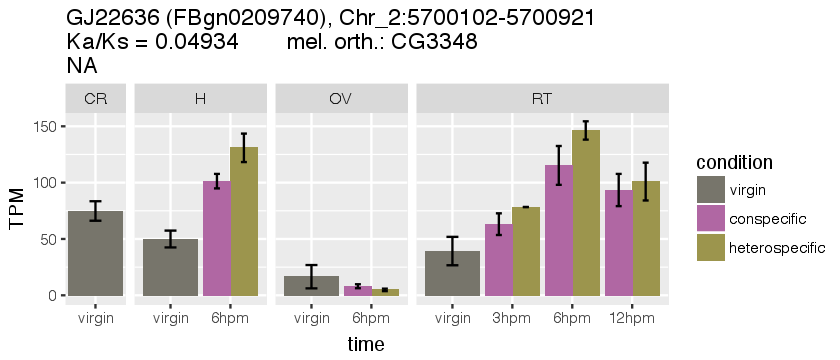

In [25]:
## plot a gene's expression like this:
options(repr.plot.width = 7, repr.plot.height = 3)

plotGenePM(TPMse_DnovPM, "GJ22636")

In [26]:
subset(paml.data, gene_name == "GJ19434")

,FBgn_ID,gene_name,chromosome,min,max,orientation,FBtr_ID,omega,H0_lnL,Damr_brSt_H0,Damr_brSt_H1,Dlum_brSt_H0,Dlum_brSt_H1,Dnov_brSt_H0,Dnov_brSt_H1,Dvir_brSt_H0,Dvir_brSt_H1,DamrNov_brSt_H0,DamrNov_brSt_H1
12438,FBgn0206577,GJ19434,Chr_X,21472903,21479376,-,FBtr0442802,0.12873,-374.0663,-374.0663,-374.0663,-374.0663,-374.0663,-374.0663,-374.0663,-373.5153,-373.5153,-374.0663,-374.0663
12439,FBgn0206577,GJ19434,Chr_X,21472903,21479376,-,FBtr0439591,1.52539,-631.7494,-632.0389,-631.8861,-632.0389,-632.0389,-632.0389,-629.2079,-632.0389,-630.7387,-630.8898,-630.8898
12440,FBgn0206577,GJ19434,Chr_X,21472903,21479376,-,FBtr0442700,0.30853,-741.5798,-740.5816,-740.5257,-740.4267,-740.4267,-740.5898,-740.5898,-740.5898,-740.5898,-740.5898,-740.5898
12441,FBgn0206577,GJ19434,Chr_X,21472903,21479376,-,FBtr0235359,0.12332,-373.6655,-373.6655,-373.6655,-373.6655,-373.6655,-373.6655,-373.6655,-373.1153,-373.1153,-373.6655,-373.6655
12442,FBgn0206577,GJ19434,Chr_X,21472903,21479376,-,FBtr0435206,1.52539,-631.7494,-632.0389,-631.8861,-632.0389,-632.0389,-632.0389,-629.2079,-632.0389,-630.7387,-630.8898,-630.8898


#### Tissue Specificity

The tissue specificty index (_S_) can be calculated for each gene using the virgin tissue samples.

In [27]:
### this is incomplete
Dnov_virgin_tissue_MeanTPMmatrix <- subset(DnovPM_MeanTPMmatrix, select=c(FBgn_ID, V_CR, V_H, V_OV, V_RT))
rownames(Dnov_virgin_tissue_MeanTPMmatrix) <- Dnov_virgin_tissue_MeanTPMmatrix[,1]
Dnov_virgin_tissue_MeanTPMmatrix[,1] <- NULL

## Differential expression analysis

In [31]:
virgin_RT_contrasts<- makeContrasts(V_RT.vs.V_CR=V_RT-V_CR, 
                                        V_RT.vs.V_H=V_RT-V_H,
                                        V_RT.vs.V_OV=V_RT-V_OV,
                                        levels=DnovPM.design)

virgin_OV_contrasts<- makeContrasts(V_OV.vs.V_CR=V_OV-V_CR, 
                                    V_OV.vs.V_H=V_OV-V_H,
                                    V_OV.vs.V_RT=V_OV-V_RT,
                                    levels=DnovPM.design)

virgin_H_contrasts<- makeContrasts(V_H.vs.V_CR=V_H-V_CR, 
                                    V_H.vs.V_OV=V_H-V_OV,
                                    V_H.vs.V_RT=V_H-V_RT,
                                    levels=DnovPM.design)

For each tissue, extract genes that show >2-fold abundance and FDR<0.001:

In [32]:
## RT-biased genes
lrt.RT.v.rest <- glmLRT(DnovPM_fit, contrast = virgin_RT_contrasts)
lrt.RT.v.rest.tTags <- topTags(lrt.RT.v.rest, n = NULL)
lrt.RT.v.rest.tTags.table <- lrt.RT.v.rest.tTags$table
Dnov.dvir1.06.RT.list<-rownames(subset(lrt.RT.v.rest.tTags.table, logFC.V_RT.vs.V_CR > 2 & logFC.V_RT.vs.V_H > 2 & logFC.V_RT.vs.V_OV > 2 & FDR<0.001))

## OV-biased genes
lrt.OV.v.rest <- glmLRT(DnovPM_fit, contrast = virgin_OV_contrasts)
lrt.OV.v.rest.tTags <- topTags(lrt.OV.v.rest, n = NULL)
lrt.OV.v.rest.tTags.table <- lrt.OV.v.rest.tTags$table
Dnov.dvir1.06.OV.list<-rownames(subset(lrt.OV.v.rest.tTags.table, logFC.V_OV.vs.V_CR > 2 & logFC.V_OV.vs.V_H > 2 & logFC.V_OV.vs.V_RT > 2 & FDR<0.001))

## H-biased genes
lrt.H.v.rest <- glmLRT(DnovPM_fit, contrast = virgin_H_contrasts)
lrt.H.v.rest.tTags <- topTags(lrt.H.v.rest, n = NULL)
lrt.H.v.rest.tTags.table <- lrt.H.v.rest.tTags$table
Dnov.dvir1.06.H.list<-rownames(subset(lrt.H.v.rest.tTags.table, logFC.V_H.vs.V_CR > 2 & logFC.V_H.vs.V_OV > 2 & logFC.V_H.vs.V_RT > 2 & FDR<0.001))

We can plot a heatmap of any list of genes by first extracting mean expression values from the matrix of mean TPM values, for example, for RT-biased genes:

In [33]:
Dnov.dvir1.06.RT.matrix <- subset(Dnov_virgin_tissue_MeanTPMmatrix, rownames(Dnov_virgin_tissue_MeanTPMmatrix) %in% Dnov.dvir1.06.RT.list)

In [34]:
length(Dnov.dvir1.06.RT.list) 

[1] 261

Then plot those using the `plotHeatmap` functions:

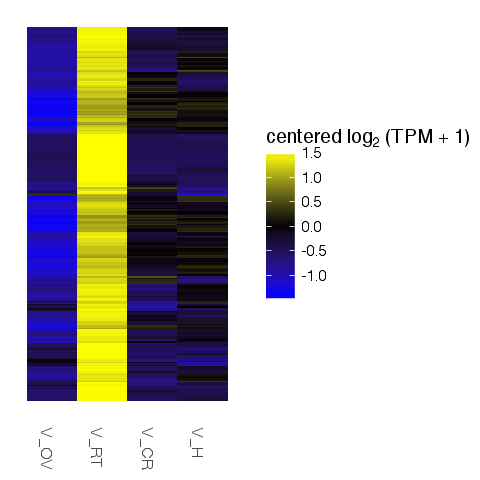

In [35]:
options(repr.plot.width = 4, repr.plot.height = 4)
plotHeatmap(Dnov.dvir1.06.RT.matrix, clustering = "both", labRow = F)

Here's a plot of RT-biased genes along chromosomes and their Ka/Ks values

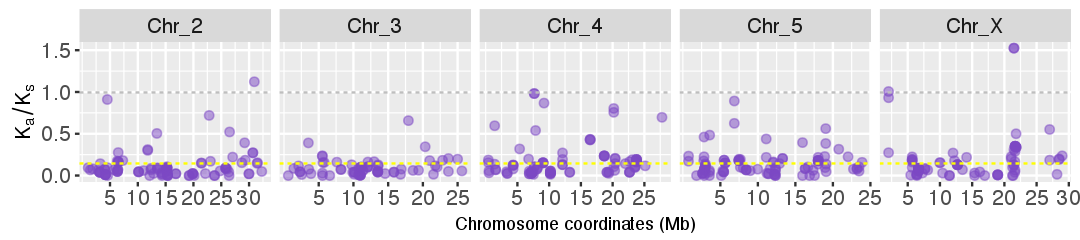

In [36]:
options(repr.plot.width = 9, repr.plot.height = 2)
ggplot(subset(paml.data, FBgn_ID %in% Dnov.dvir1.06.RT.list & omega < 800 & grepl("Chr", chromosome)), aes(max, omega)) + 
    geom_point(size=2, alpha=0.5, colour = "#7d49c3") + 
  #  geom_point(data=subset(paml.data, FBgn_ID %in% SFP_elements$`D.ame,D.lum,D.nov,D.vir` ), aes(max, omega), inherit.aes = F, size=2, alpha=0.5, colour = "#4f922a") + 
    geom_hline(yintercept = 0.15, linetype="dashed", colour = "yellow") + 
    geom_hline(yintercept = 1, linetype="dashed", colour = "gray")  + 
    facet_grid(~chromosome, scales = "free_x") + 
#    scale_colour_manual(name = "", values =c("#7aa457"="#7aa457","#9e6ebd"="#9e6ebd"), labels = c("SFPs","EB biased")) + 
    scale_x_continuous(breaks=seq(5000000,30000000,5000000), labels=expression("5", "10", "15", "20", "25", "30")) + 
    xlab ("Chromosome coordinates (Mb)") + 
    labs(y=expression(K[a]/K[s])) + 
#    geom_text_repel(data=subset(paml.data, FBgn_ID %in% Dnov.dvir1.06.RT.list & omega > 0.95 & omega < 800), aes(label = gene_name), size =3, force = 30, colour = "#7d49c3") +
  #  geom_text_repel(data=subset(paml.data, gene_name == "GJ21515"), aes(label = gene_name), size =3, force = 30, colour = "#4f922a") +
  #  geom_text_repel(data=subset(paml.data, FBgn_ID %in% SFP_elements$`D.ame,D.lum,D.nov,D.vir` & omega > 0.8), aes(label = gene_name), size =3, force = 4, colour = "#4f922a") +
    theme(axis.title.x = element_text(face = "bold", size = 10, vjust=0.1), axis.text.x=element_text(face = "bold", size = 12),axis.text.y = element_text(face = "bold", size = 12), axis.title.y = element_text(face = "bold.italic", size = 12, vjust=0.1), strip.text=element_text(face="bold", size = 12))



## Gene Ontology analysis

Need gene length information and GO annotation files

In [37]:
gene_lengths = read.table("GO.analysis/FBgn_lengths.txt", header=T, row.names=1)
gene_lengths = as.matrix(gene_lengths[,1,drop=F])
GO_info = read.table("GO.analysis/Trinotate_report_dvir1.06_gene_ontology.txt", header=F, row.names=1,stringsAsFactors=F)
GO_info_listed = apply(GO_info, 1, function(x) unlist(strsplit(x,',')))
names(GO_info_listed) = rownames(GO_info)
features_with_GO = rownames(GO_info)
lengths_features_with_GO = gene_lengths[features_with_GO,]
get_GO_term_descr =  function(x) {
    d = 'none';
    go_info = GOTERM[[x]];
    if (length(go_info) >0) { d = paste(Ontology(go_info), Term(go_info), sep=' ');}
    return(d);
}

Define gene groups

In [38]:
RT_factors = as.data.frame(Dnov.dvir1.06.RT.list)
RT_factors$V1 = "RT-biased"
rownames(RT_factors) = Dnov.dvir1.06.RT.list
RT_factors = subset(RT_factors, select = "V1")

OV_factors = as.data.frame(Dnov.dvir1.06.OV.list)
OV_factors$V1 = "OV-biased"
rownames(OV_factors) = Dnov.dvir1.06.OV.list
OV_factors = subset(OV_factors, select = "V1")

H_factors = as.data.frame(Dnov.dvir1.06.H.list)
H_factors$V1 = "H-biased"
rownames(H_factors) = Dnov.dvir1.06.H.list
H_factors = subset(H_factors, select = "V1")

factor_labeling = rbind(RT_factors, OV_factors, H_factors)
colnames(factor_labeling) = c('type')
factor_list = unique(factor_labeling[,1])

Warning message in pcls(G):
"initial point very close to some inequality constraints"

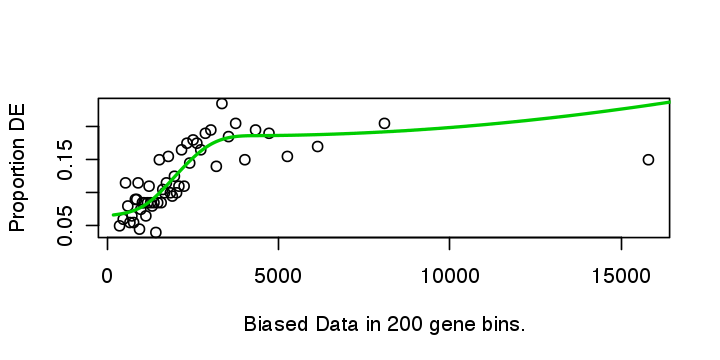

In [39]:
# build pwf based on ALL DE features
options(repr.plot.width = 6, repr.plot.height = 3)

cat_genes_vec = as.integer(features_with_GO %in% rownames(factor_labeling))
pwf=nullp(cat_genes_vec,bias.data=lengths_features_with_GO)
rownames(pwf) = names(GO_info_listed)

In [40]:
GO_enriched_list = list()

for (feature_cat in factor_list) {
    message('Processing category: ', feature_cat)
    cat_genes_vec = as.integer(features_with_GO %in% rownames(factor_labeling)[factor_labeling$type == feature_cat])
    pwf$DEgenes = cat_genes_vec
    res = goseq(pwf,gene2cat=GO_info_listed)
    ## over-represented categories:
    pvals = res$over_represented_pvalue
    pvals[pvals > 1 -1e-10] = 1-1e-10
    q = qvalue(pvals)
    res$over_represented_FDR = q$qvalues
    go_enrich_factor = feature_cat
    enrich_result_table = res[res$over_represented_pvalue<=0.05,]
    descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
    enrich_result_table$go_term = descr
    enrich_result_table$factor = go_enrich_factor
    GO_enriched_list[[feature_cat]] = enrich_result_table
}

GO_enrichment_data = rbindlist(GO_enriched_list)

Processing category: RT-biased
Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns
Processing category: OV-biased
Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns
Processing category: H-biased
Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


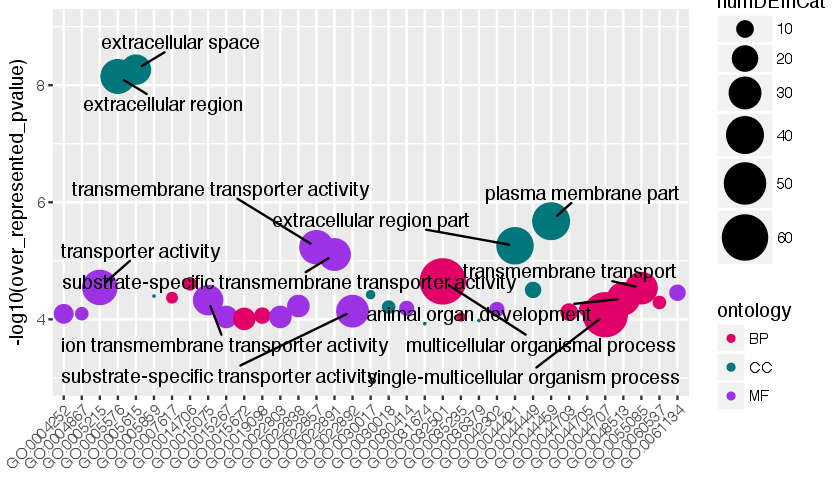

In [41]:
### RT plot
options(repr.plot.width = 7, repr.plot.height = 4)
ggplot(subset(GO_enrichment_data, over_represented_FDR < 0.05 & factor == "RT-biased"), 
       aes(category, -log10(over_represented_pvalue), size = numDEInCat, colour = ontology)) + 
    geom_point()  + 
    xlab(NULL) + 
    geom_text_repel(data = subset(GO_enrichment_data, factor == "RT-biased" & over_represented_FDR < 0.05 & numDEInCat > 20), 
                    aes(category, -log10(over_represented_pvalue),label=term), 
                    force = 8, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 4) + 
    theme(axis.text.x = element_text(angle = 45, face = "bold", vjust = 1, hjust = 1)) + 
    scale_size(range = c(0,12)) + 
    scale_colour_manual(values=c("#e00068",
                                 "#01777b",
                                 "#9d31e4")) + 
    scale_y_continuous(limits=c(3, 9))

#### Reproductive tract post-mating contrasts:

Create RT-specific count matrix 

In [42]:
DnovPM_CountsMatrix_RT = subset(DnovPM.dvir1.06.CountsMatrix.BRR.min400count, select=grepl("RT", colnames(DnovPM.dvir1.06.CountsMatrix.BRR.min400count)))

Filter this matrix by minimum read count:

In [43]:
DnovPM_max_gene_expr_per_row = apply(DnovPM_CountsMatrix_RT, 1, max)
DnovPM_CountsMatrix_RT.min400 = DnovPM_CountsMatrix_RT[DnovPM_max_gene_expr_per_row >= 400,,drop=F ]

In [44]:
head(DnovPM_CountsMatrix_RT.min400)

,C12_RT_1,C12_RT_2,C12_RT_3,C3_RT_1,C3_RT_2,C3_RT_3,C6_RT_2,C6_RT_3,H12_RT_1,H12_RT_2,H12_RT_3,H3_RT_2,H3_RT_3,H6_RT_2,H6_RT_3,V_RT_1,V_RT_2,V_RT_3
FBgn0202928,435.52,541.22,553.43,380.65,534.23,466.21,731.63,433.42,854.99,943.25,691.22,467.27,994.93,1023.68,646.37,1092.88,863.67,1396.54
FBgn0199563,298.09,479.05,462.67,318.37,358.64,348.37,536.98,392.55,701.70,792.18,576.08,439.20,761.34,906.30,451.57,631.27,559.54,715.31
FBgn0206588,945.11,1517.41,1416.42,1005.06,1266.19,1489.42,1620.62,1347.77,2444.35,2675.51,1962.39,1798.57,3041.42,3692.64,1336.11,1992.25,1559.37,2273.14
FBgn0209112,4210.54,6065.79,6846.71,5825.36,6491.43,6060.99,7472.51,5589.99,11335.59,13959.97,9401.40,7315.25,14172.82,15716.41,8518.75,13062.22,12407.59,18214.81
FBgn0199619,17366.10,28560.49,27162.75,17488.97,19332.37,20146.09,30799.76,22289.46,44247.30,45797.95,33756.23,23929.07,43550.17,53683.53,27844.57,36968.67,32613.69,49394.90
FBgn0204214,5648.44,9174.87,7668.11,6162.42,7809.01,5854.85,8596.33,7860.91,12156.30,12852.00,10063.44,5469.68,12391.59,13329.43,7001.61,18221.55,19460.64,25679.84


Generate design matrix and define groups

In [45]:
RT.group <- factor(c(1,1,1,2,2,2,3,3,4,4,4,5,5,6,6,7,7,7))
RT.design <- model.matrix(~0+RT.group)
colnames(RT.design)<-c("C12_RT", "C3_RT", "C6_RT", "H12_RT", "H3_RT", "H6_RT", "V_RT")

Create edgeR DE object and run glmFit

In [46]:
DnovPM_DGElist_RT<-DGEList(counts = DnovPM_CountsMatrix_RT.min400, group = RT.group)
DnovPM_DGElist_RT<-calcNormFactors(DnovPM_DGElist_RT)
DnovPM_DGElist_RT<-estimateDisp(DnovPM_DGElist_RT, RT.design, robust = T)
DnovPM_RT_fit <- glmFit(DnovPM_DGElist_RT, RT.design)

In [61]:
g <- gof(DnovPM_RT_fit)
z <- zscoreGamma(g$gof.statistics,shape=gof$df / 2,scale=2)

ERROR: Error in gof$df: object of type 'closure' is not subsettable


Define contrasts to be tested

In [47]:
con_virgin_contrasts <- makeContrasts(C3.vs.V=C3_RT-V_RT, C6.vs.V=C6_RT-V_RT, C12.vs.V=C12_RT-V_RT, levels = RT.design)
het_virgin_contrasts <- makeContrasts(H3.vs.V=H3_RT-V_RT, H6.vs.V=H6_RT-V_RT, H12.vs.V=H12_RT-V_RT, levels = RT.design)

Identify DE genes between virgin and all postmating samples

In [48]:
RT_con.vs.virgin <- glmLRT(DnovPM_RT_fit, contrast = con_virgin_contrasts)
RT_con.vs.virgin.tTags <- topTags(RT_con.vs.virgin, n = NULL)
RT_con.vs.virgin.tTags.table <- RT_con.vs.virgin.tTags$table
RT_con.vs.virgin.tTags.table$FBgn_ID <- rownames(RT_con.vs.virgin.tTags.table)

RT_het.vs.virgin <- glmLRT(DnovPM_RT_fit, contrast = het_virgin_contrasts)
RT_het.vs.virgin.tTags <- topTags(RT_het.vs.virgin, n = NULL)
RT_het.vs.virgin.tTags.table <- RT_het.vs.virgin.tTags$table
RT_het.vs.virgin.tTags.table$FBgn_ID <- rownames(RT_het.vs.virgin.tTags.table)

In [49]:
colnames(RT_con.vs.virgin.tTags.table) = c("3hpm", "6hpm", "12hpm", "logCPM", "LR", "pvalue", "FDR", "FBgn_ID")
colnames(RT_het.vs.virgin.tTags.table) = c("3hpm", "6hpm", "12hpm", "logCPM", "LR", "pvalue", "FDR", "FBgn_ID")

head(RT_con.vs.virgin.tTags.table)
head(RT_het.vs.virgin.tTags.table)

,3hpm,6hpm,12hpm,logCPM,LR,pvalue,FDR,FBgn_ID
FBgn0198861,2.9935293,1.204777,0.3051668,5.241462,873.2722,5.550898e-189,3.710220e-185,FBgn0198861
FBgn0199412,2.0701762,3.504898,4.0818578,7.766424,659.5361,1.246726e-142,4.166558e-139,FBgn0199412
FBgn0198037,-1.8604222,-2.203550,-2.8935859,3.309744,337.8169,6.479754e-73,1.443689e-69,FBgn0198037
FBgn0208092,2.3176135,3.063180,2.0314281,6.720275,294.3007,1.703014e-63,2.845737e-60,FBgn0208092
FBgn0209375,0.7611869,2.202677,2.0905668,5.235392,259.1301,6.933999e-56,9.269370e-53,FBgn0209375
FBgn0200611,1.3625801,2.026408,1.7716102,7.202215,249.1764,9.861973e-54,1.082821e-50,FBgn0200611


,3hpm,6hpm,12hpm,logCPM,LR,pvalue,FDR,FBgn_ID
FBgn0208031,7.012423,6.535943,-0.05205981,2.418138,1327.2971,1.757327e-287,1.174598e-283,FBgn0208031
FBgn0198861,2.775086,1.454250,0.38921066,5.241462,618.8314,8.334880e-134,2.785517e-130,FBgn0198861
FBgn0199412,2.325487,3.403601,3.92392518,7.766424,573.8805,4.629583e-124,1.031471e-120,FBgn0199412
FBgn0206847,3.346474,2.729407,0.61313307,2.935890,519.9622,2.251187e-112,3.761733e-109,FBgn0206847
FBgn0203480,1.638590,1.093669,0.03535923,5.121406,382.8619,1.140744e-82,1.524947e-79,FBgn0203480
FBgn0205175,2.641661,2.162041,0.85732450,4.989258,316.6537,2.472435e-68,2.754292e-65,FBgn0205175


In [50]:
PM.RT.con_vs_virgin.m <-melt(RT_con.vs.virgin.tTags.table, id.vars = c("pvalue", "FDR", "FBgn_ID", "LR", "logCPM"))
PM.RT.con_vs_virgin.m$cross = "Conspecific"
PM.RT.het_vs_virgin.m <-melt(RT_het.vs.virgin.tTags.table, id.vars = c("pvalue", "FDR", "FBgn_ID", "LR", "logCPM"))
PM.RT.het_vs_virgin.m$cross = "Heterospecific"

RT.PM_vs_virgin.m = rbind(PM.RT.con_vs_virgin.m, PM.RT.het_vs_virgin.m)
RT.PM_vs_virgin.m$sig = ifelse(RT.PM_vs_virgin.m$FDR < 0.00001, "YES", "NO")
head(RT.PM_vs_virgin.m)

pvalue,FDR,FBgn_ID,LR,logCPM,variable,value,cross,sig
5.550898e-189,3.710220e-185,FBgn0198861,873.2722,5.241462,3hpm,2.9935293,Conspecific,YES
1.246726e-142,4.166558e-139,FBgn0199412,659.5361,7.766424,3hpm,2.0701762,Conspecific,YES
6.479754e-73,1.443689e-69,FBgn0198037,337.8169,3.309744,3hpm,-1.8604222,Conspecific,YES
1.703014e-63,2.845737e-60,FBgn0208092,294.3007,6.720275,3hpm,2.3176135,Conspecific,YES
6.933999e-56,9.269370e-53,FBgn0209375,259.1301,5.235392,3hpm,0.7611869,Conspecific,YES
9.861973e-54,1.082821e-50,FBgn0200611,249.1764,7.202215,3hpm,1.3625801,Conspecific,YES


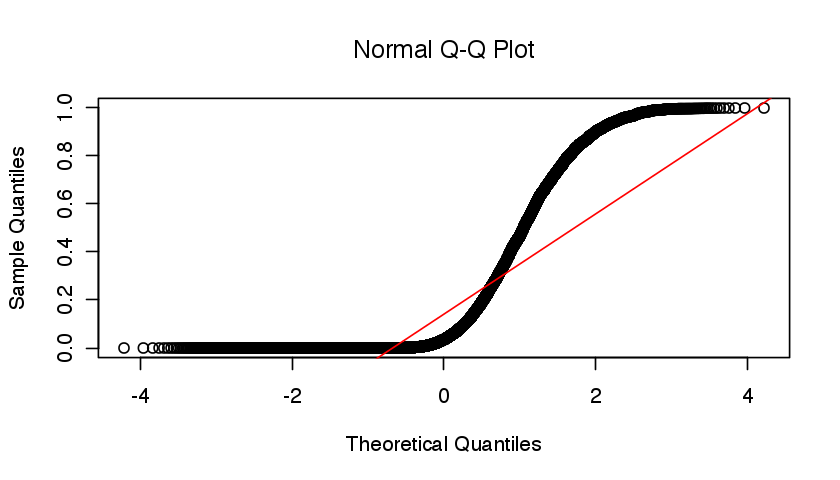

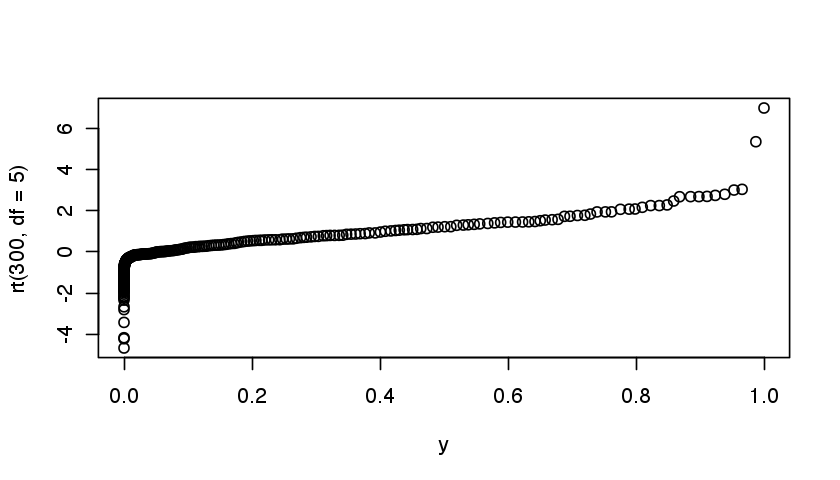

In [55]:
y <- RT.PM_vs_virgin.m$pvalue
qqnorm(y); qqline(y, col = 2)
qqplot(y, rt(300, df = 5))

In [52]:
ggplot(data, aes(sample = RT.PM_vs_virgin.m$pvalue)) + stat_qq(color="firebrick2", alpha=1) + geom_abline(intercept = mean(RT.PM_vs_virgin.m$pvalue), slope = sd(RT.PM_vs_virgin.m$pvalue))

ERROR: Error: ggplot2 doesn't know how to deal with data of class matrix


In [ ]:
options(repr.plot.width = 9, repr.plot.height = 4)
ggplot(RT.PM_vs_virgin.m, aes(value, -log10(FDR), colour = sig)) + 
    geom_point(alpha=I(1/2)) + 
    facet_grid(cross~variable, scales = "free")

In [ ]:
length(unique(subset(RT.PM_vs_virgin.m, sig == "YES")$FBgn_ID))

### Pair-wise DE contrasts

Perform pair-wise DE analysis between each PM RT sample and the virgin RT sample

In [ ]:
# C3_RT vs V_RT
RT_con.3hrs.vs.virgin <- glmLRT(DnovPM_RT_fit, contrast = con_virgin_contrasts[,"C3.vs.V"])
RT_con.3hrs.vs.virgin.tTags <- topTags(RT_con.3hrs.vs.virgin, n = NULL)
RT_con.3hrs.vs.virgin.tTags.table <- RT_con.3hrs.vs.virgin.tTags$table
RT_con.3hrs.vs.virgin.Up.list <- rownames(subset(RT_con.3hrs.vs.virgin.tTags.table, logFC > 1 & FDR < 0.001))
RT_con.3hrs.vs.virgin.Down.list <- rownames(subset(RT_con.3hrs.vs.virgin.tTags.table, logFC < -1 & FDR < 0.001))
# C6_RT vs V_RT
RT_con.6hrs.vs.virgin <- glmLRT(DnovPM_RT_fit, contrast = con_virgin_contrasts[,"C6.vs.V"])
RT_con.6hrs.vs.virgin.tTags <- topTags(RT_con.6hrs.vs.virgin, n = NULL)
RT_con.6hrs.vs.virgin.tTags.table <- RT_con.6hrs.vs.virgin.tTags$table
RT_con.6hrs.vs.virgin.Up.list <- rownames(subset(RT_con.6hrs.vs.virgin.tTags.table, logFC > 1 & FDR < 0.001))
RT_con.6hrs.vs.virgin.Down.list <- rownames(subset(RT_con.6hrs.vs.virgin.tTags.table, logFC < -1 & FDR < 0.001))
# C12_RT vs V_RT
RT_con.12hrs.vs.virgin <- glmLRT(DnovPM_RT_fit, contrast = con_virgin_contrasts[,"C12.vs.V"])
RT_con.12hrs.vs.virgin.tTags <- topTags(RT_con.12hrs.vs.virgin, n = NULL)
RT_con.12hrs.vs.virgin.tTags.table <- RT_con.12hrs.vs.virgin.tTags$table
RT_con.12hrs.vs.virgin.Up.list <- rownames(subset(RT_con.12hrs.vs.virgin.tTags.table, logFC > 1 & FDR < 0.001))
RT_con.12hrs.vs.virgin.Down.list <- rownames(subset(RT_con.12hrs.vs.virgin.tTags.table, logFC < -1 & FDR < 0.001))

In [ ]:
# H3_RT vs V_RT
RT_het.3hrs.vs.virgin <- glmLRT(DnovPM_RT_fit, contrast = het_virgin_contrasts[,"H3.vs.V"])
RT_het.3hrs.vs.virgin.tTags <- topTags(RT_het.3hrs.vs.virgin, n = NULL)
RT_het.3hrs.vs.virgin.tTags.table <- RT_het.3hrs.vs.virgin.tTags$table
RT_het.3hrs.vs.virgin.Up.list <- rownames(subset(RT_het.3hrs.vs.virgin.tTags.table, logFC > 1 & FDR < 0.001))
RT_het.3hrs.vs.virgin.Down.list <- rownames(subset(RT_het.3hrs.vs.virgin.tTags.table, logFC < -1 & FDR < 0.001))
# H6_RT vs V_RT
RT_het.6hrs.vs.virgin <- glmLRT(DnovPM_RT_fit, contrast = het_virgin_contrasts[,"H6.vs.V"])
RT_het.6hrs.vs.virgin.tTags <- topTags(RT_het.6hrs.vs.virgin, n = NULL)
RT_het.6hrs.vs.virgin.tTags.table <- RT_het.6hrs.vs.virgin.tTags$table
RT_het.6hrs.vs.virgin.Up.list <- rownames(subset(RT_het.6hrs.vs.virgin.tTags.table, logFC > 1 & FDR < 0.001))
RT_het.6hrs.vs.virgin.Down.list <- rownames(subset(RT_het.6hrs.vs.virgin.tTags.table, logFC < -1 & FDR < 0.001))
# H12_RT vs V_RT
RT_het.12hrs.vs.virgin <- glmLRT(DnovPM_RT_fit, contrast = het_virgin_contrasts[,"H12.vs.V"])
RT_het.12hrs.vs.virgin.tTags <- topTags(RT_het.12hrs.vs.virgin, n = NULL)
RT_het.12hrs.vs.virgin.tTags.table <- RT_het.12hrs.vs.virgin.tTags$table
RT_het.12hrs.vs.virgin.Up.list <- rownames(subset(RT_het.12hrs.vs.virgin.tTags.table, logFC > 1 & FDR < 0.001))
RT_het.12hrs.vs.virgin.Down.list <- rownames(subset(RT_het.12hrs.vs.virgin.tTags.table, logFC < -1 & FDR < 0.001))

In [ ]:
RT_UP_3hrs_candidates <- list(Conspecific = RT_con.3hrs.vs.virgin.Up.list, Heterospecific = RT_het.3hrs.vs.virgin.Up.list)
RT_UP_6hrs_candidates <- list(Conspecific = RT_con.6hrs.vs.virgin.Up.list, Heterospecific = RT_het.6hrs.vs.virgin.Up.list)
RT_UP_12hrs_candidates <- list(Conspecific = RT_con.12hrs.vs.virgin.Up.list, Heterospecific = RT_het.12hrs.vs.virgin.Up.list)
RT_Down_3hrs_candidates <- list(Conspecific = RT_con.3hrs.vs.virgin.Down.list, Heterospecific = RT_het.3hrs.vs.virgin.Down.list)
RT_Down_6hrs_candidates <- list(Conspecific = RT_con.6hrs.vs.virgin.Down.list, Heterospecific = RT_het.6hrs.vs.virgin.Down.list)
RT_Down_12hrs_candidates <- list(Conspecific = RT_con.12hrs.vs.virgin.Down.list, Heterospecific = RT_het.12hrs.vs.virgin.Down.list)

In [ ]:
# Rearrange into lists of lists, and partition by species
RT_UP_3hrs_combs <- unlist(lapply(1:length(RT_UP_3hrs_candidates), function(j) combn(names(RT_UP_3hrs_candidates), j, simplify = FALSE)), recursive = FALSE)
RT_UP_6hrs_combs <- unlist(lapply(1:length(RT_UP_6hrs_candidates), function(j) combn(names(RT_UP_6hrs_candidates), j, simplify = FALSE)), recursive = FALSE)
RT_UP_12hrs_combs <- unlist(lapply(1:length(RT_UP_12hrs_candidates), function(j) combn(names(RT_UP_12hrs_candidates), j, simplify = FALSE)), recursive = FALSE)
RT_Down_3hrs_combs <- unlist(lapply(1:length(RT_Down_3hrs_candidates), function(j) combn(names(RT_Down_3hrs_candidates), j, simplify = FALSE)), recursive = FALSE)
RT_Down_6hrs_combs <- unlist(lapply(1:length(RT_Down_6hrs_candidates), function(j) combn(names(RT_Down_6hrs_candidates), j, simplify = FALSE)), recursive = FALSE)
RT_Down_12hrs_combs <- unlist(lapply(1:length(RT_Down_12hrs_candidates), function(j) combn(names(RT_Down_12hrs_candidates), j, simplify = FALSE)), recursive = FALSE)

names(RT_UP_3hrs_combs) <- sapply(RT_UP_3hrs_combs, function(i) paste0(i, collapse = ","))
names(RT_UP_6hrs_combs) <- sapply(RT_UP_6hrs_combs, function(i) paste0(i, collapse = ","))
names(RT_UP_12hrs_combs) <- sapply(RT_UP_12hrs_combs, function(i) paste0(i, collapse = ","))
names(RT_Down_3hrs_combs) <- sapply(RT_Down_3hrs_combs, function(i) paste0(i, collapse = ","))
names(RT_Down_6hrs_combs) <- sapply(RT_Down_6hrs_combs, function(i) paste0(i, collapse = ","))
names(RT_Down_12hrs_combs) <- sapply(RT_Down_12hrs_combs, function(i) paste0(i, collapse = ","))

RT_UP_3hrs_elements <- lapply(RT_UP_3hrs_combs, function(i) Setdiff(RT_UP_3hrs_candidates[i], RT_UP_3hrs_candidates[setdiff(names(RT_UP_3hrs_candidates), i)]))
RT_UP_6hrs_elements <- lapply(RT_UP_6hrs_combs, function(i) Setdiff(RT_UP_6hrs_candidates[i], RT_UP_6hrs_candidates[setdiff(names(RT_UP_6hrs_candidates), i)]))
RT_UP_12hrs_elements <- lapply(RT_UP_12hrs_combs, function(i) Setdiff(RT_UP_12hrs_candidates[i], RT_UP_12hrs_candidates[setdiff(names(RT_UP_12hrs_candidates), i)]))
RT_Down_3hrs_elements <- lapply(RT_Down_3hrs_combs, function(i) Setdiff(RT_Down_3hrs_candidates[i], RT_Down_3hrs_candidates[setdiff(names(RT_Down_3hrs_candidates), i)]))
RT_Down_6hrs_elements <- lapply(RT_Down_6hrs_combs, function(i) Setdiff(RT_Down_6hrs_candidates[i], RT_Down_6hrs_candidates[setdiff(names(RT_Down_6hrs_candidates), i)]))
RT_Down_12hrs_elements <- lapply(RT_Down_12hrs_combs, function(i) Setdiff(RT_Down_12hrs_candidates[i], RT_Down_12hrs_candidates[setdiff(names(RT_Down_12hrs_candidates), i)]))

In [ ]:
### Draw a VennDiagram of each element
RT_UP_3hrs_Vdiag<-venn.diagram(RT_UP_3hrs_candidates, NULL, fill=c("#b067a3", "#9c954d"), alpha=c(0.75,0.75), cex = 1, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "3hpm")
RT_UP_6hrs_Vdiag<-venn.diagram(RT_UP_6hrs_candidates, NULL, fill=c("#b067a3", "#9c954d"), alpha=c(0.75,0.75), cex = 1, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "6hpm")
RT_UP_12hrs_Vdiag<-venn.diagram(RT_UP_12hrs_candidates, NULL, fill=c("#b067a3", "#9c954d"), alpha=c(0.75,0.75), cex = 1, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "12hpm")

options(repr.plot.width = 4, repr.plot.height = 3)
grid.arrange(gTree(children=RT_UP_3hrs_Vdiag), gTree(children=RT_UP_6hrs_Vdiag), gTree(children=RT_UP_12hrs_Vdiag))

In [ ]:
RT_Down_3hrs_Vdiag<-venn.diagram(RT_Down_3hrs_candidates, NULL, fill=c("#b067a3", "#9c954d"), alpha=c(0.75,0.75), cex = 1.5, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "3hpm")
RT_Down_6hrs_Vdiag<-venn.diagram(RT_Down_6hrs_candidates, NULL, fill=c("#b067a3", "#9c954d"), alpha=c(0.75,0.75), cex = 1.5, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "6hpm")
RT_Down_12hrs_Vdiag<-venn.diagram(RT_Down_12hrs_candidates, NULL, fill=c("#b067a3", "#9c954d"), alpha=c(0.75,0.75), cex = 1.5, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "12hpm")

options(repr.plot.width = 4, repr.plot.height = 3)
grid.arrange(gTree(children=RT_Down_3hrs_Vdiag), gTree(children=RT_Down_6hrs_Vdiag), gTree(children=RT_Down_12hrs_Vdiag))

Test Difference between conspecific and heterospecific PM samples:

In [ ]:
condition.group = subset(m.DnovPM.TPM.tmp, FBgn_ID == "FBgn0202928" & tissue == "RT")
condition.group$replicates = colnames(DnovPM_CountsMatrix_RT.min400)
rownames(condition.group) <- condition.group$replicates
condition.group = subset(condition.group, select = c(sample, condition, time))

condition.design <- model.matrix(~0+condition, data = condition.group)
colnames(condition.design) <- unique(condition.group$condition)

condition.contrasts <- makeContrasts(con.vs.het = conspecific-heterospecific,
                                     con.vs.vir = conspecific - virgin,
                                     het.vs.vir = heterospecific - virgin,
                                     levels = condition.design)

In [ ]:
lrt <- glmFit(DnovPM_DGElist_RT, condition.design)
con.vs.het.RT.all.contrast <- glmLRT(lrt, contrast = condition.contrasts[,"con.vs.het"])
con.vs.het.RT.all.tTags <- topTags(con.vs.het.RT.all.contrast, n = NULL)
con.vs.het.RT.all.tTags.table <- con.vs.het.RT.all.tTags$table
con.vs.het.RT.het.Up.list <- rownames(subset(con.vs.het.RT.all.tTags.table, logFC < -1 & FDR < 0.001))
con.vs.het.RT.con.Up.list <- rownames(subset(con.vs.het.RT.all.tTags.table, logFC > 1 & FDR < 0.001))

con.vs.vir.RT.all.contrast <- glmLRT(lrt, contrast = condition.contrasts[,"con.vs.vir"])
con.vs.vir.RT.all.tTags <- topTags(con.vs.vir.RT.all.contrast, n = NULL)
con.vs.vir.RT.all.tTags.table <- con.vs.vir.RT.all.tTags$table
con.vs.vir.RT.con.Up.list <- rownames(subset(con.vs.vir.RT.all.tTags.table, logFC > 1 & FDR < 0.001))
con.vs.vir.RT.con.Down.list <- rownames(subset(con.vs.vir.RT.all.tTags.table, logFC < -1 & FDR < 0.001))

het.vs.vir.RT.all.contrast <- glmLRT(lrt, contrast = condition.contrasts[,"het.vs.vir"])
het.vs.vir.RT.all.tTags <- topTags(het.vs.vir.RT.all.contrast, n = NULL)
het.vs.vir.RT.all.tTags.table <- het.vs.vir.RT.all.tTags$table
het.vs.vir.RT.het.Up.list <- rownames(subset(het.vs.vir.RT.all.tTags.table, logFC > 1 & FDR < 0.001))
het.vs.vir.RT.het.Down.list <- rownames(subset(het.vs.vir.RT.all.tTags.table, logFC < -1 & FDR < 0.001))

In [ ]:
PM.vs.vir_Up_candidates <- list(conspecific = con.vs.vir.RT.con.Up.list, heterospecific = het.vs.vir.RT.het.Up.list)
PM.vs.vir_Down_candidates <- list(conspecific = con.vs.vir.RT.con.Down.list, heterospecific = het.vs.vir.RT.het.Down.list)


PM.vs.vir_Up_candidates_Vdiag<-venn.diagram(PM.vs.vir_Up_candidates, NULL, fill=c("#b067a3", "#9c954d"), alpha=c(0.75,0.75), cex = 1.5, cat.fontface= 4, cat.cex = 0, resolution = 1000, main = "Upregulated")
PM.vs.vir_Down_candidates_Vdiag<-venn.diagram(PM.vs.vir_Down_candidates, NULL, fill=c("#b067a3", "#9c954d"), alpha=c(0.75,0.75), cex = 1.5, cat.fontface= 4, cat.cex = 0, resolution = 1000, main = "Downregulated")
options(repr.plot.width = 4, repr.plot.height = 1)
grid.arrange(gTree(children=PM.vs.vir_Up_candidates_Vdiag))
grid.arrange(gTree(children=PM.vs.vir_Down_candidates_Vdiag))


In [ ]:
RT_UP_3hrs_candidates

In [ ]:
options(repr.plot.width = 6, repr.plot.height = 2)
lapply(RT_UP_6hrs_candidates$Heterospecific, plotGenePM, object = TPMse_DnovPM)

### Ovary contrasts

In [ ]:
########### RT contrasts
# create RT-specific count matrix and define groups/design
DnovPM_CountsMatrix_OV = subset(DnovPM.dvir1.06.CountsMatrix.BRR.min400count, select=grepl("OV", colnames(DnovPM.dvir1.06.CountsMatrix.BRR.min400count)))

## filter this matrix by minimum read count
DnovPM_max_gene_expr_per_row = apply(DnovPM_CountsMatrix_OV, 1, max)
DnovPM_CountsMatrix_OV.min200 = DnovPM_CountsMatrix_OV[DnovPM_max_gene_expr_per_row >= 200,,drop=F ]
head(DnovPM_CountsMatrix_OV.min200)

In [ ]:
######
OV.group <- factor(c(1,1,2,2,3,3))
OV.design <- model.matrix(~0+OV.group)
colnames(OV.design)<-c("C6_OV", "H6_OV", "V_OV")
OV.group
OV.design

In [ ]:
# create edgeR DE object and run glm
DnovPM_DGElist_OV<-DGEList(counts = DnovPM_CountsMatrix_OV.min200, group = OV.group)
DnovPM_DGElist_OV<-calcNormFactors(DnovPM_DGElist_OV)
DnovPM_DGElist_OV<-estimateDisp(DnovPM_DGElist_OV, OV.design, robust = T)
DnovPM_OV_fit <- glmFit(DnovPM_DGElist_OV, OV.design)

# define contrasts
OV_contrasts <- makeContrasts(C6.vs.V=C6_OV-V_OV, H6.vs.V=H6_OV-V_OV, C6.vs.H6=C6_OV-H6_OV, levels = OV.design)
OV_contrasts

In [ ]:
# identify overall con_vs_het
OV_all_comaprisons <- glmLRT(DnovPM_OV_fit, contrast = OV_contrasts)
OV_all_comaprisons.tTags <- topTags(OV_all_comaprisons, n = NULL)
OV_all_comaprisons.tTags.table <- OV_all_comaprisons.tTags$table
OV_all_comaprisons.tTags.table$FBgn_ID <- rownames(OV_all_comaprisons.tTags.table)
head(OV_all_comaprisons.tTags.table)

In [ ]:
colnames(OV_all_comaprisons.tTags.table) = c("conspceific", "heterospecific", "logCPM", "LR", "p-value", "FDR", "FBgn_ID")
OV_all_comaprisons.tTags.table.m <-melt(OV_all_comaprisons.tTags.table, id.vars = c("p-value", "FDR", "FBgn_ID", "LR", "logCPM"))
OV_all_comaprisons.tTags.table.m$sig = ifelse(OV_all_comaprisons.tTags.table.m$FDR < 0.001 & OV_all_comaprisons.tTags.table.m$value > 1, "YES", "NO")
head(OV_all_comaprisons.tTags.table.m)

In [ ]:
options(repr.plot.width = 6, repr.plot.height = 2)
ggplot(OV_all_comaprisons.tTags.table.m, aes(value, -log10(FDR), colour = sig)) + 
    geom_point(alpha=I(1/2)) + 
    facet_wrap(~variable, scales = "free") +
    geom_text_repel(data=subset(OV_all_comaprisons.tTags.table.m, -log10(FDR) > 10), aes(label = FBgn_ID), size =2.5, colour = "#4f922a")

In [ ]:
OV_DE.list = unique(subset(OV_all_comaprisons.tTags.table.m, sig == "YES")$FBgn_ID)
lapply(OV_DE.list, plotGenePM, object = TPMse_DnovPM)

### Head contrasts

In [ ]:
########### RT contrasts
# create RT-specific count matrix and define groups/design
DnovPM_CountsMatrix_H = subset(DnovPM.dvir1.06.CountsMatrix.BRR.min400count, select=grepl("_H", colnames(DnovPM.dvir1.06.CountsMatrix.BRR.min400count)))

## filter this matrix by minimum read count
DnovPM_max_gene_expr_per_row = apply(DnovPM_CountsMatrix_H, 1, max)
DnovPM_CountsMatrix_H.min200 = DnovPM_CountsMatrix_H[DnovPM_max_gene_expr_per_row >= 200,,drop=F ]
head(DnovPM_CountsMatrix_H.min200)

In [ ]:
######
H.group <- factor(c(1,1,2,2,3,3))
H.design <- model.matrix(~0+H.group)
colnames(H.design)<-c("C6_H", "H6_H", "V_H")
H.design

In [ ]:
# create edgeR DE object and run glm
DnovPM_DGElist_H<-DGEList(counts = DnovPM_CountsMatrix_H.min200, group = H.group)
DnovPM_DGElist_H<-calcNormFactors(DnovPM_DGElist_H)
DnovPM_DGElist_H<-estimateDisp(DnovPM_DGElist_H, H.design, robust = T)
DnovPM_H_fit <- glmFit(DnovPM_DGElist_H, H.design)

# define contrasts
H_contrasts <- makeContrasts(C6.vs.V=C6_H-V_H, H6.vs.V=H6_H-V_H, C6.vs.H6=C6_H-H6_H, levels = H.design)
H_contrasts

In [ ]:
# identify overall con_vs_het
H_all_comaprisons <- glmLRT(DnovPM_H_fit, contrast = H_contrasts)
H_all_comaprisons.tTags <- topTags(H_all_comaprisons, n = NULL)
H_all_comaprisons.tTags.table <- H_all_comaprisons.tTags$table
H_all_comaprisons.tTags.table$FBgn_ID <- rownames(H_all_comaprisons.tTags.table)
head(H_all_comaprisons.tTags.table)

In [ ]:
colnames(H_all_comaprisons.tTags.table) = c("conspceific", "heterospecific", "logCPM", "LR", "p-value", "FDR", "FBgn_ID")
H_all_comaprisons.tTags.table.m <-melt(H_all_comaprisons.tTags.table, id.vars = c("p-value", "FDR", "FBgn_ID", "LR", "logCPM"))
H_all_comaprisons.tTags.table.m$sig = ifelse(H_all_comaprisons.tTags.table.m$FDR < 0.001, "YES", "NO")
head(H_all_comaprisons.tTags.table.m)

In [ ]:
options(repr.plot.width = 6, repr.plot.height = 2)
ggplot(H_all_comaprisons.tTags.table.m, aes(value, -log10(FDR), colour = sig)) + 
    geom_point(alpha=I(1/2)) + 
    facet_wrap(~variable, scales = "free")
#    geom_text_repel(data=subset(H_all_comaprisons.tTags.table.m, -log10(FDR) > 10), aes(label = FBgn_ID), size =2.5, colour = "#4f922a")

In [ ]:
H_DE.list = unique(subset(H_all_comaprisons.tTags.table.m, sig == "YES")$FBgn_ID)
lapply(H_DE.list, plotGenePM, object = TPMse_DnovPM)

In [ ]:
subset(melOrths, mel_GeneSymbol == "hdly")

In [ ]:
plotGenePM(TPMse_DnovPM, "GJ10165")